# Environment set up

In [34]:
# load required packages

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
import random

from IPython.display import display

import getpass
import ndex2

import json
import cdapsutil
import pydot

# need ddot to parse the ontology
import ddot
from ddot import Ontology

# annotate the clusters
# gprofiler prelim annotation
from gprofiler import GProfiler
gp = GProfiler("MyToolName/0.1")

from statsmodels.stats import contingency_tables
from statsmodels.stats.multitest import fdrcorrection

import requests

# find human orthologs of mouse genes
import mygene
mg = mygene.MyGeneInfo()

from scipy.stats import hypergeom
from scipy.stats import norm

# latex rendering of text in graphs
import matplotlib as mpl
mpl.rc('text', usetex = False)
mpl.rc('font', family = 'serif')

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

sns.set(font_scale=1.4)

sns.set_style('white')

sns.set_style("ticks", {"xtick.major.size": 15, "ytick.major.size": 15})
plt.rcParams['svg.fonttype'] = 'none'

import sys
from tqdm import tqdm

# % matplotlib inline

from random import randint
from matplotlib.patches import Patch

In [35]:
## LOAD PCNET
interactome_uuid='4de852d9-9908-11e9-bcaf-0ac135e8bacf' # for PCNet
# interactome_uuid='275bd84e-3d18-11e8-a935-0ac135e8bacf' # for STRING high confidence
ndex_server='public.ndexbio.org'
ndex_user=None
ndex_password=None
G_int = ndex2.create_nice_cx_from_server(
            ndex_server, 
            username=ndex_user, 
            password=ndex_password, 
            uuid=interactome_uuid
        ).to_networkx()
nodes = list(G_int.nodes)

# pcnet appears to have some self edges... should remove them. 
G_int.remove_edges_from(nx.selfloop_edges(G_int))

# print out interactome num nodes and edges for diagnostic purposes
print('number of nodes:')
print(len(G_int.nodes))
print('\nnumber of edges:')
print(len(G_int.edges))

nodes = list(G_int.nodes)
pd.DataFrame(G_int.nodes).to_csv("pcnet_node_list.tsv", sep="\t", index=False, header=False)

number of nodes:
18820

number of edges:
2693109


In [36]:
## Load conserved network
ndex_server='public.ndexbio.org'
ndex_user=None
ndex_password=None
G_overlap_cx = ndex2.create_nice_cx_from_server(
            ndex_server, 
            username=ndex_user, 
            password=ndex_password, 
            uuid='e8cc9239-d91a-11eb-b666-0ac135e8bacf'
        )


# print out interactome num nodes and edges for diagnostic purposes
G_overlap = G_overlap_cx.to_networkx()
print('number of nodes:')
print(len(G_overlap.nodes))
print('\nnumber of edges:')
print(len(G_overlap.edges))

number of nodes:
657

number of edges:
5287


In [37]:
## load hierarchy data
hier_df_genes = pd.read_csv("hier_df_genes.tsv", sep="\t", index_col=0)
hier_df_genes.head()

CD_MemberList  frac_d1_seeds  \
C877  HELZ EMX2 HIST1H3A RAD51 SYT12 GYPC KDM3B ERC1...       0.353583   
C898  STX4 LSAMP SPOCK1 SGCB STXBP5 TRP-AGG2-6 GPRC5...       0.363636   
C904  BCL11B PKIB PKIA LMO1 NR2F1 LDB2 ZFPM2 GATA3 A...       0.300000   
C906  PROM2 SPINT1 TNIK PKP3 SSH3 FEZ2 CORIN WWC1 CAPN1       0.333333   
C911  ZNF629 ZKSCAN5 LINGO1 ZNF202 ZKSCAN2 ZNF263 ZN...       0.571429   

      frac_d2_seeds  
C877       0.177570  
C898       0.181818  
C904       0.200000  
C906       0.111111  
C911       0.142857

## Get enrichment results

In [38]:
results_old = pd.read_csv("full_results.tsv", sep = "\t", index_col=0)
results_old.head()

observed   total        OR      OR_p  OR_CI_lower  OR_CI_upper  \
MP:0000001     359.0  9108.0  1.367147  0.000110     1.166759     1.601951   
MP:0010768     194.0  4591.0  1.357213  0.000494     1.142930     1.611671   
MP:0010769     184.0  4194.0  1.419438  0.000084     1.192004     1.690267   
MP:0005384     182.0  4343.0  1.332818  0.001300     1.118747     1.587851   
MP:0010770     171.0  3621.0  1.549886  0.000002     1.296036     1.853458   

             hyper_p  sig_5e6           description   size  name  
MP:0000001  0.000044    False   mammalian phenotype  642.0  C877  
MP:0010768  0.000263    False       mortality/aging  642.0  C877  
MP:0010769  0.000050    False     abnormal survival  642.0  C877  
MP:0005384  0.000676    False    cellular phenotype  642.0  C877  
MP:0010770  0.000001     True  preweaning lethality  642.0  C877

In [ ]:
results_old = results_old.assign(MP = results_old.index)

## Get Mouse data

In [39]:
from netcoloc import validation

In [40]:
def load_MPO(url='http://www.informatics.jax.org/downloads/reports/MPheno_OBO.ontology', use_genes=True, mapping=None, restrict_to=None):
    """
    Function to parse and load mouse phenotype ontology, using DDOT's ontology module

    :param url: URL containing MPO ontology file
    :type url: str
    :return: MPO parsed using DDOT
    :rtype: :py:class:`ddot.Ontology`
    :raises ImportError: If DDOT package is not found
    """

    # download the mammalian phenotype ontology, parse with ddot
    r = requests.get(url, allow_redirects=True)
    open('MPheno_OBO.ontology', 'wb').write(r.content)
    ddot.parse_obo('MPheno_OBO.ontology',
                   'parsed_mp.txt',
                   'id2name_mp.txt',
                   'id2namespace_mp.txt',
                   'altID_mp.txt')

    MP2desc = pd.read_csv('id2name_mp.txt', sep='\t',
                          names=['MP', 'description'], index_col='MP')

    MP2desc = MP2desc.loc[MP2desc.index.dropna()]  # drop NAN from index
    print(len(MP2desc))

    #display(MP2desc.head())

    hierarchy = pd.read_table('parsed_mp.txt',
                              sep='\t',
                              header=None,
                              names=['Parent', 'Child', 'Relation', 'Namespace'])

    if use_genes:
        mouse_mapping = mapping.dropna().loc[:, ("human_ortholog", "MP")].reset_index()
        mouse_mapping = mouse_mapping.loc[:, ("human_ortholog", "MP")]
        mouse_mapping.columns = ["Gene", "Term"]
        if restrict_to is not None:
            mouse_mapping = mouse_mapping.loc[mouse_mapping.Gene.isin(restrict_to)]
        MPO = Ontology.from_table(
            table=hierarchy,
            parent='Parent',
            child='Child',
            add_root_name='MP:00SUPER',
            ignore_orphan_terms=True,
            mapping=mouse_mapping,
            mapping_parent='Term',
            mapping_child='Gene')
    else:
        #display(hierarchy.head())
        MPO = Ontology.from_table(
            table=hierarchy,
            parent='Parent',
            child='Child',
            add_root_name='MP:00SUPER',
            ignore_orphan_terms=True)

    # add description to node attribute
    terms_keep = list(np.unique(hierarchy['Parent'].tolist() + hierarchy['Child'].tolist()))
    MPO.node_attr = MP2desc.loc[terms_keep]

    return MPO

In [41]:
mgi_df = validation.load_MGI_mouseKO_data(url='http://www.informatics.jax.org/downloads/reports/MGI_PhenoGenoMP.rpt')

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-19000...done.
querying 19001-20000...done.
querying 20001-21000...done.
querying 21001-22000...done.
querying 22001-23000...done.
querying 23001-24000...done.
querying 24001-24178...done.
Finished.
38 input query terms found dup hits:
	[('Abo', 3), ('Adam1a', 2), ('Adam1b', 2), ('Adam5', 2), ('Casp12', 2), ('Ccdc39', 2), ('Chaserr', 2
12275 input query terms found no hit:
	['+|Cav1', '+|Cm', '+|Del(10Prmt2-Pdxk)4Yey', '+|Del(11Mpo-Chad)18Brd', '+|Del(11Stat5a-Stat5b)1Mam'
Pass "re

In [42]:
MPO = validation.load_MPO(url='http://www.informatics.jax.org/downloads/reports/MPheno_OBO.ontology')

14555


description
MP                                               
MP:0000001                    mammalian phenotype
MP:0000002                    obsolete Morphology
MP:0000003     abnormal adipose tissue morphology
MP:0000011     abnormal adipose tissue morphology
MP:0000005  increased brown adipose tissue amount

Parent       Child Relation        Namespace
0  MP:0005375  MP:0000003     is_a  MPheno.ontology
1  MP:0001778  MP:0000005     is_a  MPheno.ontology
2  MP:0001781  MP:0000008     is_a  MPheno.ontology
3  MP:0005334  MP:0000010     is_a  MPheno.ontology
4  MP:0000003  MP:0000013     is_a  MPheno.ontology

In [43]:
mouse_orthos = pd.read_csv("pcnet_node_list_MsOrtho.tsv", sep="\t")

In [44]:
MPO2 = load_MPO(url='http://www.informatics.jax.org/downloads/reports/MPheno_OBO.ontology', use_genes=True, mapping=mgi_df)
              # restrict_to = mouse_orthos.HsOrtho.values)

14555


# Perform Enrichment

## Enrichment functions

In [45]:

def community_term_enrichment_or(community_name, hier_df, MPO, mgi_df, term_counts, gene_to_terms):
    # get the genes in the community
    genes = hier_df.loc[community_name, "CD_MemberList"]
    if type(genes) is str:  # split into a list of genes
        genes_all = genes.split(" ")
    genes = [ g for g in genes_all if g in MPO.genes ]  # only keep genes in the MGI ontology
    
    if len(genes) == 0:
        print("0/"+str(len(genes_all)), "in MPO.genes")
        return pd.DataFrame()
        
    N_hier = len(genes)
    # Get the terms associated with these genes
    terms = []
    for gene in genes:
        terms += list(gene_to_terms[MPO.genes.index(gene)])

    # Join term totals and observed
    to_test = pd.DataFrame(pd.Series(terms, name="observed").value_counts()).join(pd.Series(term_counts, name="total"))
    M_pool_size = len(MPO.genes)
    
    # Get odss ratio, p value of odds ratio, and 95% confidence interval
    OR_test = to_test.apply(lambda x: get_contingency_stats(x.observed, x.total, N_hier, M_pool_size), axis=1)
    try: 
        OR_test = pd.concat(list(OR_test), ignore_index=True)
    except TypeError:
        print(OR_test)
        print(N_hier, terms)
    OR_test.index = to_test.index
    to_test = pd.concat([to_test, OR_test], axis=1)
    
    to_test = to_test.assign(hyper_p=lambda z: hypergeom.sf(k=z.observed, M=M_pool_size, n=z.total, N=N_hier))
    desc = MPO.node_attr.loc[to_test.index]
    to_test = to_test.assign(sig_5e6=to_test["hyper_p"] < 5e-6)
    to_test = to_test.join(desc, how="left")
    to_test = to_test.assign(size=N_hier)
    ## TODO - should I filter some terms out? Due to too small?
    ## TODO - do OR stuff as well.
    return to_test

def get_contingency_stats(observed, term_size, community_size, network_size):
    q00 = observed
    q01 = term_size - observed
    q10 = community_size - observed
    q11 = network_size - q00 - q01 - q10
    results_table = [[q00, q01], [q10, q11]]
    #print(results_table)
    CT = contingency_tables.Table2x2(results_table)
    OR_p_temp = CT.oddsratio_pvalue()
    OR_CI_temp = CT.oddsratio_confint()
    OR = CT.oddsratio
    #print(CT.chi2_contribs)
    #return CT
    return pd.DataFrame({"OR":OR, "OR_p": OR_p_temp, "OR_CI_lower":OR_CI_temp[0], "OR_CI_upper":OR_CI_temp[1]}, index=[0])


def get_gene_hits(community_name, hier_df, term_mapping, term_query, MPO, mp_graph):
    genes = hier_df.loc[community_name, "CD_MemberList"]
    if type(genes) is str:  # split into a list of genes
        genes_all = genes.split(" ")
    term_to_include = nx.dfs_preorder_nodes(mp_graph, term_query)
    msOrthos = [1 if g in MPO.genes else 0 for g in genes_all]
    gene_hits = []
    for term in term_to_include:
        term_genes = [MPO.genes[i] for i in term_mapping[term]]
        genes_in_term = set(term_genes).intersection(set(genes_all))
        hits = [1 if g in genes_in_term else 0 for g in genes_all]
        gene_hits.append(pd.DataFrame({"gene":genes_all, "community":community_name,"MP": term, "MP_parent":term_query, "inMP": hits, 
                                       "MsOrtho":msOrthos}))
    gene_hits = pd.concat(gene_hits)
    desc = MPO.node_attr.loc[gene_hits.MP]
    gene_hits = gene_hits.assign(description=desc.values)
    return gene_hits

def get_gene_hits_no_annotation(genes, term, MPO, term_mapping):
    term_genes = [MPO.genes[idx] for idx in term_mapping[term]]
    overlap = set(genes).intersection(set(term_genes))
    return overlap

def _get_mp_graph(datafile="parsed_mp.txt"):
    mp_data = pd.read_csv(datafile, sep="\t", header=None)
    mp_data.head()
    mp_graph = nx.from_pandas_edgelist(mp_data, 0,1, create_using=nx.DiGraph)
    return mp_graph

def genes_per_node(MPO):
    node_order = MPO.topological_sorting(top_down=False)
    nodes = [i for i in node_order]
    results = {i: set(MPO.term_2_gene[i]) for i in node_order}
    genes = {i: set(MPO.gene_2_term[i]) for i in MPO.genes}
    while len(nodes) > 0:
        current = nodes.pop()
        children = MPO.parent_2_child[current]
        if len(children) > 0:
            for child in children:
                if child != current:
                    results[current] = results[current].union(results[child])
        for gene in results[current]:
            if gene not in genes.keys():
                genes[gene] = set([current])
            else:
                genes[gene] = genes[gene].union(set([current]))
        else:
            pass
    counts = {k: len(results[k]) for k in results.keys()}
    return counts, genes, results

def community_term_enrichment_old(community_name, hier_df, MPO, mgi_df, term_counts, gene_to_terms, seeds=None):
    # get the genes in the community
    genes = hier_df.loc[community_name, "CD_MemberList"]
    if type(genes) is str:  # split into a list of genes
        genes_all = genes.split(" ")
        N_hier = len(genes_all)
    genes = [ g for g in genes_all if g in MPO.genes ]  # only keep genes in the MGI ontology
    if seeds is not None:
        genes = [g for g in genes if g in seeds]
        N_hier = len([g for g in genes_all if g in seeds])
    
    if len(genes) == 0:
        print("0/"+str(len(genes_all)), "in MPO.genes/seeds")
        return pd.DataFrame()
        
    
    # Get the terms associated with these genes
    terms = []
    for gene in genes:
        terms += list(gene_to_terms[MPO.genes.index(gene)])

    # Join term totals and observed
    to_test = pd.DataFrame(pd.Series(terms, name="observed").value_counts()).join(pd.Series(term_counts, name="total"))
    M_pool_size = len(G_int.nodes())
    
    # Get odss ratio, p value of odds ratio, and 95% confidence interval
    OR_test = to_test.apply(lambda x: get_contingency_stats(x.observed, x.total, N_hier, M_pool_size), axis=1)
    try: 
        OR_test = pd.concat(list(OR_test), ignore_index=True)
    except TypeError:
        print(OR_test)
        print(N_hier, terms)
    OR_test.index = to_test.index
    to_test = pd.concat([to_test, OR_test], axis=1)
    
    to_test = to_test.assign(hyper_p=lambda z: hypergeom.sf(k=z.observed, M=M_pool_size, n=z.total, N=N_hier))
    desc = MPO.node_attr.loc[to_test.index]
    to_test = to_test.assign(sig_5e6=to_test["hyper_p"] < 5e-6)
    to_test = to_test.join(desc, how="left")
    to_test = to_test.assign(size=N_hier)
    ## TODO - should I filter some terms out? Due to too small?
    ## TODO - do OR stuff as well.
    return to_test


In [46]:
mp_graph = _get_mp_graph()
root="MP:0000001"


In [47]:
term_counts, gene_mapping, term_mapping = genes_per_node(MPO2)

In [48]:
results_old

observed   total         OR      OR_p  OR_CI_lower  OR_CI_upper  \
MP:0000001     359.0  9108.0   1.367147  0.000110     1.166759     1.601951   
MP:0010768     194.0  4591.0   1.357213  0.000494     1.142930     1.611671   
MP:0010769     184.0  4194.0   1.419438  0.000084     1.192004     1.690267   
MP:0005384     182.0  4343.0   1.332818  0.001300     1.118747     1.587851   
MP:0010770     171.0  3621.0   1.549886  0.000002     1.296036     1.853458   
...              ...     ...        ...       ...          ...          ...   
MP:0000221       1.0   967.0   4.619306  0.171282     0.515809    41.367982   
MP:0009745       1.0   295.0  15.749150  0.013803     1.754973   141.333074   
MP:0002619       1.0  1103.0   4.018376  0.213662     0.448757    35.982360   
MP:0000706       1.0   275.0  16.916971  0.011537     1.884697   151.846102   
MP:0005376       1.0  4161.0   0.880709  0.909552     0.098411     7.881742   

             hyper_p  sig_5e6                                 description  \
MP:0000001  0.000044    False                         mammalian phenotype   
MP:0010768  0.000263    False                             mortality/aging   
MP:0010769  0.000050    False                           abnormal survival   
MP:0005384  0.000676    False                          cellular phenotype   
MP:0010770  0.000001     True                        preweaning lethality   
...              ...      ...                                         ...   
MP:0000221  0.023772    False             decreased leukocyte cell number   
MP:0009745  0.002373    False  abnormal behavioral response to xenobiotic   
MP:0002619  0.030477    False              abnormal lymphocyte morphology   
MP:0000706  0.002066    False                                small thymus   
MP:0005376  0.306397    False            homeostasis/metabolism phenotype   

             size  name  
MP:0000001  642.0  C877  
MP:0010768  642.0  C877  
MP:0010769  642.0  C877  
MP:0005384  642.0  C877  
MP:0010770  642.0  C877  
...           ...   ...  
MP:0000221    5.0  C927  
MP:0009745    5.0  C927  
MP:0002619    5.0  C927  
MP:0000706    5.0  C927  
MP:0005376    5.0  C927  

[28452 rows x 11 columns]

In [49]:
len(term_mapping["MP:0014021"])

0

## Plotting Functions

In [50]:
def plot_hierarchy_heatmap(enrichment_results,MPO, term_counts,value="hyper_p", root="MP:0000001", levels=1, min_term_size=5,
                          min_observation=1, min_percent=0):
    plot_df, mpG = _subset_results(enrichment_results, root, MPO)
    plot_df.loc[(plot_df.observed < min_observation), (value)] = 0
    plot_df["percent"] = plot_df.apply(lambda x: max(x.observed/x["size"], x.observed/x["total"]), axis=1)
    plot_df.loc[plot_df["percent"] < min_percent, ("value")] = 0
    
    all_terms = [k for k in term_counts.keys() if term_counts[k] >= min_term_size]
   
    
    fill_MP = [t for t in all_terms if t not in plot_df.MP]
    filler = pd.DataFrame({"MP":fill_MP, value:0, "name":plot_df.name[0], "size":plot_df["size"][0]}, index = [t for t in all_terms if t not in plot_df.MP])
    plot_df = pd.concat([plot_df, filler], axis=0)

    plot_df, colors, parent_map = _annotate_results(plot_df, root, mpG, levels=levels)
    
    #return plot_df
    to_plot = plot_df.pivot(columns="name", values=value)
    
    node_order = [node for node in nx.dfs_preorder_nodes(mpG, root)][1:]
    node_order = [node for node in node_order if node in plot_df.MP]
    to_plot = to_plot.loc[node_order]    
    #return to_plot, parent_map, colors
    color_list = [colors[parent_map.loc[node].parent] for node in to_plot.index]
    if levels == 2:
        color_list = [color_list, [colors[parent_map.loc[node].parent2] for node in to_plot.index]]
        assert len(to_plot) == len(color_list[0])
    else:
        assert len(to_plot) == len(color_list)
    x = sns.color_palette('flare', as_cmap=True)
    community_sizes = plot_df.loc[:, ("size", "name")].reset_index(drop=True).drop_duplicates()
    community_sizes.index=community_sizes["name"]
    community_sizes = community_sizes.loc[:,"size" ].to_dict()
    col_colors=[x(community_sizes[c]/max(plot_df["size"])) for c in to_plot.columns]

   #col_colors = {results.name.unique()[i]: color[i] for i range[n]}
    sns.clustermap(to_plot.fillna(0), xticklabels=True, yticklabels=False, cmap='viridis_r',
                  row_cluster=False, col_cluster=True, row_colors=color_list, col_colors=col_colors)
    handles = [Patch(facecolor=colors[node]) for node in plot_df.parent.unique()]
    
    print("handles", len(handles))
    if levels == 1:
        cmap1 = {MPO.node_attr.loc[node, "description"]: colors[node] for node in plot_df.parent.unique()}
        plt.legend(handles, cmap1, title="Mammalian Phenotypes")
    elif levels == 2:
        all_parents = list(plot_df.parent.unique()) + list(plot_df.sub_parent.unique())
        handles2 = [Patch(facecolor=colors[node]) for node in all_parents]
        cmap2 = {MPO.node_attr.loc[node, "description"]: colors[node] for node in all_parents}
        plt.legend(handles2, cmap2, title="Mammalian Phenotypes", loc="right")
        
    plot_df.loc[plot_df.MP.isin(fill_MP), ("name")] = 'fill'
    return plot_df, mpG, colors, parent_map


def plot_specific_community(plot_df, mpG, community, root, colors,MPO, parent_map, value="log10P"):
    all_MP = plot_df.MP.unique()
    plot_df["expected"] = plot_df.apply(lambda x: x["total"] * x["size"] / 18820 , axis=1)
    #return plot_df
    plot_subset = plot_df.loc[((plot_df.name == community) & (plot_df.expected > 1))]
    #return plot_subset
    filler_mp = [mp for mp in all_MP if mp not in plot_subset.MP]
    filler = pd.DataFrame({"MP":filler_mp, value:0, "size":plot_df["size"][0]}, index = [t for t in filler_mp])
    plot_subset = pd.concat([plot_subset, filler], axis=0)
    node_order = [node for node in nx.dfs_preorder_nodes(mpG, root)][1:]
    node_order = [node for node in node_order if node in plot_df.MP]
    plot_subset = plot_subset.loc[node_order]
    plot_subset["parents"] = [parent_map.loc[node].parent for node in plot_subset.index]
    plot_subset["number"] = [i for i in range(len(plot_subset))][::-1]
    #plt.scatter(x=plot_subset.number, y = plot_subset.log10P)
    cmap = {MPO.node_attr.loc[node, "description"]: colors[node] for node in colors.keys()}
    plot_subset["description"] = [MPO.node_attr.loc[node, "description"] for node in plot_subset.parents]
    g = sns.lmplot(y='number', x=value, data=plot_subset, hue='description', fit_reg=False, palette=cmap, height=11)
    g.set(yticks=[], ylabel="", title=community)
    return plot_subset
    
    
def plot_sum_of_nodes(plot_df, mpG, root, colors, MPO, parent_map, cutoff=0.01):
    plot_df["keep"] = a.hyper_p.apply(lambda x: 1 if x < cutoff else 0)
    node_counts = plot_df.groupby("MP").keep.sum()
    to_plot = pd.concat([node_counts, parent_map], axis=1)
    node_order = [node for node in nx.dfs_preorder_nodes(mpG, root)][1:]
    node_order = [node for node in node_order if node in to_plot.child]
    to_plot = to_plot.loc[node_order]
    to_plot["parents"] = [parent_map.loc[node].parent for node in to_plot.index]
    to_plot["number"] = [i for i in range(len(to_plot))][::-1]
    cmap = {MPO.node_attr.loc[node, "description"]: colors[node] for node in colors.keys()}
    to_plot["description"] = [MPO.node_attr.loc[node, "description"] for node in to_plot.parents]
    to_plot["number"] = [i for i in range(len(to_plot))][::-1]
    g = sns.lmplot(data=to_plot, x="keep", y="number", height=11, aspect=0.5, fit_reg=False, hue='description', palette=cmap)
    g.set(yticks=[], ylabel="", title="<"+str(cutoff))
    

def _subset_results(results, root, MPO, min_term_size=5):
    mp_graph = _get_mp_graph()
    results = results.assign(MP=results.index)
    results = results.loc[results.MP != root]
    include_nodes = [node for node in nx.dfs_preorder_nodes(mp_graph, root) if node in results.MP]
    results_subset = results.assign(MP=results.index)
    results_subset = results.assign(log10P=lambda x: -1 * np.log10(x.hyper_p + 1e-10))
    results_subset = results_subset.loc[results.MP.isin(include_nodes)]
    results_subset = results_subset.loc[results_subset.total >= min_term_size]
    return results_subset, mp_graph





def _annotate_results(results_subset, root, mp_graph, levels=1):
    parents = [node for node in nx.dfs_preorder_nodes(mp_graph, root, 1)][1:]
    # color map
    color = []
    color_map = {}
    n = len(parents)
    for i, parent in enumerate(parents):
        color.append('#%06X' % randint(0, 0xFFFFFF))
        color_map[parent] = color[i]
        
    # parent map
    parent_map = []
    for parent in parents:
        
        if levels == 2:
            children = [node for node in nx.dfs_preorder_nodes(mp_graph, parent, 1)][1:]
            for sub_parent in children:
                color_map[sub_parent] = '#%06X' % randint(0, 0xFFFFFF)
                sub_children = [node for node in nx.dfs_preorder_nodes(mp_graph, sub_parent)]
                parent_map.append(pd.DataFrame({"child":sub_children, "parent":parent, "parent2": sub_parent}))
        else:
            children = [node for node in nx.dfs_preorder_nodes(mp_graph, parent)][1:]
            parent_map.append(pd.DataFrame({"child":children, "parent":parent}))
    parent_map = pd.concat(parent_map)
    parent_map = parent_map.drop_duplicates(subset="child")
    parent_map.index = parent_map.child
    # add parent to results
    
    results_subset = results_subset.loc[results_subset.MP.isin(parent_map.index)]
    results_subset.loc[:, "parent"] = results_subset.MP.apply(lambda x: parent_map.loc[x].parent if x not in parents else x)
    #return results_subset, parent_map
    if levels == 2:
        results_subset.loc[:, "sub_parent"] = results_subset.MP.apply(lambda x: parent_map.loc[x].parent2)
        results_subset = results_subset.sort_values(by=["parent", "sub_parent"])
    else:
        results_subset = results_subset.sort_values(by=["parent"]) 
    return results_subset, color_map, parent_map


def plot_CIs(results, root, mp_graph=mp_graph, use_node="C877", plot_by="OR_CI_lower", ascending=True):
    top_level = [node for node in nx.dfs_preorder_nodes(mp_graph, root, 1)]
    exclude=[root, "MP:0002873", "MP:0003012"] # mammalian phenotype, normal phenotype, no_phenotypic analysis
    n_tests = len([node for node in top_level if node not in exclude])
    top_level = [node for node in top_level if (node not in exclude) and (node in results.loc[results.name==use_node].index)]
    to_plot= results.loc[results.name==use_node].loc[top_level].sort_values(by=plot_by, ascending=ascending)
    plt.figure(figsize=[7,len(to_plot)/2])
    ax = plt.scatter(to_plot.OR, [i for i in range(len(to_plot))])
    plt.hlines([i for i in range(len(to_plot))], to_plot.OR_CI_lower, to_plot.OR_CI_upper)
    plt.vlines(1.0, -1, len(to_plot), linestyles='dashed', colors='black')
    ylabels = [to_plot.loc[node, "description"] + " (N=" + str(int(to_plot.loc[node, "total"]))+")" for node in to_plot.index]
    
    a=plt.yticks(ticks=[i for i in range(len(to_plot))], labels=ylabels)
    if max(to_plot.OR_CI_upper) > 5:
        plt.xscale('log')    
    plt.xlabel("Odds ratio with 95% confidence interval")
    desc = results.loc[root, "description"].unique()[0]
    plt.title(use_node + " Enrichment for " + desc+"s")
    diff = len(top_level) - n_tests
    if diff > 0:
        to_plot["q_OR"] = fdrcorrection(list(to_plot["OR_p"].values)+[1 for _ in range(0)])[1][:(-1*diff)]
        to_plot["q_hyper"] = fdrcorrection(list(to_plot["hyper_p"].values)+[1 for _ in range(0)])[1][:(-1*diff)]
    else:
        to_plot["q_OR"] = fdrcorrection(to_plot["OR_p"])[1]
        to_plot["q_hyper"] = fdrcorrection(to_plot["hyper_p"])[1]
    
    print("Significant traits (q < 0.05):\n", to_plot.sort_values(by="q_OR").loc[(to_plot["q_OR"] < 0.05), ("description", "q_OR", "q_hyper")])
    return to_plot
    
    
def plot_specific_CIs(results, mp_list, n_test, mp_graph=mp_graph, use_node="C877", sort=False):
    top_level = [node for node in mp_list if (node in results.loc[results.name==use_node].index)]
    to_plot= results.loc[results.name==use_node].loc[top_level]
    colors = ["blue" for _ in range(n_test)] + ["orange" for _ in range(len(top_level)-n_test)]
    to_plot["c"] = colors
    if sort:
        to_plot = to_plot.sort_values(by="OR_CI_lower")
    plt.figure(figsize=[7,len(to_plot)/3+0.1])
    
    ax = plt.scatter(to_plot.OR, [i for i in range(len(to_plot))], c=to_plot["c"], alpha=0.7)
    plt.hlines([i for i in range(len(to_plot))], to_plot.OR_CI_lower, to_plot.OR_CI_upper, colors=to_plot["c"], alpha=0.7)
    plt.vlines(1.0, -1, len(to_plot), linestyles='dashed', colors='black')
    ylabels = [to_plot.loc[node, "description"] + " (N=" + str(int(to_plot.loc[node, "total"]))+")" for node in to_plot.index]
    ylabels = [desc.split("abnormal ")[1] if ("abnormal" in desc) else desc for desc in ylabels]
    a=plt.yticks(ticks=[i for i in range(len(to_plot))], labels=ylabels)
    if max(to_plot.OR_CI_upper) > 5:
        plt.xscale('log')    
    plt.xlabel("Odds ratio with 95% confidence interval")
    try:
        desc = results.loc[root, "description"].unique()[0]
    except AttributeError:
        desc = results.loc[root, "description"]
    plt.title("Enrichment for " + desc+"s")
    return to_plot

from statsmodels.stats.multitest import fdrcorrection
from matplotlib.patches import Patch


from statsmodels.stats.multitest import fdrcorrection
from matplotlib.patches import Patch


def plot_hbar_comparison(data_all, communities, mps, sig_level=0.05, community_names=None, sort_by_q=False, 
                         label_number="total", vert=20, color_idx=None, mp_graph=None, horz=10):
    # Check inputs --------
    assert len(communities) == len(community_names), "Length of community names and communities must be equal"
    assert sig_level < 1.0 and sig_level > 0
    assert all([c in data_all.name.values for c in communities]), "Not all specified communities in data"
    
    if type(mps) == str and mp_graph is not None:
        mps = [node for node in nx.dfs_preorder_nodes(mp_graph, mps, 1) if node in data_all.index][1:]
    
    # Set up color variables --------
    colors = [(14/255,142/255,18/255), (3/255,67/255,223/255), (250/255,160/255,0/255), (181/255,7/255,72/255)]
    if len(communities) == 1:
        if color_idx is None:
            colors = [colors[1]]
        else:
            colors = [colors[color_idx]]
    cmap = {comm:colors[c] for c, comm in enumerate(communities)}
    
    # Initialize plotting parameters --------
    height=((1-0.3)/len(communities))
    n_tests = len(communities) * len(mps)
    community_plot_data = []
    data = data_all.loc[mps]
    data = data.loc[data.name.isin(communities)]
    
    ## Perform P-value correction
    if len(data) < n_tests:
        diff = n_tests - len(data)
        data["q"] = fdrcorrection(list(data["OR_p"]) + [1 for _ in range(diff)], method="poscorr")[1][:(-1*diff)]
        data["q_hyper"] = fdrcorrection(list(data["hyper_p"]) + [1 for _ in range(diff)], method="poscorr")[1][:(-1*diff)]
    else:
        data["q"] = fdrcorrection(data["OR_p"], method="poscorr")[1]
        data["q_hyper"] = fdrcorrection(data["hyper_p"], method="poscorr")[1]
    
    # Sort the data
    if sort_by_q:
        sort_data = data.loc[data.name==communities[0]].sort_values(by=["q", "OR_p"])
        if all([mp in sort_data.index for mp in mps]):
            mps = list(sort_data.index.values)
        else:
            if len(communities) == 1:
                mps = list(sort_data.index.values)
            else:
                extra_mps = [mp for mp in mps if mp not in sort_data.index ]
                mps = list(sort_data.index.values) + extra_mps
            
            
    for c, comm in enumerate(communities):
        plot_data = pd.DataFrame({"mps":mps, "community":comm, "left":1.0, "width":0.0, "upper":0, "lower":0, 
                                  "fill":[(1,1,1)], "hatch":""}, index=mps)  
        comm_nodes = [node for node in mps if (node in data.loc[data.name==comm].index)]
        results = data.loc[data.name==comm]
        results = results.assign(sig=[cmap[comm] if val<sig_level else (1,1,1) for val in results["q"]])
        sig_bars = results.loc[results["q"] < sig_level].index
        results = results.assign(hypsig=["/" if val < sig_level else "" for val in results.q_hyper])
        plot_data = plot_data.assign(left=[min(1, results.loc[mp, "OR"]) if mp in results.index else 1.0 for mp in plot_data.index], 
                                         width=[max(1-results.loc[mp, "OR"], results.loc[mp, "OR"]-1) if mp in results.index else 0.0 for mp in plot_data.index], 
                                         upper=[results.loc[mp, "OR_CI_upper"] - results.loc[mp, "OR"] if mp in results.index else 0.0 for mp in plot_data.index],
                                        lower =[results.loc[mp, "OR"] - results.loc[mp, "OR_CI_lower"] if mp in results.index else 0.0 for mp in plot_data.index],
                                        fill =[results.loc[mp, "sig"] if mp in results.index else (1,1,1) for mp in plot_data.index], 
                                        hatch = [results.loc[mp, "hypsig"] if mp in results.index else ""for mp in plot_data.index])
        neg_bars = plot_data.loc[plot_data["left"] < 1].index
        plot_data = plot_data.assign(upper=[results.loc[x, "OR_CI_upper"] - 1 if x in neg_bars else plot_data.loc[x, "upper"] for x in plot_data.index])
        plot_data = plot_data.assign(lower=[1- results.loc[x, "OR_CI_lower"] if x in neg_bars else plot_data.loc[x, "lower"] for x in plot_data.index])
        # TODO finish up to get the right color scheme as before without iteration
        #return plot_data, cmap, comm, sig_bars
        plot_data = plot_data.assign(edgecolor=[cmap[comm] if mp in results.index else (1,1,1) for mp in plot_data.index ])
        plot_data = plot_data.assign(ecolor=[(darken(cmap[comm])) if mp in sig_bars else (alpha_blending(cmap[comm], 0.3)) for mp in plot_data.index])
        plot_data = plot_data.assign(y=[-1*(i+c*height) for i in range(len(plot_data))])
    
        
        community_plot_data.append(plot_data)

    all_plot_data = pd.concat(community_plot_data, axis=0)
    
    #return all_plot_data
    plt.figure(figsize=(horz, vert), frameon=False)
    ax = plt.subplot(111)
    ax.barh(data=all_plot_data, y="y", height=height, left="left", color="fill", width="width", 
             xerr=(all_plot_data.lower, all_plot_data.upper), 
             edgecolor="edgecolor", ecolor="ecolor", alpha=0.7)

    handles = [Patch(facecolor=cmap[comm]) for comm in communities]
    handle_map = {community_names[c] +  " (N=" + str(int(data.loc[data["name"]==comm, "size"].values[0])) + ")": colors[c] for c, comm in enumerate(communities)}
    
    if label_number in ["total"]:
        ylabels = []
        for node in mps:
            try:
                ylabels.append(data.loc[node, "description"].values[0] + " (" + str(int(data.loc[node, label_number][0]))+")")
            except AttributeError:
                print(data.loc[node, "description"])
                print(data.loc[node, label_number])
                ylabels.append(data.loc[node, "description"] + " (" + str(int(data.loc[node, label_number]))+")")

    elif label_number == "observed" and len(communities) == 1:
        ylabels = [data.loc[node, "description"] + " (" + str(int(data.loc[node, label_number]))+")" for node in mps]

    elif label_number == "percent_community" and len(communities) == 1:
        comm_size = data["size"].values[0]/100
        ylabels = [data.loc[node, "description"] + 
                   " (" + str(round(int(data.loc[node, "observed"])/comm_size))+'%)'  if node in data.index else
                   data.loc[node, "description"] + " (0%)" for node in mps]
    else:
        ylabels = [data_all.loc[node, "description"].values[0] for node in mps]
        
    ylabels = [desc.split("abnormal ")[1] if "abnormal" in desc else desc for desc in ylabels] 
    ylabels = [desc.replace("physiology", "phys.") for desc in ylabels]
    ylabels = [desc.replace("morphology", "morph.") for desc in ylabels]
    ylabels = [desc.replace(" phenotype", "") for desc in ylabels]
    a=ax.set_yticks(ticks=[-1*(i + height*len(communities)/4) for i in range(len(mps))] )
    ax.set_yticklabels(labels=ylabels)
    ax.set_xlabel("Odds ratio with 95% confidence interval")
    #plt.xlim((0, max(all_plot_data.width + all_plot_data.upper)*1.1))
    if max(all_plot_data.width) > 9:
        plt.xscale("log")
    ax.set_ylim((-1* len(mps), 3))
    if not sort_by_q:
        plt.legend(handles, handle_map, loc="upper right")
    else:
        plt.legend(handles, handle_map, loc="upper left")
    plt.savefig('/cellar/users/snwright/Data/Transfer/C907_C984.png', format='png', dpi=1200, bbox_inches="tight")
    return data, ax


def alpha_blending(foreground_tuple, alpha) :
    """ alpha blending as if on the white background.
    """
    foreground_arr = np.array(foreground_tuple)
    final = tuple( (1. -  alpha) + foreground_arr*alpha )
    return final


def darken(color_tuple, factor=0.25):
    color = np.array(color_tuple)
    color = color * (1-factor)
    return tuple(color)
    



In [51]:
import networkx as nx
import random
from matplotlib.patches import BoxStyle as bx
 
def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, leaf_vs_root_factor = 0.5):

    '''
    If the graph is a tree this will return the positions to plot this in a 
    hierarchical layout.
    
    Based on Joel's answer at https://stackoverflow.com/a/29597209/2966723,
    but with some modifications.  

    We include this because it may be useful for plotting transmission trees,
    and there is currently no networkx equivalent (though it may be coming soon).
    
    There are two basic approaches we think of to allocate the horizontal 
    location of a node.  
    
    - Top down: we allocate horizontal space to a node.  Then its ``k`` 
      descendants split up that horizontal space equally.  This tends to result
      in overlapping nodes when some have many descendants.
    - Bottom up: we allocate horizontal space to each leaf node.  A node at a 
      higher level gets the entire space allocated to its descendant leaves.
      Based on this, leaf nodes at higher levels get the same space as leaf
      nodes very deep in the tree.  
      
    We use use both of these approaches simultaneously with ``leaf_vs_root_factor`` 
    determining how much of the horizontal space is based on the bottom up 
    or top down approaches.  ``0`` gives pure bottom up, while 1 gives pure top
    down.   
    
    
    :Arguments: 
    
    **G** the graph (must be a tree)

    **root** the root node of the tree 
    - if the tree is directed and this is not given, the root will be found and used
    - if the tree is directed and this is given, then the positions will be 
      just for the descendants of this node.
    - if the tree is undirected and not given, then a random choice will be used.

    **width** horizontal space allocated for this branch - avoids overlap with other branches

    **vert_gap** gap between levels of hierarchy

    **vert_loc** vertical location of root
    
    **leaf_vs_root_factor**

    xcenter: horizontal location of root
    '''
    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, leftmost, width, leafdx = 0.2, vert_gap = 0.2, vert_loc = 0, 
                    xcenter = 0.5, rootpos = None, 
                    leafpos = None, parent = None):
        '''
        see hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        '''

        if rootpos is None:
            rootpos = {root:(xcenter,vert_loc)}
        else:
            rootpos[root] = (xcenter, vert_loc)
        if leafpos is None:
            leafpos = {}
        children = list(G.neighbors(root))
        leaf_count = 0
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            rootdx = width/len(children)
            nextx = xcenter - width/2 - rootdx/2
            for child in children:
                nextx += rootdx
                rootpos, leafpos, newleaves = _hierarchy_pos(G,child, leftmost+leaf_count*leafdx, 
                                    width=rootdx, leafdx=leafdx,
                                    vert_gap = vert_gap, vert_loc = vert_loc-vert_gap, 
                                    xcenter=nextx, rootpos=rootpos, leafpos=leafpos, parent = root)
                leaf_count += newleaves

            leftmostchild = min((x for x,y in [leafpos[child] for child in children]))
            rightmostchild = max((x for x,y in [leafpos[child] for child in children]))
            leafpos[root] = ((leftmostchild+rightmostchild)/2, vert_loc)
        else:
            leaf_count = 1
            leafpos[root]  = (leftmost, vert_loc)
#        pos[root] = (leftmost + (leaf_count-1)*dx/2., vert_loc)
#        print(leaf_count)
        return rootpos, leafpos, leaf_count

    xcenter = width/2.
    if isinstance(G, nx.DiGraph):
        leafcount = len([node for node in nx.descendants(G, root) if G.out_degree(node)==0])
    elif isinstance(G, nx.Graph):
        leafcount = len([node for node in nx.node_connected_component(G, root) if G.degree(node)==1 and node != root])
    rootpos, leafpos, leaf_count = _hierarchy_pos(G, root, 0, width, 
                                                    leafdx=width*1./leafcount, 
                                                    vert_gap=vert_gap, 
                                                    vert_loc = vert_loc, 
                                                    xcenter = xcenter)
    pos = {}
    for node in rootpos:
        pos[node] = (leaf_vs_root_factor*leafpos[node][0] + (1-leaf_vs_root_factor)*rootpos[node][0], leafpos[node][1]) 
#    pos = {node:(leaf_vs_root_factor*x1+(1-leaf_vs_root_factor)*x2, y1) for ((x1,y1), (x2,y2)) in (leafpos[node], rootpos[node]) for node in rootpos}
    xmax = max(x for x,y in pos.values())
    for node in pos:
        pos[node]= (pos[node][0]*width/(xmax+1), pos[node][1])
    return pos


def draw_significance_hierarchy(data, community, root, mpG, MPO, hier_df_genes, term_mapping, select_on="q", size_by="OR", 
                                color_by="q", alpha_by=None, 
                                vert=10, label="all", descriptive_labels=False,
                               adjust_root=0):
    comm_genes = hier_df_genes.loc[community, "CD_MemberList"].split(" ")
    data = data.loc[data.name==community]
    stop = False
    sigH = []
    queue = []
    current=root
    previous=root
    data = data.assign(proportion=data.observed/data.total)
    while not stop:
        children = [node for node in nx.dfs_preorder_nodes(mpG, current, 1)]
        if len(children) == 0:
            if len(queue) > 0:
                previous, current = queue.pop()
            else:
                stop=True
        else:
            node_order = [node for node in children if node in data.index]
            subset = data.loc[node_order]
            subset.loc[:, "q"] = fdrcorrection(subset.OR_p, method="poscorr")[1]
            if select_on=="q":
                new_sigs = list(subset.loc[subset.q < subset.loc[current, "q"], "MP"].values)
            elif select_on=="OR":
                new_sigs = list(subset.loc[subset.OR > subset.loc[current, "OR"], "MP"].values)
            if select_on=="proportion":
                new_sigs = list(subset.loc[subset.proportion > subset.loc[current, "proportion"], "MP"].values)
            queue += [(current, sig)for sig in new_sigs if sig != current]
            sigH.append((current, previous, subset.loc[current, "q"], subset.loc[current, "OR"], subset.loc[current, "observed"]))
            if len(queue) > 0:
                previous, current = queue.pop()
            else:
                stop=True  
    sigG = nx.DiGraph()
    sigG.add_node(sigH[0][0], OR=sigH[0][3], q=-1*np.log10(sigH[0][2]), obs=sigH[0][4])
    for edge in sigH[1:]:
        sigG.add_node(edge[0], OR=edge[3], q=-1*np.log10(edge[2]), obs=edge[4])
        if sigG.in_degree[edge[0]] < 1:
            sigG.add_edge(edge[1], edge[0])
    node_data = pd.DataFrame.from_dict(sigG.nodes, orient='index')
    # add the gene hits for each node
    hit_sets = [list(get_gene_hits_no_annotation(comm_genes, term, MPO, term_mapping)) for term in node_data.index.values]
    node_data = node_data.assign(hits=hit_sets)
    H = nx.convert_node_labels_to_integers(sigG, label_attribute="node_label")
    plt.figure(figsize=(20,vert))
    pos = hierarchy_pos(sigG,root=root, leaf_vs_root_factor=1)
    # get term descriptions
    descriptions = MPO.node_attr
    descriptions.index.name=None
    # create sizes
    max_size=1000
    min_size=100
    node_sizes= normalize_to_range(node_data[size_by], upper=max_size, lower=min_size)
    # get transparency values
    max_alpha=1
    min_alpha=0.2
    if alpha_by in ["q", "OR", "obs"]:
        node_alphas = list(normalize_to_range(1 - 1 / node_data[alpha_by].values, upper=max_alpha, lower=min_alpha))
    else:
        node_alphas = 1
    # get labels
    hrz="left"
    vrt="center"
    if label == "all":
        node_labels = {node:node for node in node_data.index.values}
        hrz = "center"
        vrt='bottom'
    elif label == "leaf":
        if descriptive_labels:
            labels = [" "*(2+int(node_sizes[i]/200)) + descriptions.loc[node, "description"] if (sigG.out_degree[node]==0) else "" for i, node in enumerate(node_data.index.values)]
        else:
            labels = [" "*(2+int(node_sizes[i]/200)) + node if (sigG.out_degree[node]==0) else "" for i, node in enumerate(node_data.index.values)]
        node_labels = {node_data.index.values[i]:labels[i] for i in range(len(labels))}
    # plot results
    pos2 = {key:(-1*pos[key][1], pos[key][0]) for key in pos.keys()}
    
    pos2[root] = (-1 * adjust_root, pos2[root][1])
    nx.draw_networkx(sigG,with_labels=True, pos=pos2, node_size=node_sizes, nodelist=list(node_data.index),
                    node_color="white", label="test", edgelist=None,
                    labels=node_labels, horizontalalignment=hrz, verticalalignment=vrt, font_size=12)
    n = nx.draw_networkx_nodes(sigG, pos=pos2, node_size=node_sizes, nodelist=list(node_data.index),
                    node_color=node_data[color_by], cmap="viridis", label="test", alpha = node_alphas)
    # edge labels for edges out of root
    if descriptive_labels:
        edge_labels = [descriptions.loc[node, "description"] if sigG.has_edge(root, node) else "" for node in sigG.nodes]
    else:
        edge_labels = [node if sigG.has_edge(root, node) else "" for node in sigG.nodes]

    edge_labels = {(root, node_data.index.values[i]):edge_labels[i] for i in range(len(edge_labels))}
    if label != "all":
        nx.draw_networkx_edge_labels(sigG, pos=pos2, edge_labels=edge_labels, label_pos=0.48, 
                                     bbox={"boxstyle":bx.Round(pad=0, rounding_size=0.99),
                                          "facecolor":"white"})
    sm = plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=min(node_data[color_by]), vmax=max(node_data[color_by])))
    sm._A = []
    plt.colorbar(sm, orientation="horizontal", label=color_by, shrink=0.3, pad =0.02 )
    #nx.draw_networkx_labels(sigG, pos=pos2, font_size=12, verticalalignment="bottom", horizontalalignment="left")
    #plt.legend(n)
    legend_G, legend_sizes, legend_pos = create_legend_size_graph(node_sizes, node_data, size_by=size_by, adjust_root=adjust_root)
    #return legend_G, legend_sizes, legend_pos
    try:
        nx.draw_networkx(legend_G, pos =legend_pos, node_size=legend_sizes, node_color="black", nodelist=list(legend_G.nodes()),
                        verticalalignment="center", font_color="white")
    except ValueError as e:
        print(legend_sizes, legend_G.nodes())
        print("Could not plot size legend.", e)    
    
    print("PARENT:", root, descriptions.loc[root, "description"])
    plt.xlim(-1 * adjust_root-0.05, max([pos2[k][0] for k in pos2]) * 1.5)
    plt.show()
    return node_data

def create_legend_size_graph(node_sizes, node_data, min_size=100, max_size=1000, size_by='obs', adjust_root=0):
    G = nx.Graph()
    lower = min([sz for sz in node_sizes])
    true_lower = min(node_data[size_by])
    upper = max([sz for sz in node_sizes])
    true_upper = max(node_data[size_by])
    true_q1, true_q3 = [round(x) for x in np.quantile([true_lower, true_upper], [0.3333, 0.66667])]
    q1, q3 = np.quantile([lower, upper], [0.3333, 0.66667])
    positions = {}
    nodes_to_plot = list(set([round(true_lower), round(true_q1), round(true_q3),  round(true_upper)]))
    for i, node in enumerate(nodes_to_plot):
        G.add_node(node)
        positions[node] = (0.02 + 0.05*(i-1) - adjust_root, 0.4)
    if len(positions) == 2:
        leg_sizes = [lower, upper]
    elif len(positions) == 3:
        leg_sizes = [lower, np.mean([q1, q3]), upper]
    else:
        leg_sizes = [lower, q1, q3, upper]
        
    return G, leg_sizes, positions
    
    

def normalize_to_range(data, upper, lower):
    # normalize to unit
    norm_data = (data - min(data))/(max(data)-min(data))
    # normalize to range
    norm_data = norm_data * (upper - lower) + lower
    return norm_data

## Enrichment Results
TODO
* name the communities
* enforce a minimum percent of community e.g. 10% so must be 8/80?

In [52]:
results_old.head()

observed   total        OR      OR_p  OR_CI_lower  OR_CI_upper  \
MP:0000001     359.0  9108.0  1.367147  0.000110     1.166759     1.601951   
MP:0010768     194.0  4591.0  1.357213  0.000494     1.142930     1.611671   
MP:0010769     184.0  4194.0  1.419438  0.000084     1.192004     1.690267   
MP:0005384     182.0  4343.0  1.332818  0.001300     1.118747     1.587851   
MP:0010770     171.0  3621.0  1.549886  0.000002     1.296036     1.853458   

             hyper_p  sig_5e6           description   size  name  
MP:0000001  0.000044    False   mammalian phenotype  642.0  C877  
MP:0010768  0.000263    False       mortality/aging  642.0  C877  
MP:0010769  0.000050    False     abnormal survival  642.0  C877  
MP:0005384  0.000676    False    cellular phenotype  642.0  C877  
MP:0010770  0.000001     True  preweaning lethality  642.0  C877

In [53]:
def plot_volcano(data, communities=None, sig="OR_p", total="total"):
    if communities is not None:
        data = data.loc[data.name.isin(communities)]
    plt.scatter(x=data["OR"], y=data[sig], s = data[total]//50)
    plt.xlabel("OR")
    plt.ylabel("q")

### Top-level data

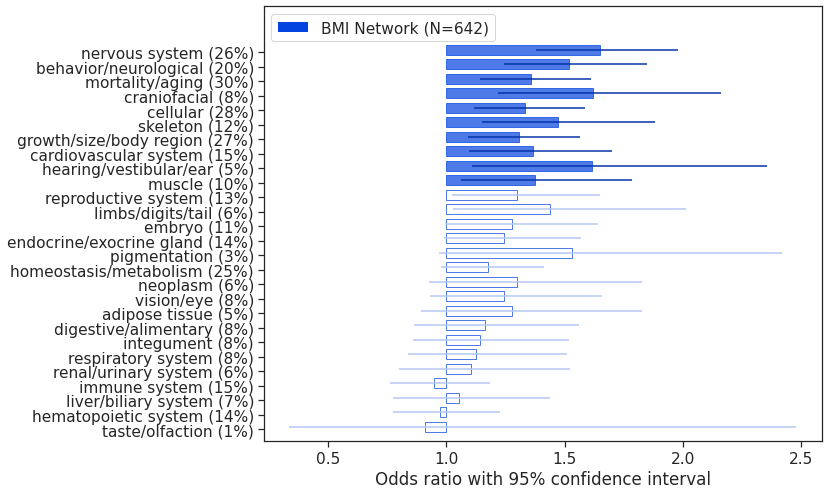

In [54]:
#a = plot_CIs(results_old, "MP:0000001", plot_by="OR_p", ascending=False)
top_level = [node for node in nx.dfs_preorder_nodes(mp_graph, "MP:0000001", 1) if node not in ["MP:0000001", "MP:0003012", "MP:0002873"]]
a = plot_hbar_comparison(results_old, communities=["C877"], mps=top_level, vert=8,
                         sig_level=0.05, community_names=["BMI Network"], sort_by_q=True, label_number="percent_community")


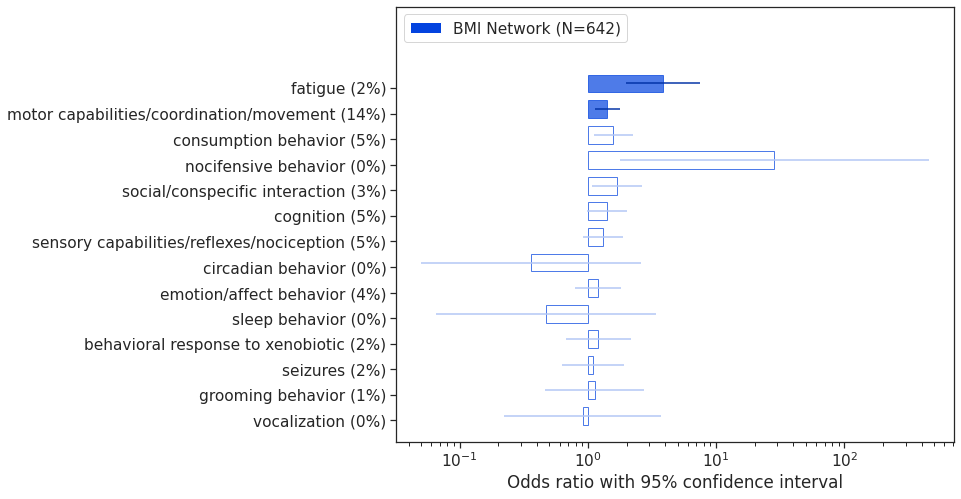

In [55]:
a = plot_hbar_comparison(results_old, communities=["C877"], mps="MP:0004924", mp_graph=mp_graph, vert = 8,
                         sig_level=0.05, community_names=["BMI Network"], sort_by_q=True, label_number="percent_community")

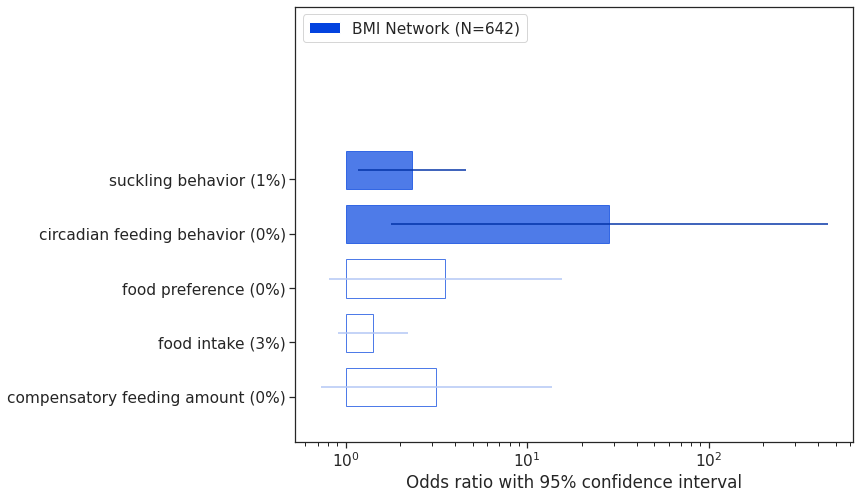

In [56]:
a = plot_hbar_comparison(results_old, communities=["C877"], mps="MP:0001431", mp_graph=mp_graph, vert = 8,
                         sig_level=0.05, community_names=["BMI Network"], sort_by_q=True, label_number="percent_community")

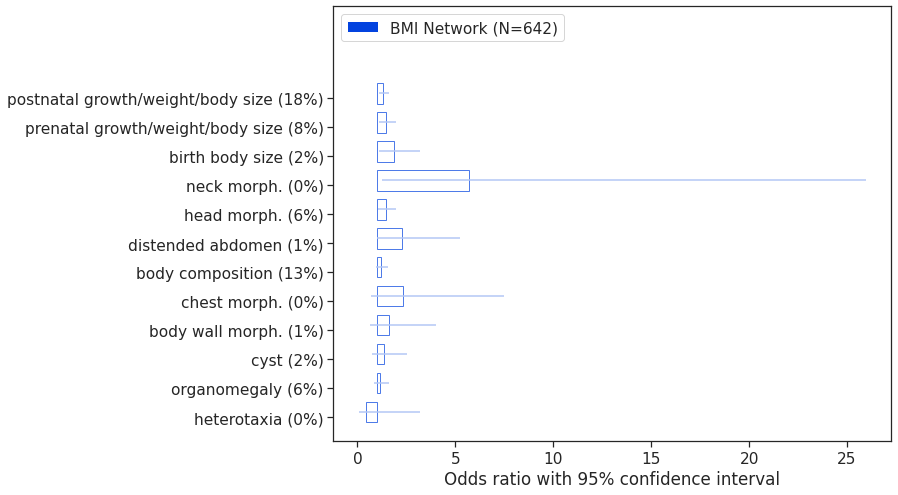

In [57]:

a = plot_hbar_comparison(results_old, communities=["C877"], mps="MP:0005378", mp_graph=mp_graph, vert = 8,
                         sig_level=0.05, community_names=["BMI Network"], sort_by_q=True, label_number="percent_community")

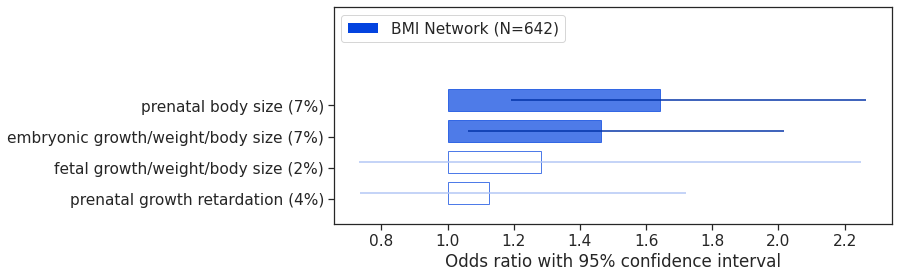

In [58]:

a = plot_hbar_comparison(results_old, communities=["C877"], mps="MP:0004196", mp_graph=mp_graph, vert = 4,
                         sig_level=0.05, community_names=["BMI Network"], sort_by_q=True, label_number="percent_community")

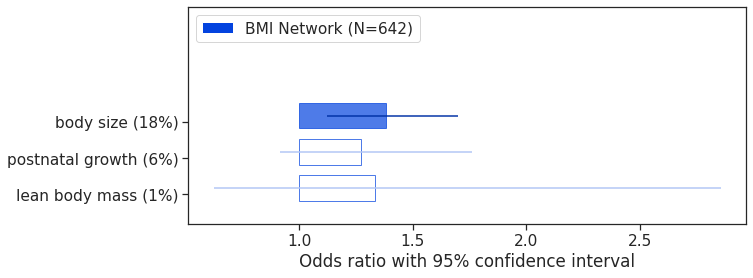

In [59]:
a = plot_hbar_comparison(results_old, communities=["C877"], mps="MP:0002089", mp_graph=mp_graph, vert = 4,
                         sig_level=0.05, community_names=["BMI Network"], sort_by_q=True, label_number="percent_community")

## Community choice

#### How do we justify choice of communities?
Volcano plot below can give us a shortlist. We could exclude based on:  
* Size of community
* Grouping of closely related communities
* Communities that do not have names after GO annotation
* Communities that do not have any high level enrichments

Either way I think we might have to include C894, though it does have a high proportion of seed genes. Either we can say something interesting about the novel genes or not. But even if not we could use it as a kind of validation of known biology to lead with?


In [60]:
body_size_traits = ["MP:0005378", "MP:0003956", "MP:0010866", "MP:0005451"]

In [61]:
a = results_old.loc[body_size_traits[3]].sort_values(by="OR_CI_lower", ascending=False)
a = a[a.name != "C877"]
a["q"] = fdrcorrection(list(a.OR_p.values), method="poscorr")[1]
a["-log10p"] = -1 * np.log10(a.OR_p.values)


Text(0, 0.5, '-10logp')

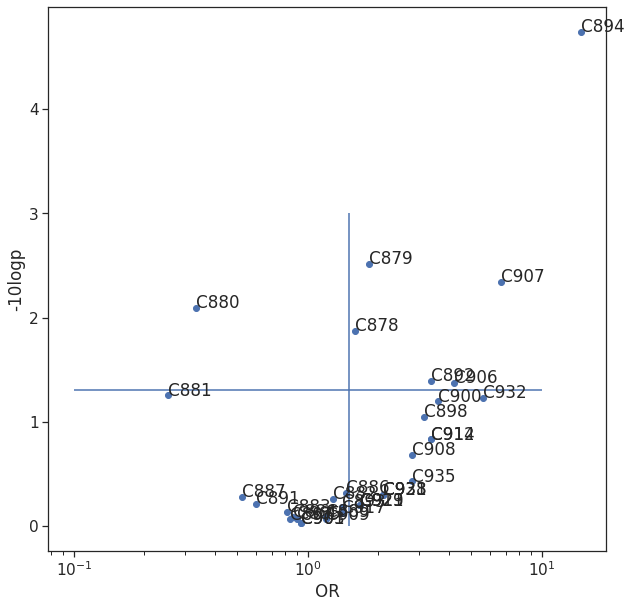

In [62]:

fig, ax = plt.subplots(figsize=(10,10))
plt.scatter(data=a, x="OR", y="-log10p")

for i, txt in enumerate(a.name):
    ax.annotate(txt, (a.OR[i], a["-log10p"][i]))
plt.xscale("log")
plt.hlines(1.3, 0.1, 10)
plt.vlines(1.5, 0, 3)
plt.xlabel("OR")
plt.ylabel("-10logp")

### C879 - neurotransmitter

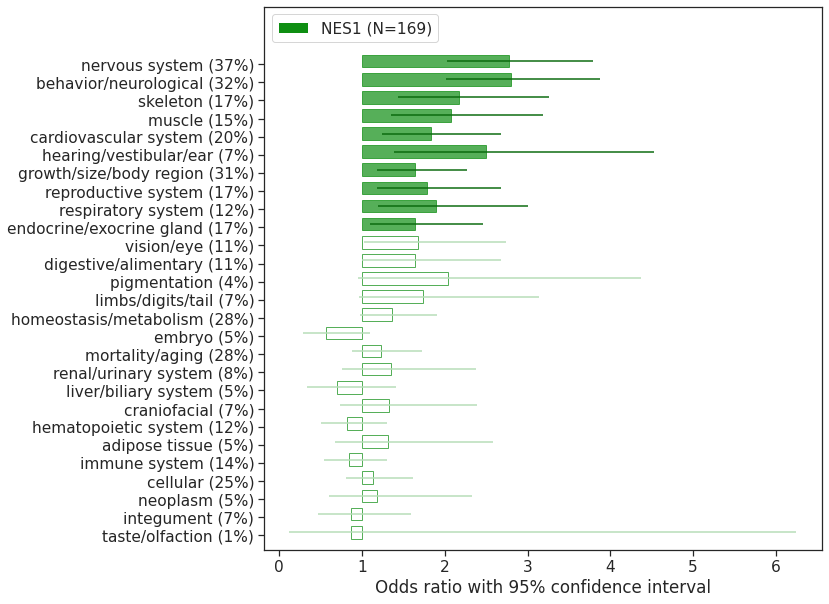

In [63]:
a = plot_hbar_comparison(results_old, communities=["C879"], mps=top_level, color_idx=0, vert = 10, 
                         sig_level=0.05, community_names=["NES1"], sort_by_q=True, label_number="percent_community")

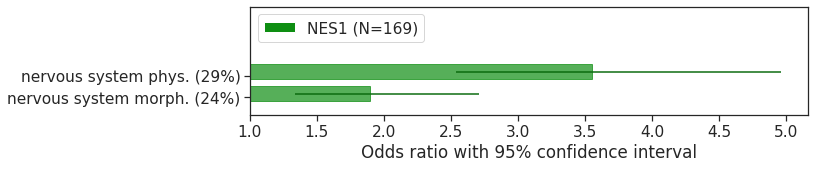

In [64]:

ns = plot_hbar_comparison(results_old, communities=["C879"], mps="MP:0003631", color_idx=0, vert = 2, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["NES1"], sort_by_q=True, label_number="percent_community")

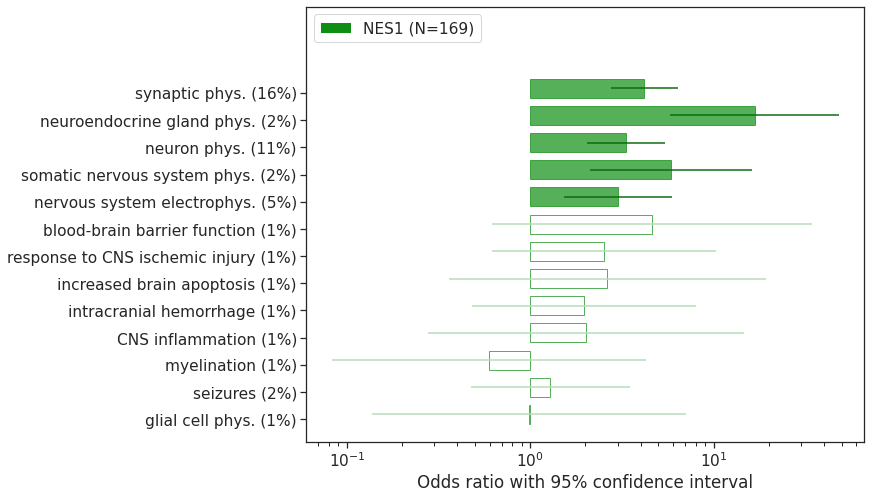

In [65]:

ns = plot_hbar_comparison(results_old, communities=["C879"], mps="MP:0003633", color_idx=0, vert = 8, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["NES1"], sort_by_q=True, label_number="percent_community")

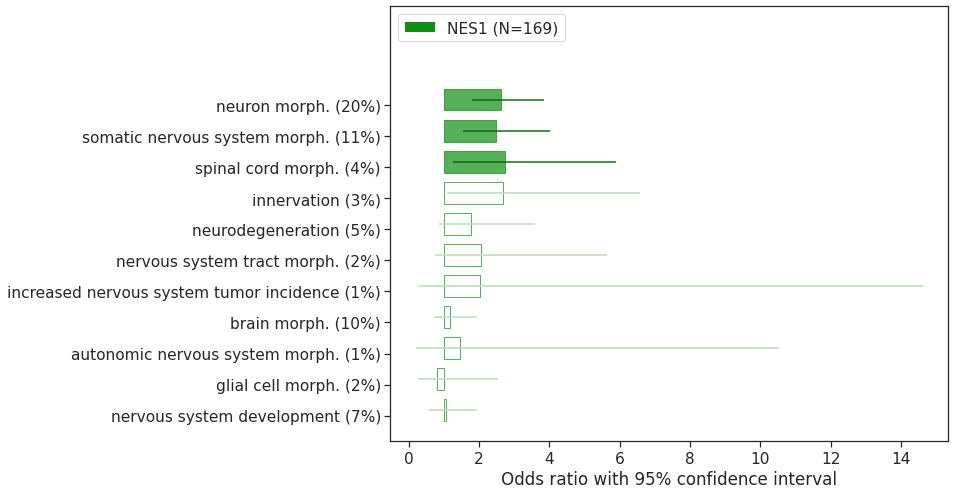

In [66]:
ns = plot_hbar_comparison(results_old, communities=["C879"], mps="MP:0003632", color_idx=0, vert = 8, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["NES1"], sort_by_q=True, label_number="percent_community")

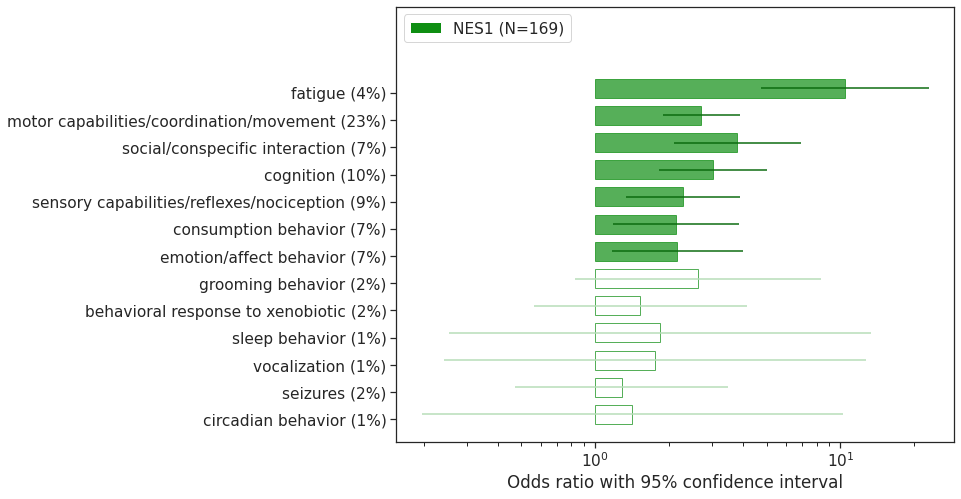

In [67]:
bh = plot_hbar_comparison(results_old, communities=["C879"], mps="MP:0004924", color_idx=0, vert = 8, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["NES1"], sort_by_q=True, label_number="percent_community")

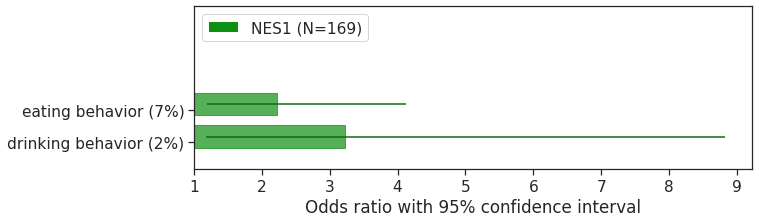

In [68]:

bh = plot_hbar_comparison(results_old, communities=["C879"], mps="MP:0002069", color_idx=0, vert = 3, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["NES1"], sort_by_q=True, label_number="percent_community")

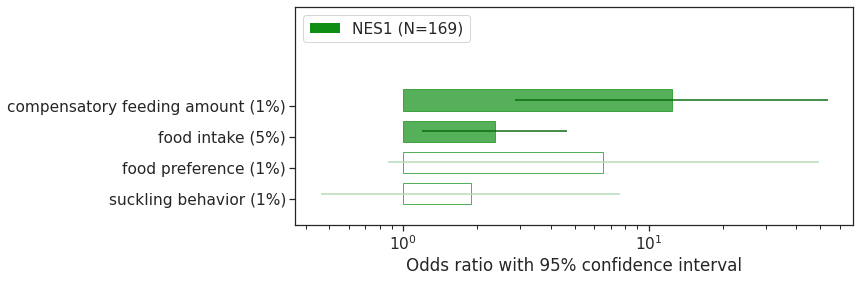

In [69]:

bh = plot_hbar_comparison(results_old, communities=["C879"], mps="MP:0001431", color_idx=0, vert = 4, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["NES1"], sort_by_q=True, label_number="percent_community")

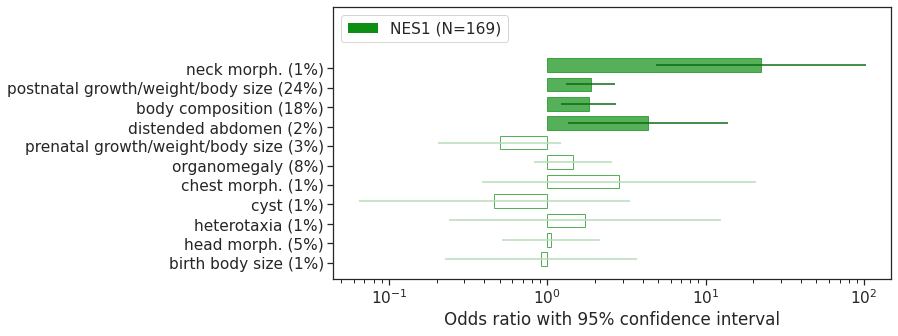

In [70]:

gs = plot_hbar_comparison(results_old, communities=["C879"], mps="MP:0005378", color_idx=0, vert = 5, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["NES1"], sort_by_q=True, label_number="percent_community")

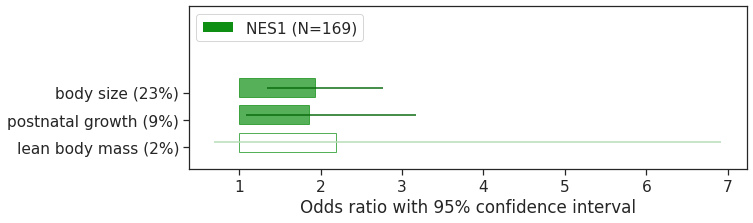

In [71]:

gs = plot_hbar_comparison(results_old, communities=["C879"], mps="MP:0002089", color_idx=0, vert = 3, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["NES1"], sort_by_q=True, label_number="percent_community")

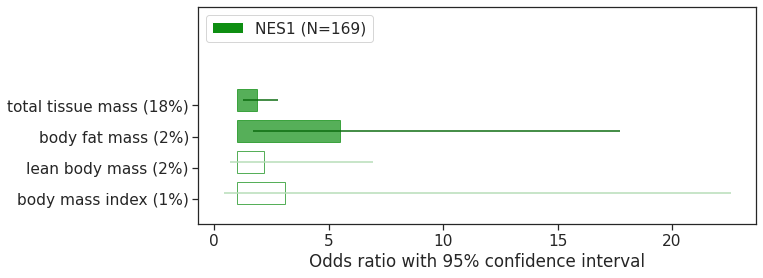

In [72]:

bc = plot_hbar_comparison(results_old, communities=["C879"], mps="MP:0005451", color_idx=0, vert = 4, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["NES1"], sort_by_q=True, label_number="percent_community")

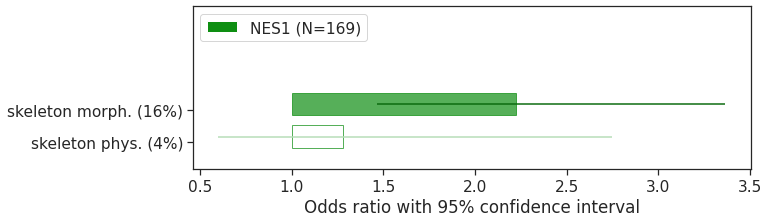

In [73]:

sk = plot_hbar_comparison(results_old, communities=["C879"], mps="MP:0005390", color_idx=0, vert = 3, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["NES1"], sort_by_q=True, label_number="percent_community")

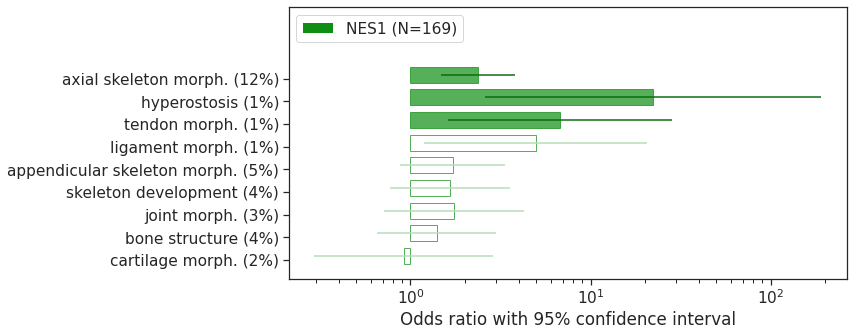

In [74]:

sk = plot_hbar_comparison(results_old, communities=["C879"], mps="MP:0005508", color_idx=0, vert = 5, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["NES1"], sort_by_q=True, label_number="percent_community")

### C879 - C907 - C894

In [75]:
C879_genes = set(hier_df_genes.loc["C879", "CD_MemberList"].split(" "))
C894_genes = set(hier_df_genes.loc["C894", "CD_MemberList"].split(" "))
C907_genes = set(hier_df_genes.loc["C907", "CD_MemberList"].split(" "))
C879_subset = C879_genes - C894_genes - C907_genes
hier_subset = pd.DataFrame({"CD_MemberList": " ".join(C879_subset)}, index =["C879_subset"])

In [76]:
[(gene, len(gene_mapping[gene])) for gene in C894_genes if gene in gene_mapping]

[('ADORA2B', 28),
 ('VIPR1', 15),
 ('MC4R', 45),
 ('NPFFR1', 8),
 ('POMC', 62),
 ('POU1F1', 41),
 ('GNAO1', 49),
 ('PRLHR', 21),
 ('BDNF', 111),
 ('GNAI2', 75)]

In [77]:
[print(gene) for gene in C907_genes]

VGLL2
DMD
MYF5
MYOZ2
CASQ2
PDLIM3
MYH2
AKAP6
MYH4


[None, None, None, None, None, None, None, None, None]

In [78]:
subset_results = community_term_enrichment_old("C879_subset", hier_subset, MPO2, mgi_df, term_counts, gene_mapping)

In [79]:
subset_results["name"] = "C879_subset"
subset_results.head()

observed  total        OR          OR_p  OR_CI_lower  OR_CI_upper  \
MP:0000001        98   9143  2.044999  3.650812e-05     1.456116     2.872039   
MP:0003631        54   3309  2.692098  7.740830e-09     1.923527     3.767763   
MP:0004924        44   2739  2.484121  4.827705e-07     1.742949     3.540468   
MP:0005386        44   2739  2.484121  4.827705e-07     1.742949     3.540468   
MP:0003633        40   1901  3.314781  1.303885e-10     2.300017     4.777257   

                 hyper_p  sig_5e6                         description  size  \
MP:0000001  7.574404e-06    False                 mammalian phenotype   149   
MP:0003631  1.408830e-08     True            nervous system phenotype   149   
MP:0004924  7.518343e-07     True                   abnormal behavior   149   
MP:0005386  7.518343e-07     True     behavior/neurological phenotype   149   
MP:0003633  1.512620e-09     True  abnormal nervous system physiology   149   

                   name  
MP:0000001  C879_subset  
MP:0003631  C879_subset  
MP:0004924  C879_subset  
MP:0005386  C879_subset  
MP:0003633  C879_subset

In [80]:
results_old2 = pd.concat([results_old, subset_results])

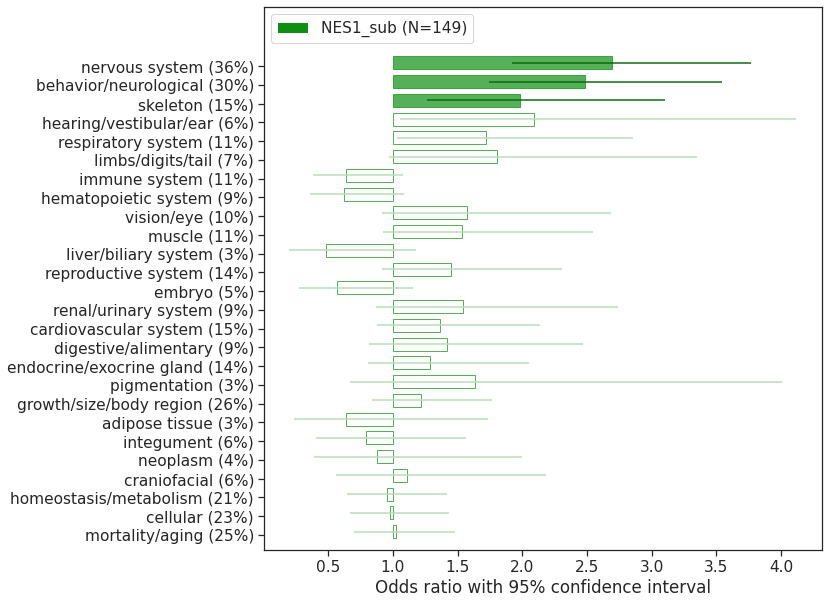

In [81]:
a = plot_hbar_comparison(results_old2, communities=["C879_subset"], mps=top_level, color_idx=0, vert = 10,
                         sig_level=0.05, community_names=["NES1_sub"], sort_by_q=True, label_number="percent_community")

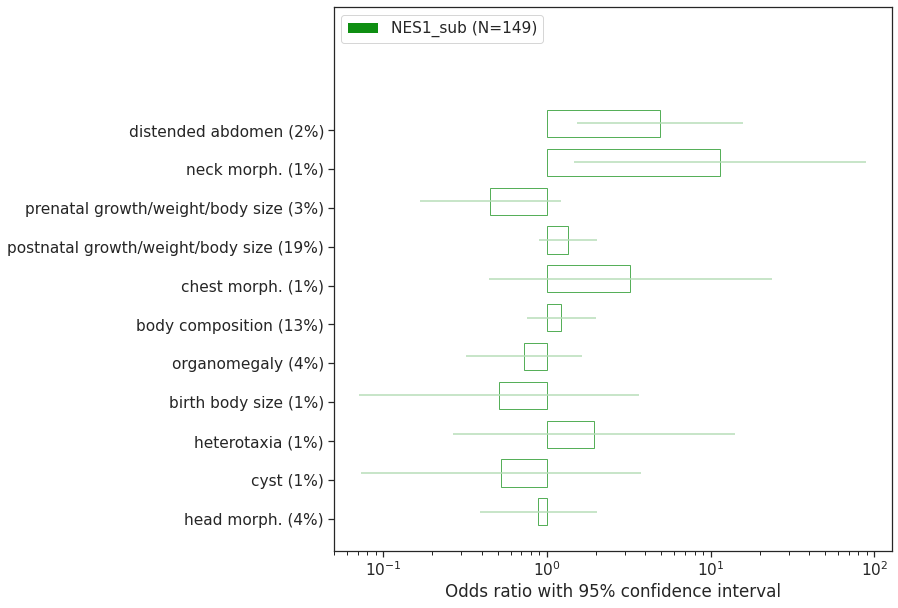

In [82]:
a = plot_hbar_comparison(results_old2, communities=["C879_subset"], mps="MP:0005378", color_idx=0, vert = 10,mp_graph=mp_graph,
                         sig_level=0.05, community_names=["NES1_sub"], sort_by_q=True, label_number="percent_community")

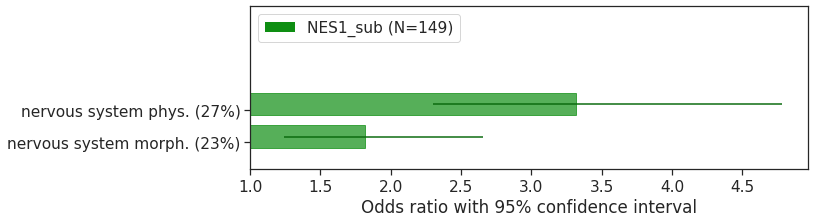

In [83]:
a = plot_hbar_comparison(results_old2, communities=["C879_subset"], mps="MP:0003631", color_idx=0, vert = 3,mp_graph=mp_graph,
                         sig_level=0.05, community_names=["NES1_sub"], sort_by_q=True, label_number="percent_community")

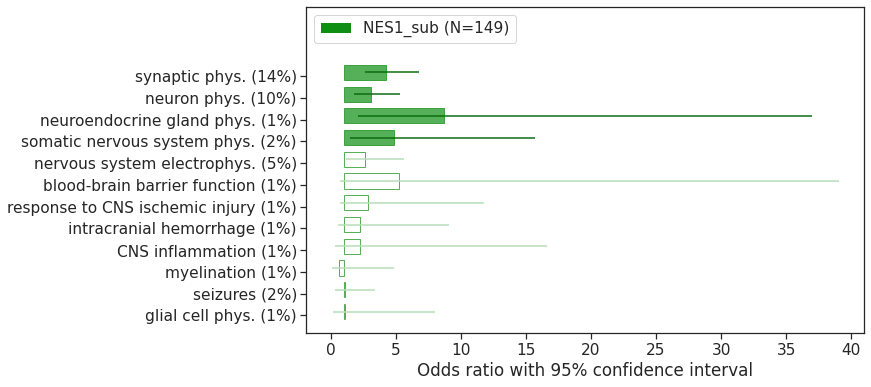

In [84]:
a = plot_hbar_comparison(results_old2, communities=["C879_subset"], mps="MP:0003633", color_idx=0, vert = 6,mp_graph=mp_graph,
                         sig_level=0.05, community_names=["NES1_sub"], sort_by_q=True, label_number="percent_community")

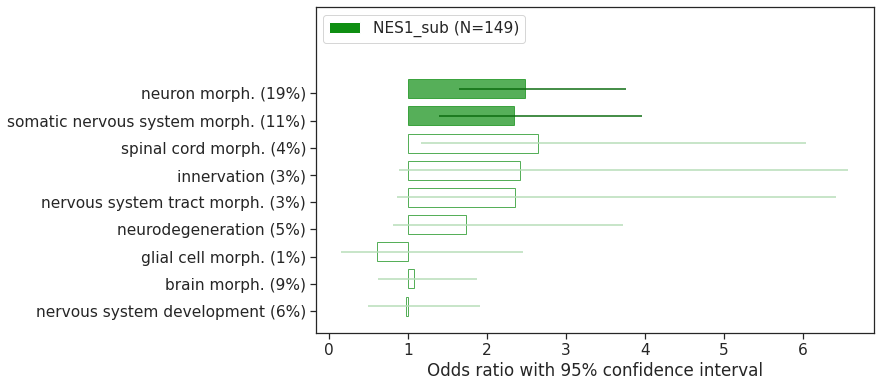

In [85]:
a = plot_hbar_comparison(results_old2, communities=["C879_subset"], mps="MP:0003632", color_idx=0, vert = 6,mp_graph=mp_graph,
                         sig_level=0.05, community_names=["NES1_sub"], sort_by_q=True, label_number="percent_community")

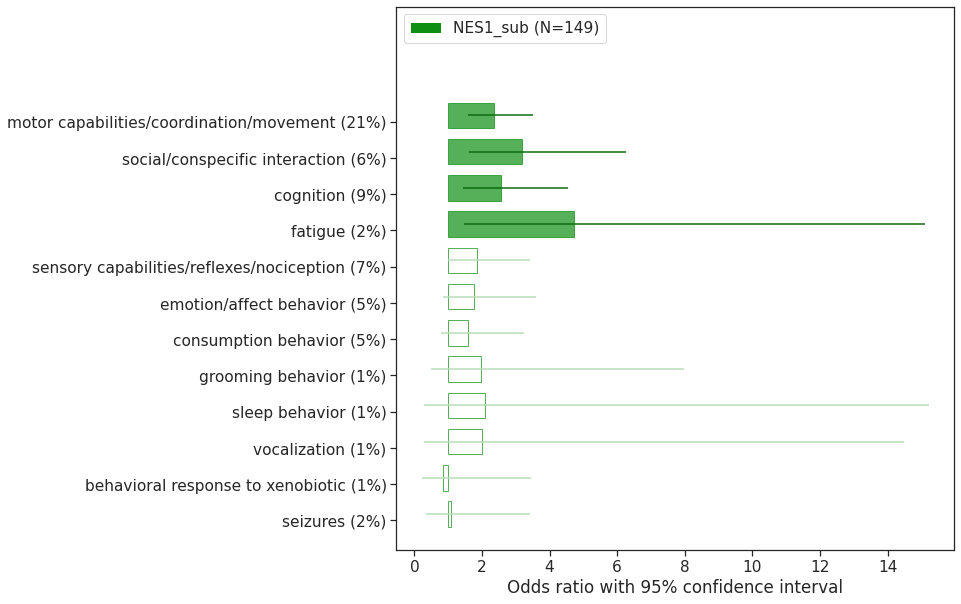

In [86]:
a = plot_hbar_comparison(results_old2, communities=["C879_subset"], mps="MP:0004924", color_idx=0, vert = 10,mp_graph=mp_graph,
                         sig_level=0.05, community_names=["NES1_sub"], sort_by_q=True, label_number="percent_community")

### C907 - calcium ion, muscle

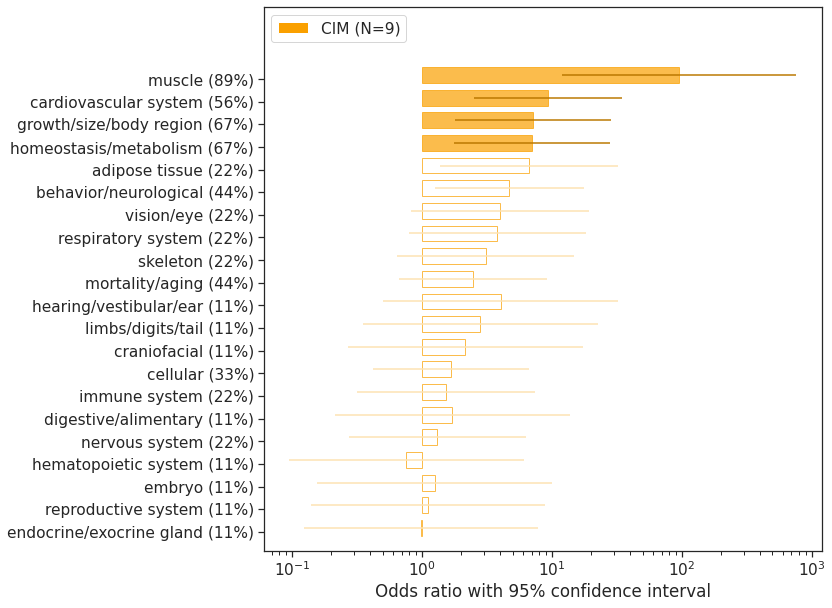

In [87]:
a = plot_hbar_comparison(results_old, communities=["C907"], mps=top_level, color_idx=2, vert = 10,
                         sig_level=0.05, community_names=["CIM"], sort_by_q=True, label_number="percent_community")

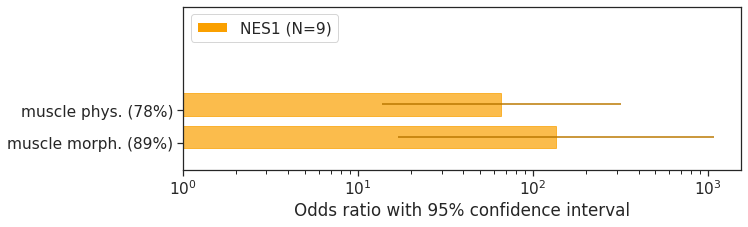

In [88]:

ms = plot_hbar_comparison(results_old, communities=["C907"], mps="MP:0005369", color_idx=2, vert = 3, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["NES1"], sort_by_q=True, label_number="percent_community")

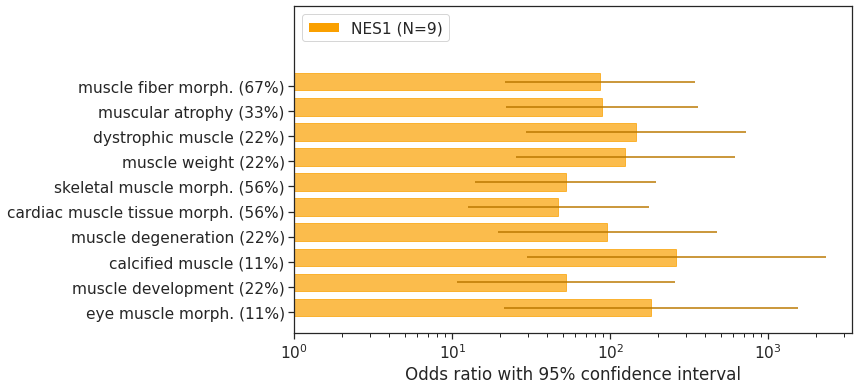

In [89]:

ms = plot_hbar_comparison(results_old, communities=["C907"], mps="MP:0002108", color_idx=2, vert = 6, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["NES1"], sort_by_q=True, label_number="percent_community")

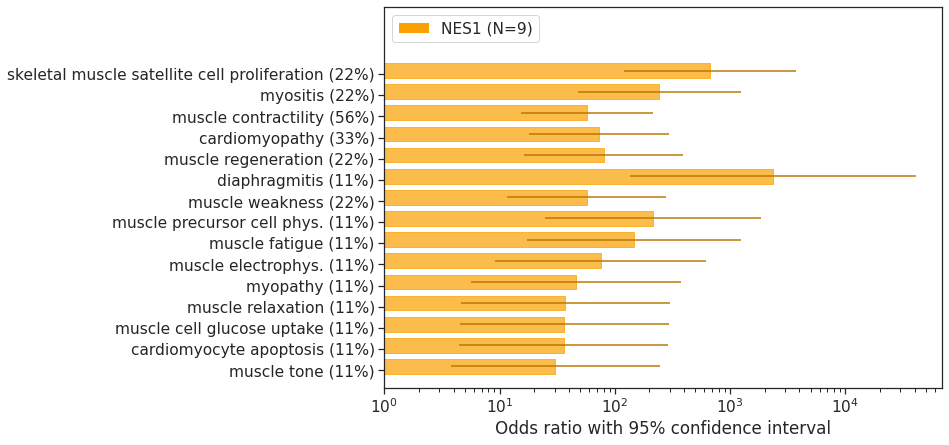

In [90]:

ms = plot_hbar_comparison(results_old, communities=["C907"], mps="MP:0002106", color_idx=2, vert = 7, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["NES1"], sort_by_q=True, label_number="percent_community")

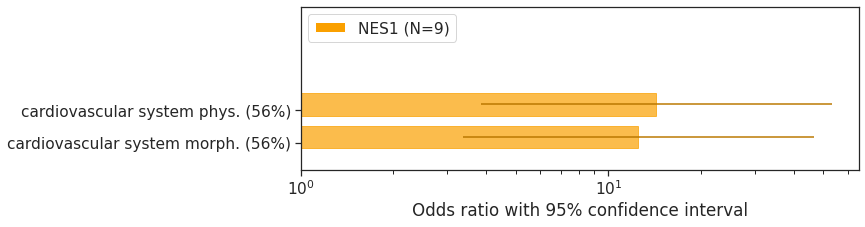

In [91]:

cd = plot_hbar_comparison(results_old, communities=["C907"], mps="MP:0005385", color_idx=2, vert = 3, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["NES1"], sort_by_q=True, label_number="percent_community")

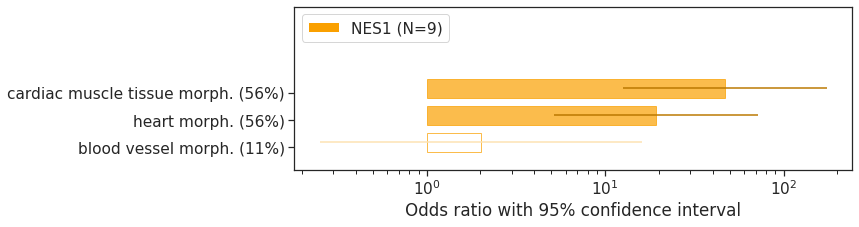

In [92]:

cd = plot_hbar_comparison(results_old, communities=["C907"], mps="MP:0002127", color_idx=2, vert = 3, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["NES1"], sort_by_q=True, label_number="percent_community")

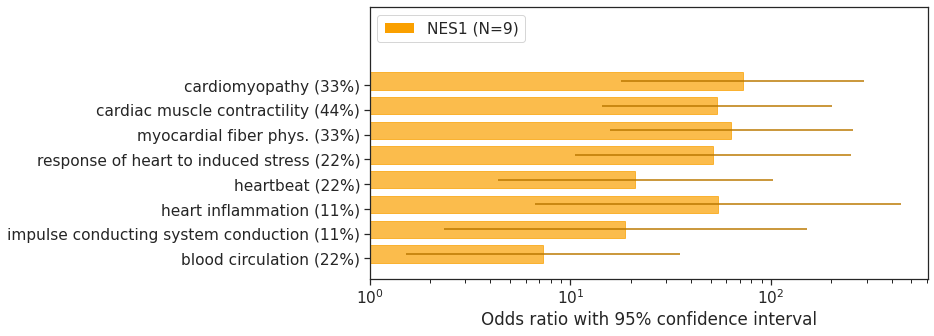

In [93]:

cd = plot_hbar_comparison(results_old, communities=["C907"], mps="MP:0001544", color_idx=2, vert = 5, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["NES1"], sort_by_q=True, label_number="percent_community")

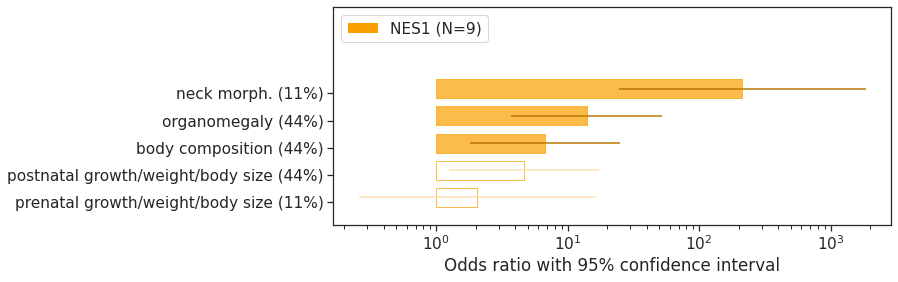

In [94]:

cd = plot_hbar_comparison(results_old, communities=["C907"], mps="MP:0005378", color_idx=2, vert = 4, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["NES1"], sort_by_q=True, label_number="percent_community")

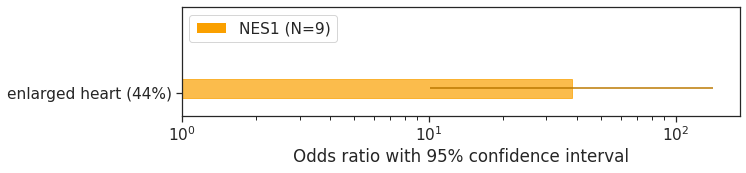

In [95]:

cd = plot_hbar_comparison(results_old, communities=["C907"], mps="MP:0031094", color_idx=2, vert = 2, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["NES1"], sort_by_q=True, label_number="percent_community")

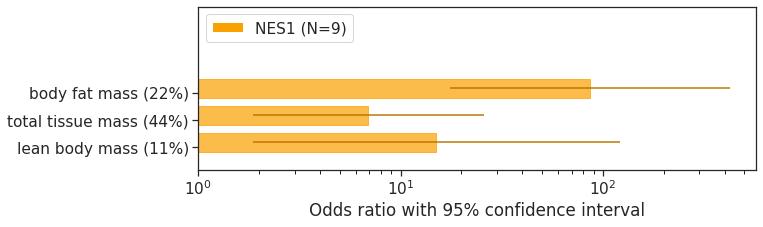

In [96]:

ms = plot_hbar_comparison(results_old, communities=["C907"], mps="MP:0005451", color_idx=2, vert = 3, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["NES1"], sort_by_q=True, label_number="percent_community")

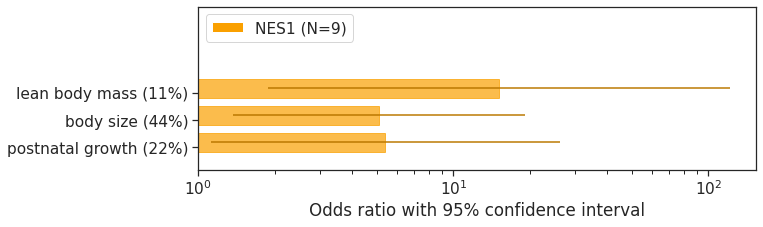

In [97]:

ms = plot_hbar_comparison(results_old, communities=["C907"], mps="MP:0002089", color_idx=2, vert = 3, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["NES1"], sort_by_q=True, label_number="percent_community")

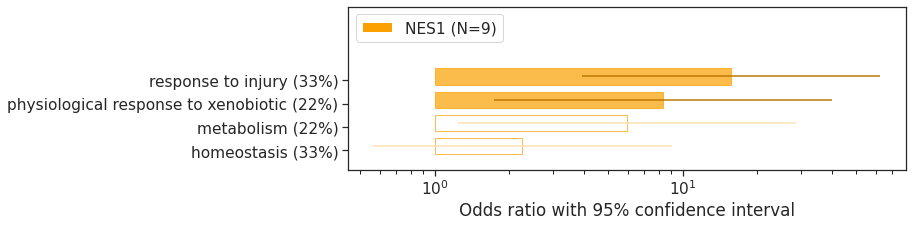

In [98]:

ms = plot_hbar_comparison(results_old, communities=["C907"], mps="MP:0005376", color_idx=2, vert = 3, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["NES1"], sort_by_q=True, label_number="percent_community")

### C882 -demethylation

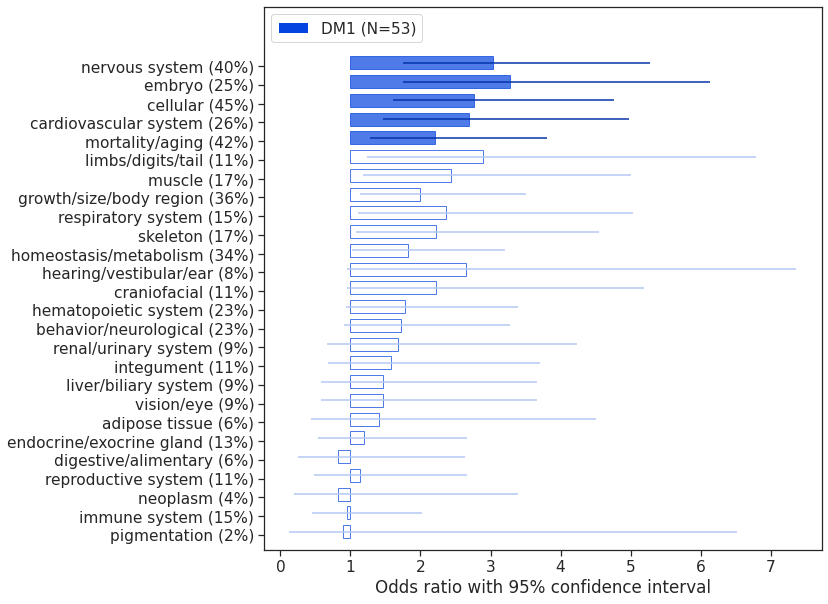

In [99]:
a = plot_hbar_comparison(results_old, communities=["C882"], mps=top_level, color_idx=1, vert=10,
                         sig_level=0.05, community_names=["DM1"], sort_by_q=True, label_number="percent_community")

PARENT: MP:0005376 homeostasis/metabolism phenotype


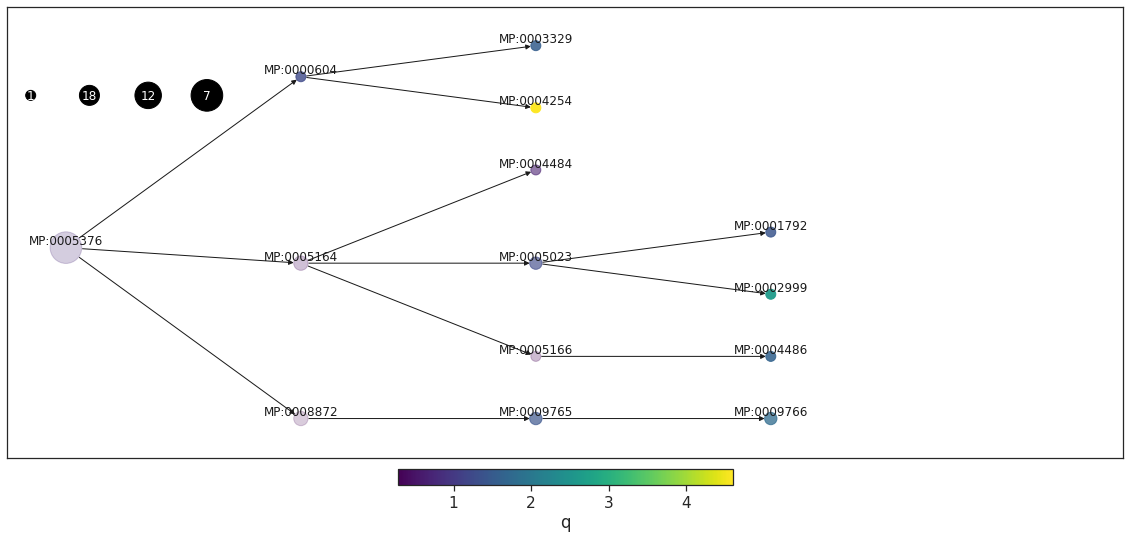

In [170]:
n = draw_significance_hierarchy(results_old.loc[results_old.observed > 0], "C882", "MP:0005376", mp_graph, MPO2, hier_df_genes, term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=10, label="all", descriptive_labels=True)

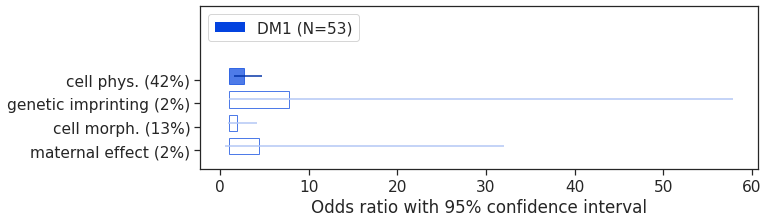

In [100]:
a = plot_hbar_comparison(results_old, communities=["C882"], mps="MP:0005384", color_idx=1, vert=3, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["DM1"], sort_by_q=True, label_number="percent_community")

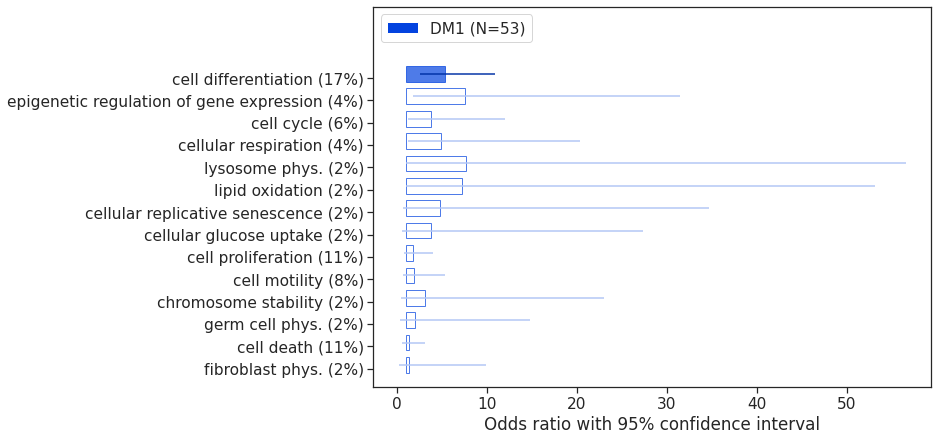

In [101]:

a = plot_hbar_comparison(results_old, communities=["C882"], mps="MP:0005621", color_idx=1, vert=7, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["DM1"], sort_by_q=True, label_number="percent_community")

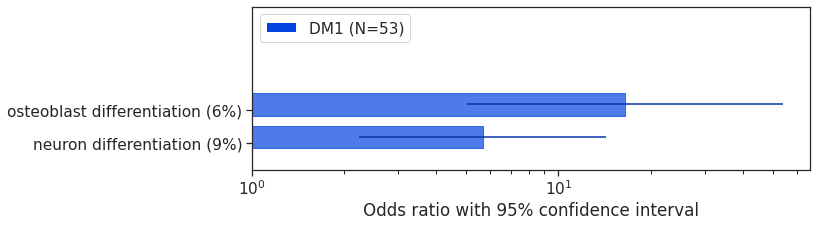

In [102]:

a = plot_hbar_comparison(results_old, communities=["C882"], mps="MP:0005076", color_idx=1, vert=3, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["DM1"], sort_by_q=True, label_number="percent_community")

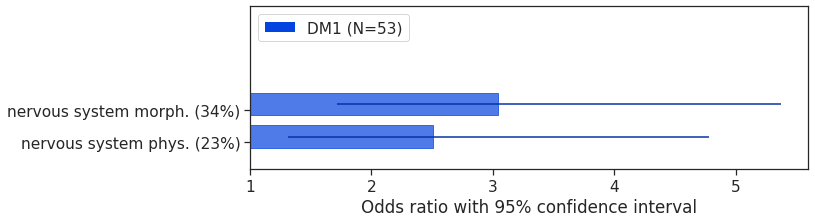

In [103]:

a = plot_hbar_comparison(results_old, communities=["C882"], mps="MP:0003631", color_idx=1, vert=3, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["DM1"], sort_by_q=True, label_number="percent_community")

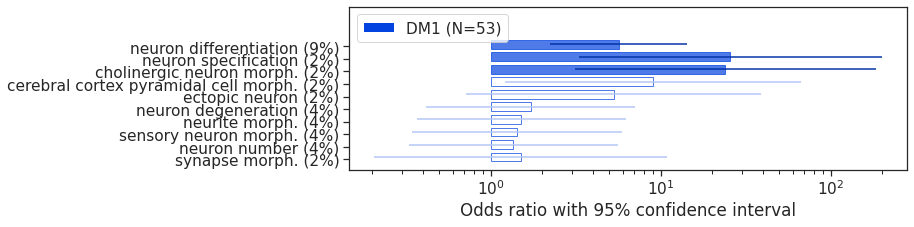

In [104]:

a = plot_hbar_comparison(results_old, communities=["C882"], mps="MP:0002882", color_idx=1, vert=3, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["DM1"], sort_by_q=True, label_number="percent_community")

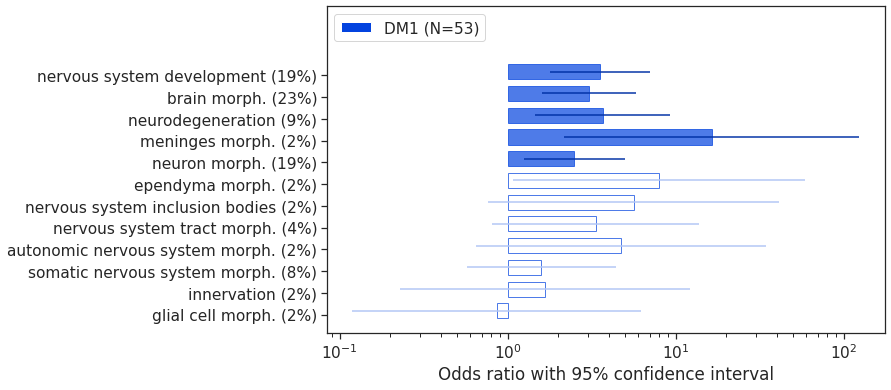

In [105]:

a = plot_hbar_comparison(results_old, communities=["C882"], mps="MP:0003632", color_idx=1, vert=6, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["DM1"], sort_by_q=True, label_number="percent_community")

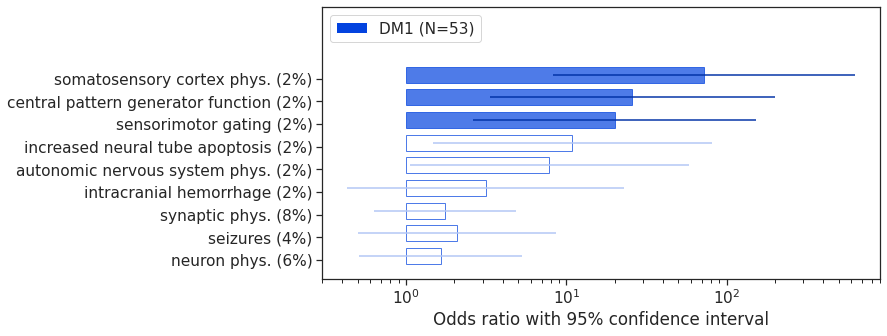

In [106]:

a = plot_hbar_comparison(results_old, communities=["C882"], mps="MP:0003633", color_idx=1, vert=5, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["DM1"], sort_by_q=True, label_number="percent_community")

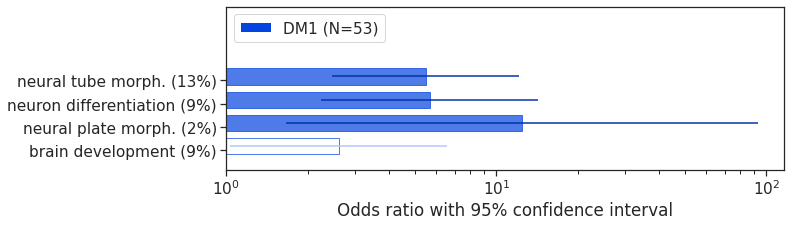

In [107]:

a = plot_hbar_comparison(results_old, communities=["C882"], mps="MP:0003861", color_idx=1, vert=3, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["DM1"], sort_by_q=True, label_number="percent_community")

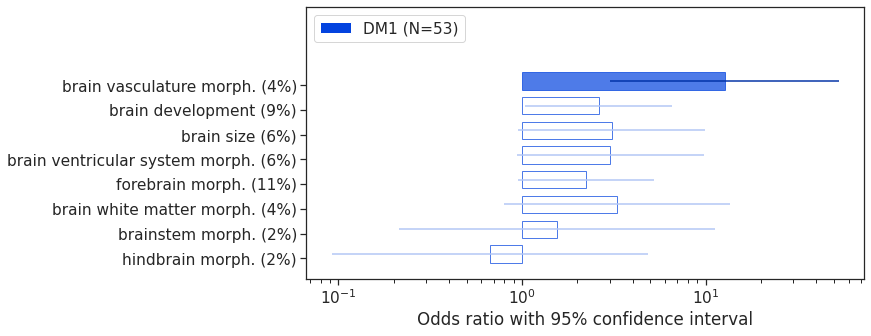

In [108]:

a = plot_hbar_comparison(results_old, communities=["C882"], mps="MP:0002152", color_idx=1, vert=5, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["DM1"], sort_by_q=True, label_number="percent_community")

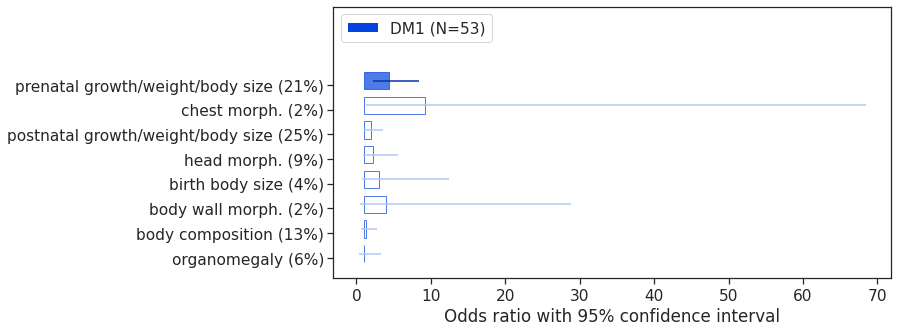

In [109]:

a = plot_hbar_comparison(results_old, communities=["C882"], mps="MP:0005378", color_idx=1, vert=5, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["DM1"], sort_by_q=True, label_number="percent_community")

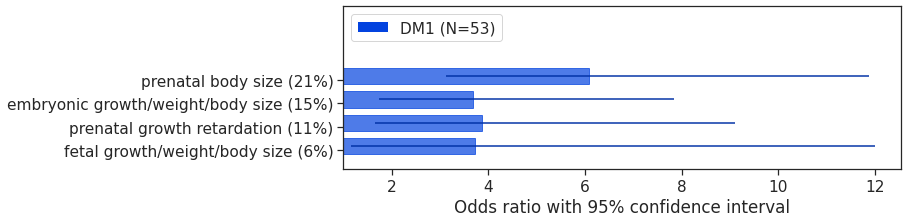

In [110]:

a = plot_hbar_comparison(results_old, communities=["C882"], mps="MP:0004196", color_idx=1, vert=3, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["DM1"], sort_by_q=True, label_number="percent_community")

PARENT: MP:0005378 growth/size/body region phenotype


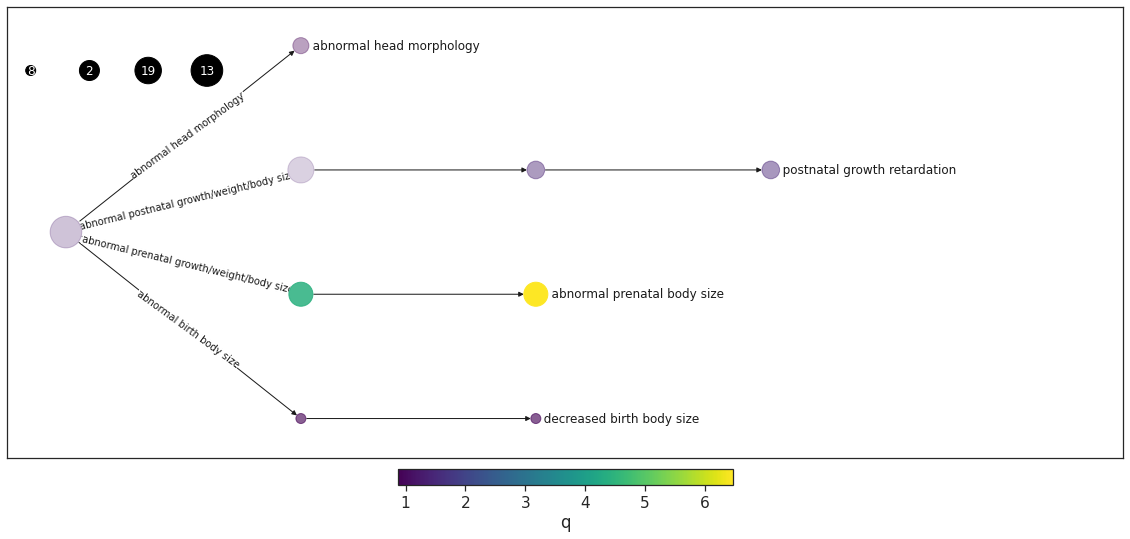

In [141]:
n = draw_significance_hierarchy(results_old.loc[results_old.observed > 1], "C882", "MP:0005378", mp_graph, MPO2, hier_df_genes, term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=10, label="leaf", descriptive_labels=True)

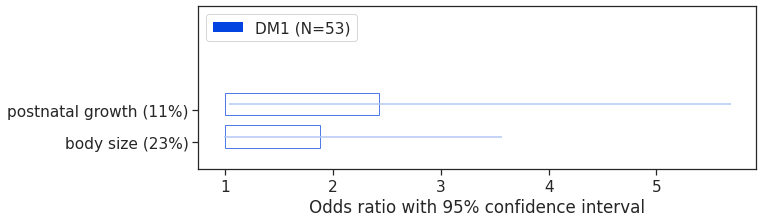

In [111]:

a = plot_hbar_comparison(results_old, communities=["C882"], mps="MP:0002089", color_idx=1, vert=3, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["DM1"], sort_by_q=True, label_number="percent_community")

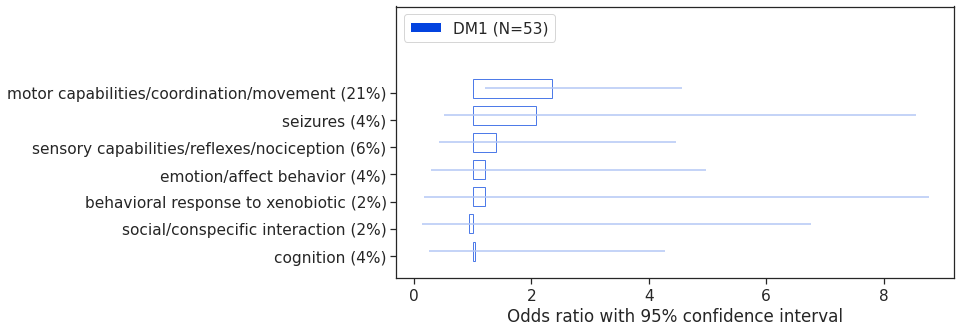

In [112]:

a = plot_hbar_comparison(results_old, communities=["C882"], mps="MP:0004924", color_idx=1, vert=5, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["DM1"], sort_by_q=True, label_number="percent_community")

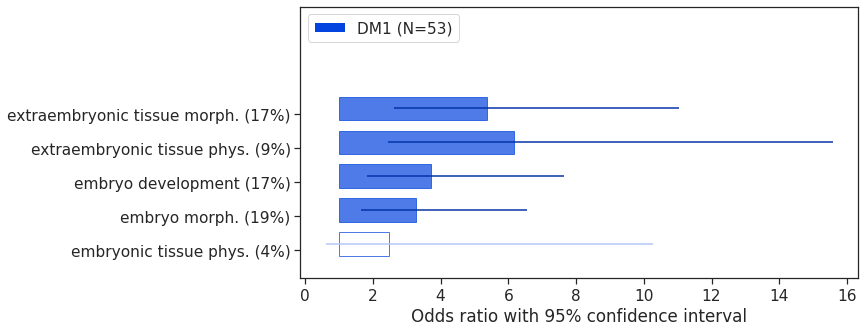

In [113]:

a = plot_hbar_comparison(results_old, communities=["C882"], mps="MP:0005380", color_idx=1, vert=5, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["DM1"], sort_by_q=True, label_number="percent_community")

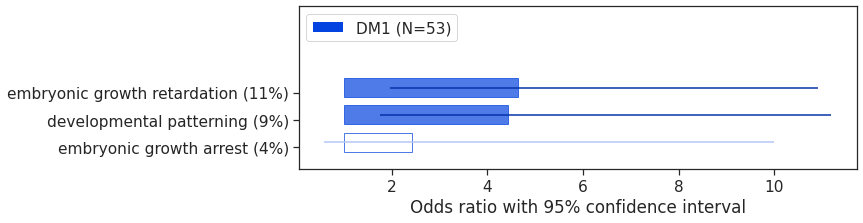

In [114]:

a = plot_hbar_comparison(results_old, communities=["C882"], mps="MP:0001672", color_idx=1, vert=3, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["DM1"], sort_by_q=True, label_number="percent_community")

### C889 - MAPK

In [140]:
for gene in hier_df_genes.loc["C889", "CD_MemberList"].split(" "):
    print(gene)

MAPK1
MAP2K5
DNAJC27
DAPK2
CAMK2G
MAP2K3
DAPK3
MAPK6
MAP2K6
CLHC1
CAMK4
TTBK2
MAP2K1
STK33
AC138811.2
NEK5


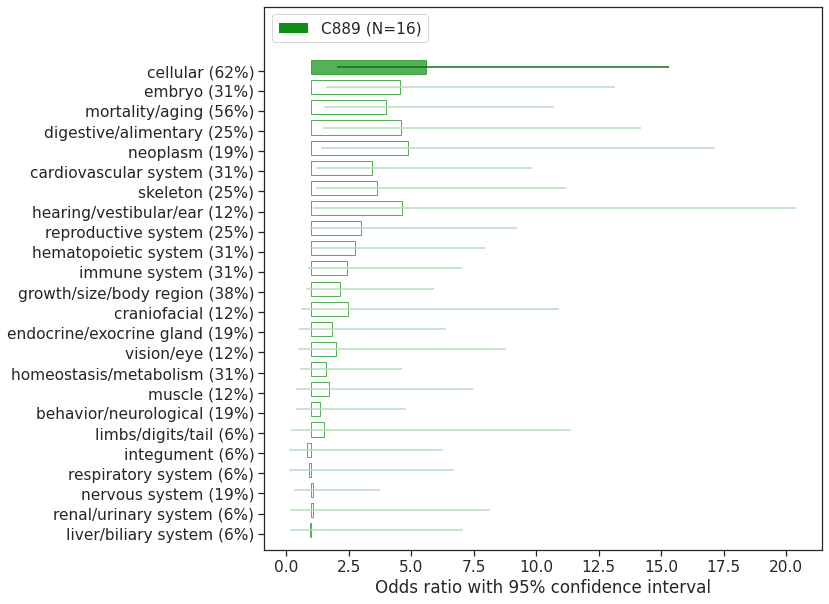

In [138]:
a = plot_hbar_comparison(results_old, communities=["C889"], mps=top_level, color_idx=0, vert=10,
                         sig_level=0.05, community_names=["C889"], sort_by_q=True, label_number="percent_community")

In [119]:
results_old = results_old.assign(MP = results_old.index)

PARENT: MP:0005378 growth/size/body region phenotype


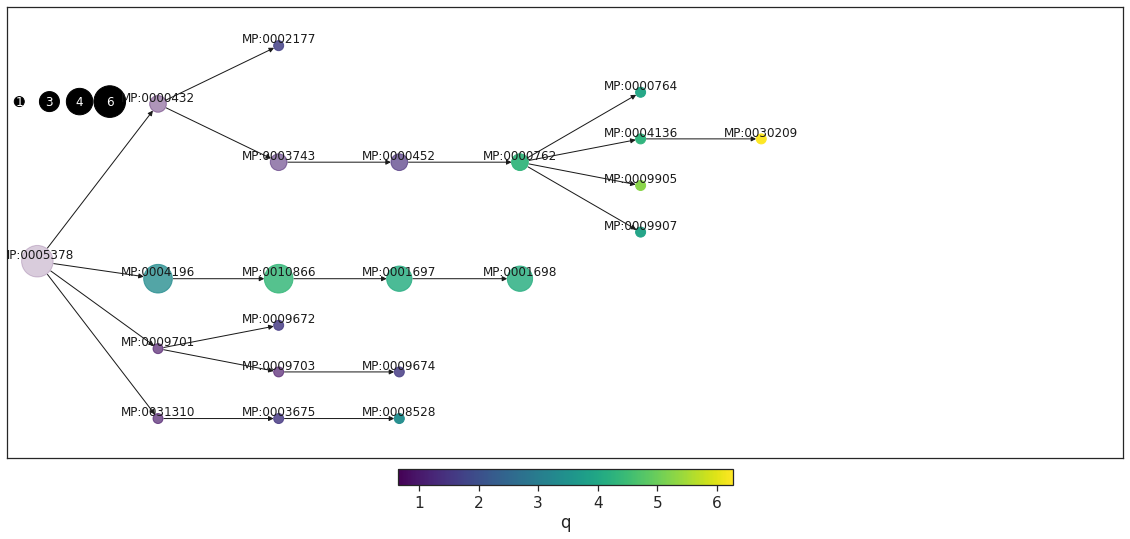

In [142]:
n = draw_significance_hierarchy(results_old.loc[results_old.observed > 0], "C889", "MP:0005378", mp_graph, MPO2, hier_df_genes, term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=10, label="all", descriptive_labels=True)

In [143]:
a = get_gene_hits("C889", hier_df_genes, term_mapping, "MP:0010866", MPO2, mp_graph)

In [148]:
a.loc[a.inMP == 1].gene.unique()

array(['MAPK1', 'MAP2K5', 'MAPK6', 'TTBK2', 'MAP2K1'], dtype=object)

PARENT: MP:0005380 embryo phenotype


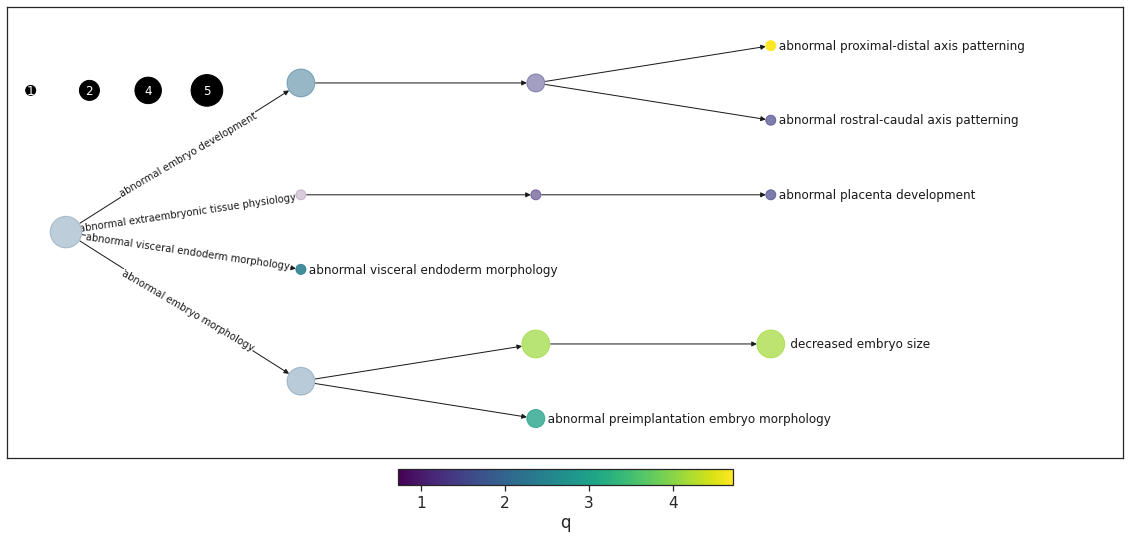

In [132]:
n = draw_significance_hierarchy(results_old.loc[results_old.observed > 0], "C889", "MP:0005380", mp_graph, MPO2, hier_df_genes, term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=10, label="leaf", descriptive_labels=True)

PARENT: MP:0005385 cardiovascular system phenotype


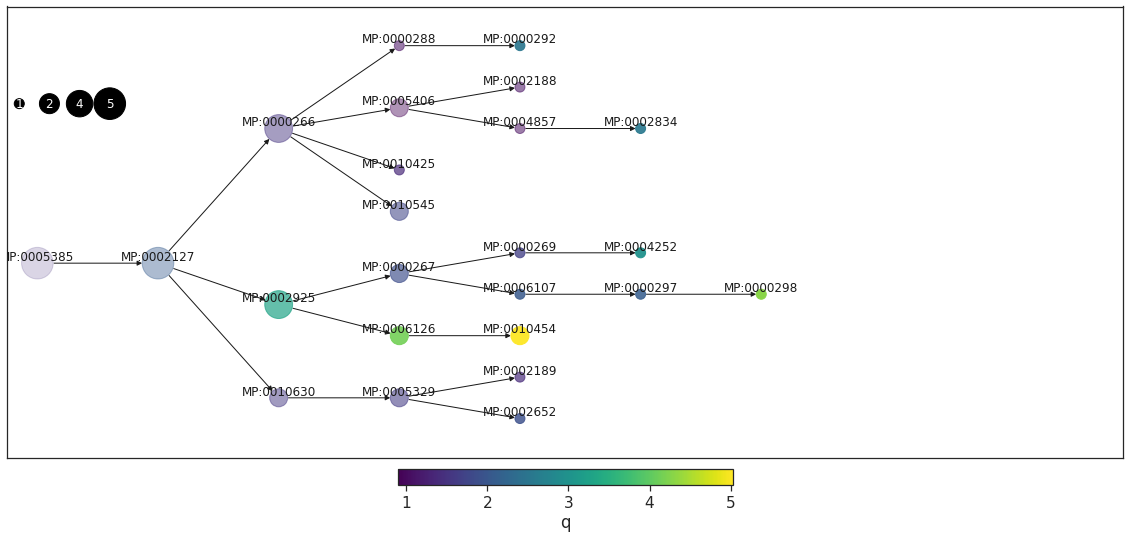

In [169]:
n = draw_significance_hierarchy(results_old.loc[results_old.observed > 0], "C889", "MP:0005385", mp_graph, MPO2, hier_df_genes, term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=10, label="all", descriptive_labels=True)

PARENT: MP:0005381 digestive/alimentary phenotype


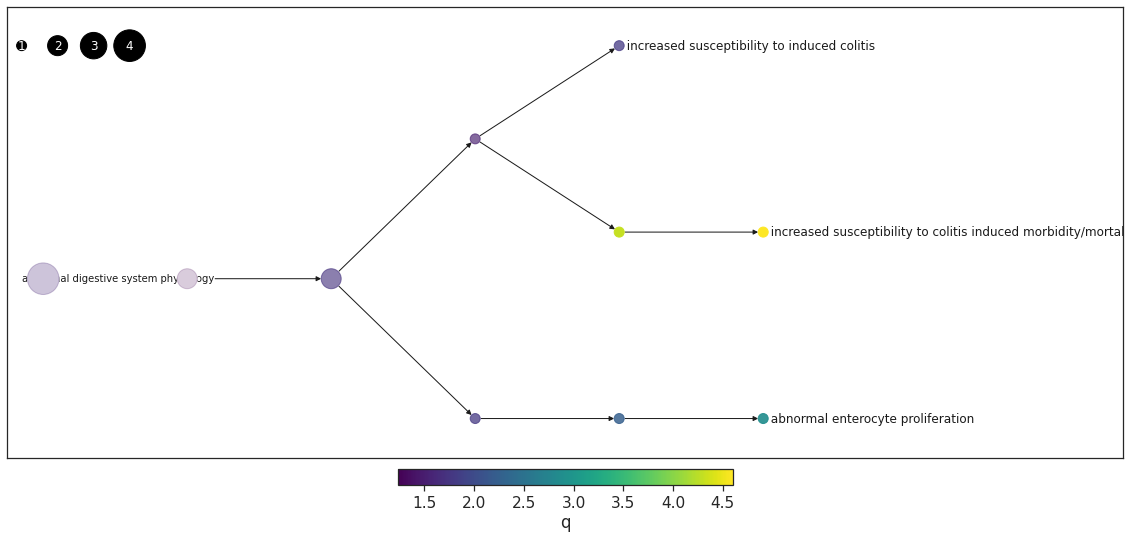

In [130]:
n = draw_significance_hierarchy(results_old.loc[results_old.observed > 0], "C889", "MP:0005381", mp_graph, MPO2, hier_df_genes, term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=10, label="leaf", descriptive_labels=True)

PARENT: MP:0005378 growth/size/body region phenotype


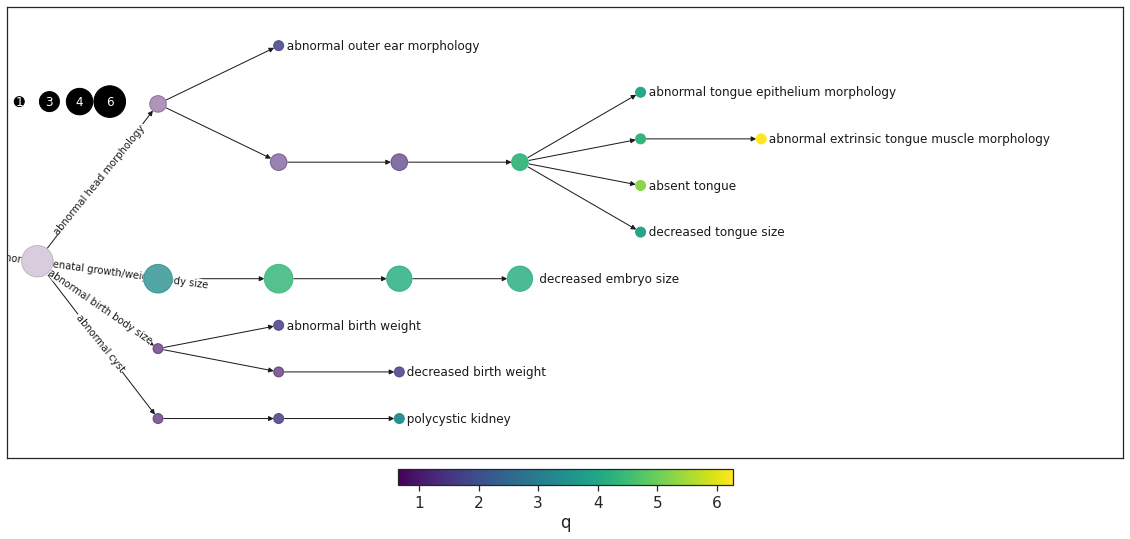

In [126]:
n = draw_significance_hierarchy(results_old.loc[results_old.observed > 0], "C889", "MP:0005378", mp_graph, MPO2, hier_df_genes, term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=10, label="leaf", descriptive_labels=True)

PARENT: MP:0005384 cellular phenotype


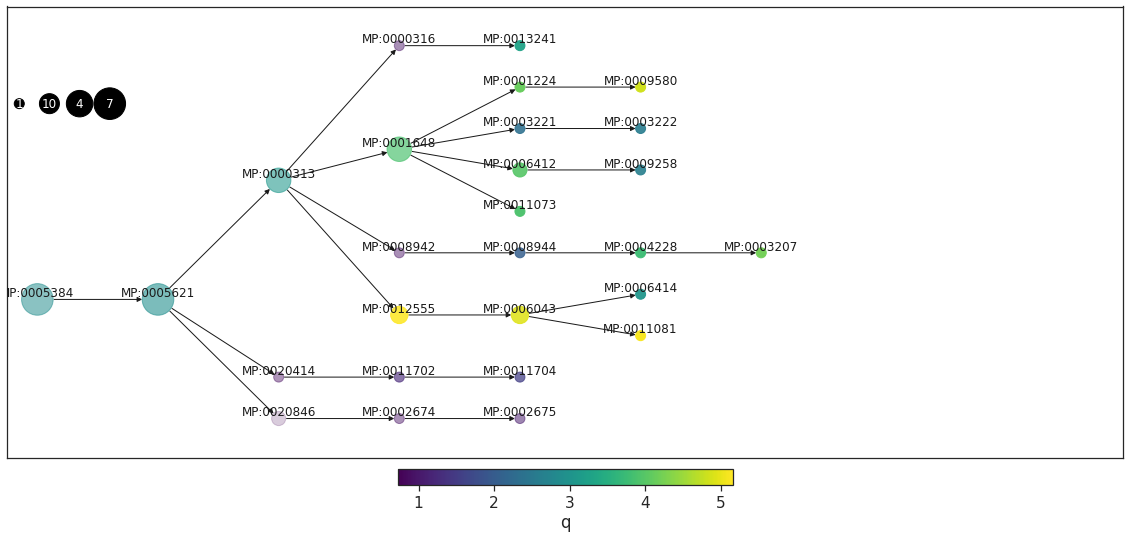

In [149]:
n = draw_significance_hierarchy(results_old.loc[results_old.observed > 0], "C889", "MP:0005384", mp_graph, MPO2, hier_df_genes, term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=10, label="all", descriptive_labels=True)

PARENT: MP:0010768 mortality/aging


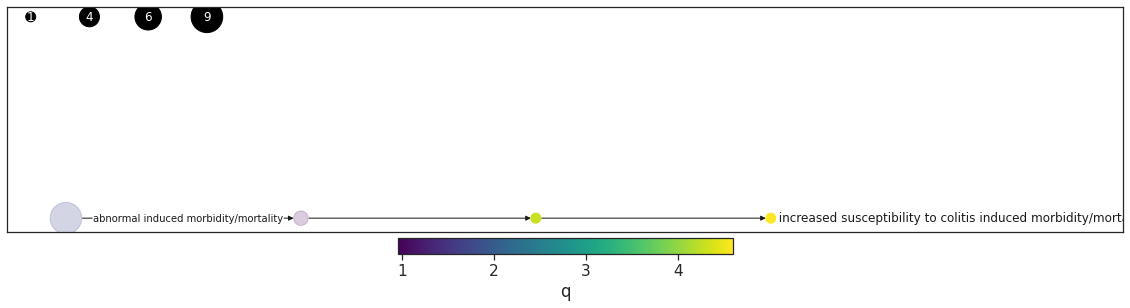

In [129]:
n = draw_significance_hierarchy(results_old.loc[results_old.observed > 0], "C889", "MP:0010768", mp_graph, MPO2, hier_df_genes, term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=5, label="leaf", descriptive_labels=True)

### C894
#### Top level

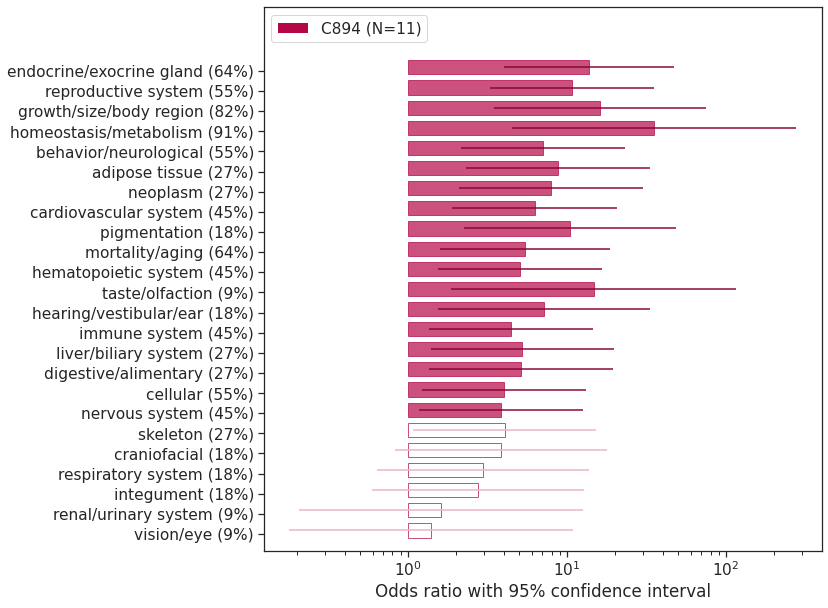

In [82]:
a = plot_hbar_comparison(results_old, communities=["C894"], mps=top_level, color_idx=3, vert=10,
                         sig_level=0.05, community_names=["C894"], sort_by_q=True, label_number="percent_community")

In [ ]:
OUTDIR= '/cellar/users/snwright/Data/Transfer/rat/'
plt.savefig(OUTDIR+"bmi_C894_network_top_level_enrichment.png", bbox_inches="tight")

In [163]:
results_old = results_old.assign(MP=results_old.index)
results_old.head()

observed   total        OR      OR_p  OR_CI_lower  OR_CI_upper  \
MP:0000001     359.0  9108.0  1.367147  0.000110     1.166759     1.601951   
MP:0010768     194.0  4591.0  1.357213  0.000494     1.142930     1.611671   
MP:0010769     184.0  4194.0  1.419438  0.000084     1.192004     1.690267   
MP:0005384     182.0  4343.0  1.332818  0.001300     1.118747     1.587851   
MP:0010770     171.0  3621.0  1.549886  0.000002     1.296036     1.853458   

             hyper_p  sig_5e6           description   size  name          MP  
MP:0000001  0.000044    False   mammalian phenotype  642.0  C877  MP:0000001  
MP:0010768  0.000263    False       mortality/aging  642.0  C877  MP:0010768  
MP:0010769  0.000050    False     abnormal survival  642.0  C877  MP:0010769  
MP:0005384  0.000676    False    cellular phenotype  642.0  C877  MP:0005384  
MP:0010770  0.000001     True  preweaning lethality  642.0  C877  MP:0010770

#### Growth/body size (82%)

PARENT: MP:0005378 growth/size/body region phenotype


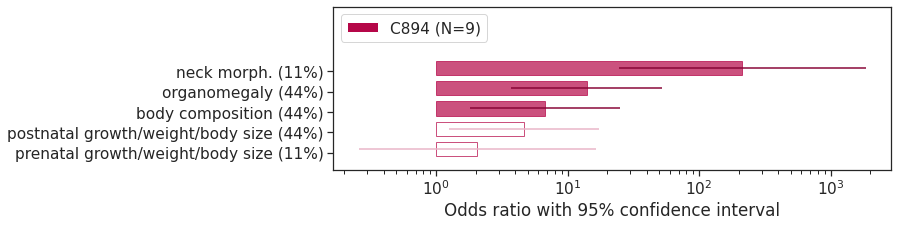

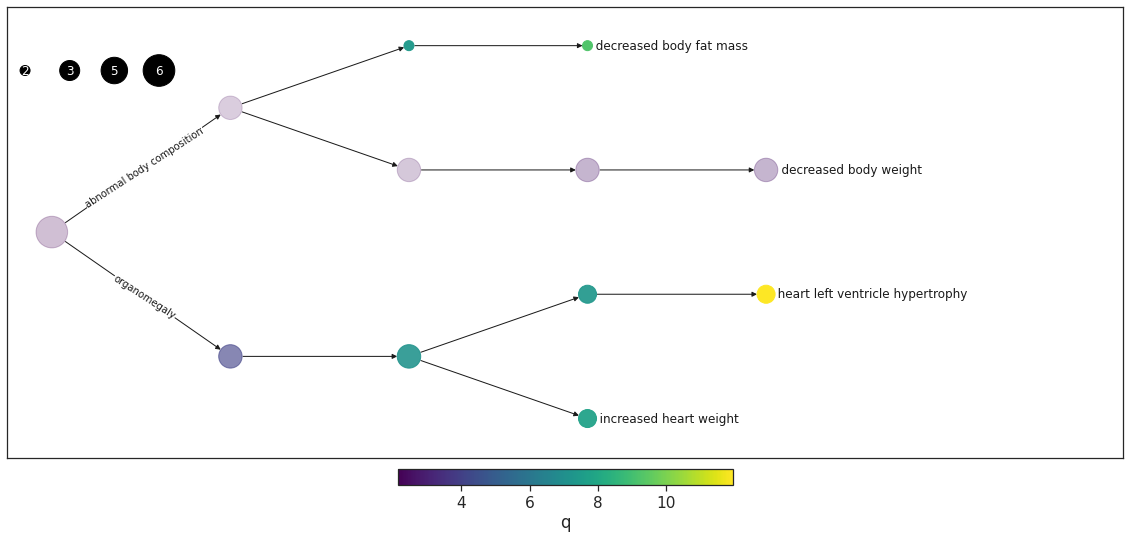

In [261]:

a = plot_hbar_comparison(results_old, communities=["C894"], mps="MP:0005378", color_idx=3, vert=3,mp_graph = mp_graph,
                         sig_level=0.05, community_names=["C894"], sort_by_q=True, label_number="percent_community")
n = draw_significance_hierarchy(results_old.loc[results_old.observed > 1], "C894", "MP:0005378", mp_graph, MPO2, hier_df_genes, term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=10, label="leaf", descriptive_labels=True)

In [215]:
n

OR          q  obs  \
MP:0005378   16.088786   3.294095  9.0   
MP:0031094    6.533301   2.250384  3.0   
MP:0005451   14.724349   4.743848  7.0   
MP:0012321   15.173265   4.661679  7.0   
MP:0012323   35.495686   7.845929  4.0   
MP:0002089   26.311977   4.362257  9.0   
MP:0003956   28.849291   4.669024  9.0   
MP:0001264   34.438343   7.726393  4.0   
MP:0001260   35.495686   7.845929  4.0   
MP:0001261   67.445913   9.127087  3.0   
MP:0001257  242.844828  14.289063  3.0   
MP:0001259   21.127135   5.049695  8.0   
MP:0011117   37.814286   8.098833  4.0   
MP:0005455   88.255018  11.820760  4.0   
MP:0001256   27.177246   5.923807  3.0   

                                                         hits  
MP:0005378  [POU1F1, PRLHR, VIPR1, GNAO1, NPFFR1, BDNF, GN...  
MP:0031094                                [GNAI2, POMC, MC4R]  
MP:0005451     [PRLHR, VIPR1, GNAO1, BDNF, GNAI2, POMC, MC4R]  
MP:0012321     [PRLHR, VIPR1, GNAO1, BDNF, GNAI2, POMC, MC4R]  
MP:0012323                          [POMC, MC4R, PRLHR, BDNF]  
MP:0002089  [POU1F1, PRLHR, VIPR1, GNAO1, NPFFR1, BDNF, GN...  
MP:0003956  [POU1F1, PRLHR, VIPR1, GNAO1, NPFFR1, BDNF, GN...  
MP:0001264                          [POMC, MC4R, PRLHR, BDNF]  
MP:0001260                          [POMC, MC4R, PRLHR, BDNF]  
MP:0001261                                 [MC4R, POMC, BDNF]  
MP:0001257                                [POMC, MC4R, PRLHR]  
MP:0001259  [BDNF, PRLHR, VIPR1, GNAO1, NPFFR1, GNAI2, POM...  
MP:0011117                          [POMC, MC4R, PRLHR, BDNF]  
MP:0005455                          [POMC, MC4R, PRLHR, BDNF]  
MP:0001256                                [POMC, MC4R, PRLHR]

#### Edo/exocrine gland (64%)

PARENT: MP:0005379 endocrine/exocrine gland phenotype


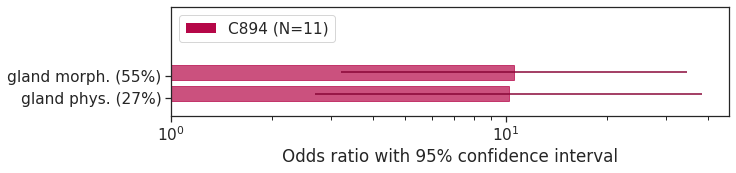

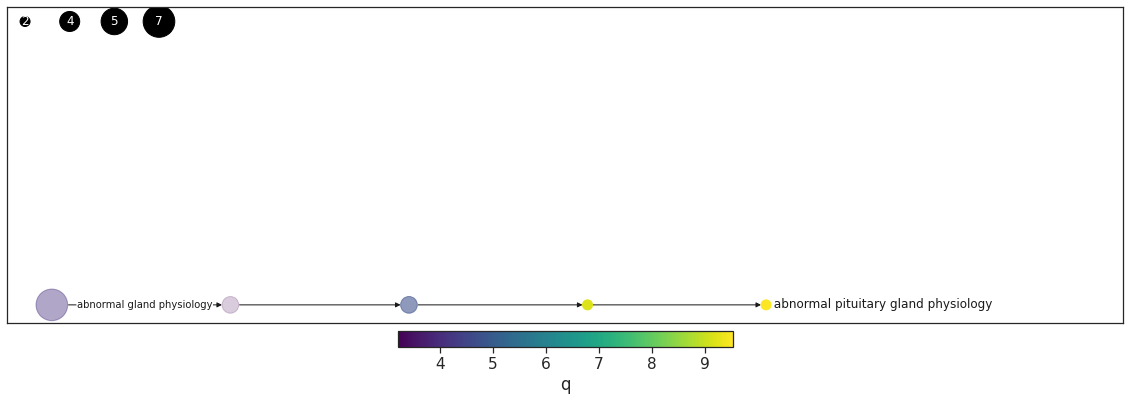

In [212]:
a = plot_hbar_comparison(results_old, communities=["C894"], mps="MP:0005379", color_idx=3, vert=2,mp_graph=mp_graph,
                         sig_level=0.05, community_names=["C894"], sort_by_q=True, label_number="percent_community")
n = draw_significance_hierarchy(results_old.loc[results_old.observed > 1], "C894", "MP:0005379", mp_graph, MPO2, 
                                hier_df_genes, term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=7, label="leaf", descriptive_labels=True)

In [213]:
n

OR         q  obs  \
MP:0005379   13.842492  4.076548  7.0   
MP:0002164   10.183945  3.206916  3.0   
MP:0013561   18.434000  4.751527  3.0   
MP:0013570  143.908046  9.204811  2.0   
MP:0005646  160.538462  9.528988  2.0   

                                                         hits  
MP:0005379  [BDNF, POU1F1, VIPR1, GNAO1, NPFFR1, GNAI2, POMC]  
MP:0002164                            [POU1F1, GNAO1, NPFFR1]  
MP:0013561                            [POU1F1, GNAO1, NPFFR1]  
MP:0013570                                   [POU1F1, NPFFR1]  
MP:0005646                                   [POU1F1, NPFFR1]

#### Reproductive (55%)

ValueError: cannot convert float NaN to integer

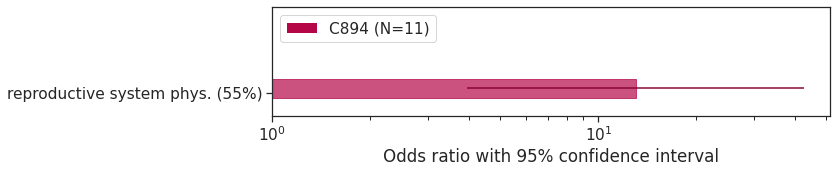

<Figure size 1440x504 with 0 Axes>

In [166]:
a = plot_hbar_comparison(results_old, communities=["C894"], mps="MP:0005389", color_idx=3, vert=2,mp_graph = mp_graph,
                         sig_level=0.05, community_names=["C894"], sort_by_q=True, label_number="percent_community")
n = draw_significance_hierarchy(results_old.loc[results_old.observed > 1], "C894", "MP:0005389", mp_graph, MPO2, 
                                hier_df_genes, term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=7, label="leaf", descriptive_labels=True)

#### Homeostasis (91%)

PARENT: MP:0005376 homeostasis/metabolism phenotype


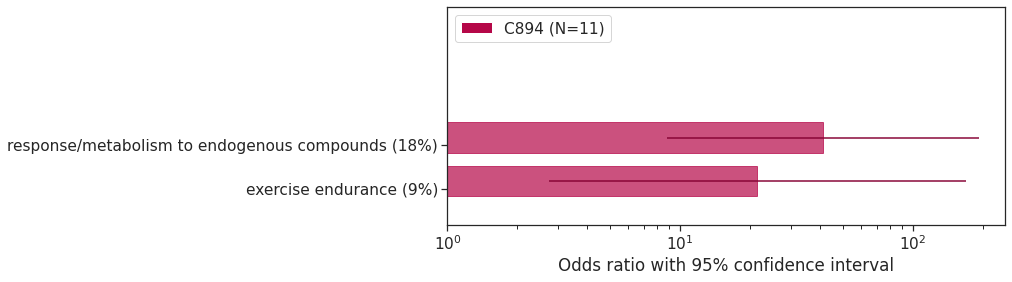

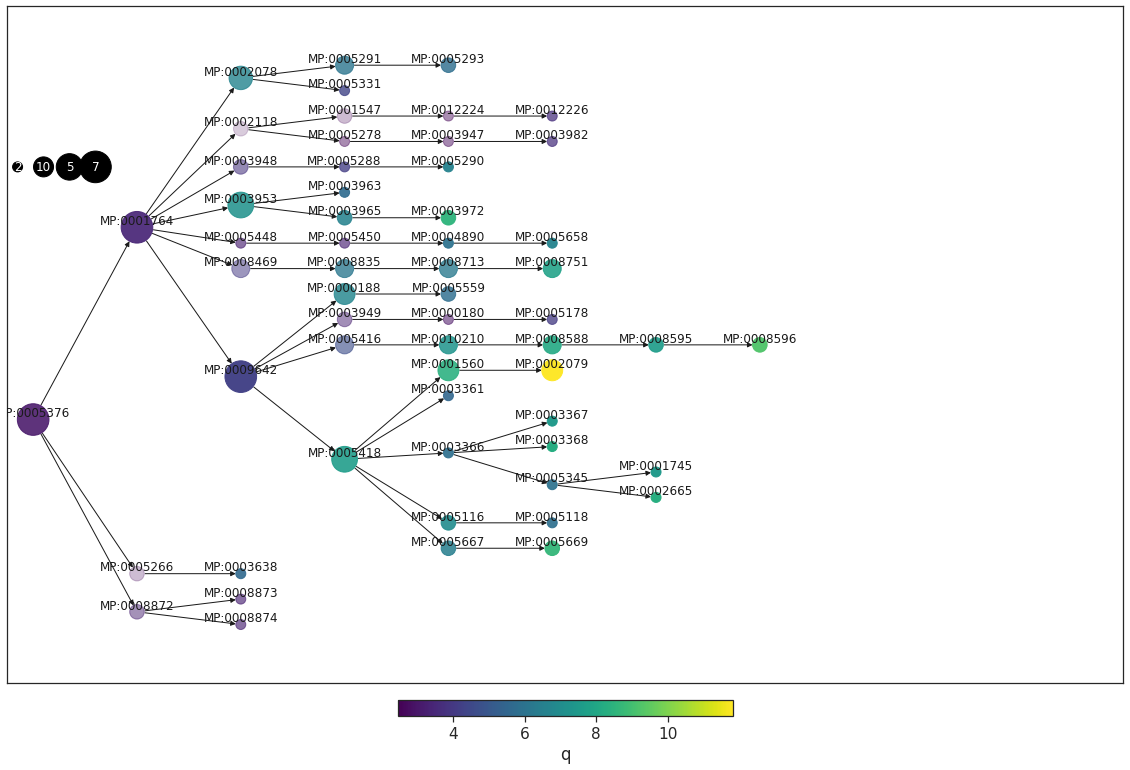

In [254]:
a = plot_hbar_comparison(results_old, communities=["C894"], mps="MP:0005266", color_idx=3, vert=4,mp_graph=mp_graph,
                         sig_level=0.05, community_names=["C894"], sort_by_q=True, label_number="percent_community")
n = draw_significance_hierarchy(results_old.loc[results_old.observed > 1], "C894", "MP:0005376", mp_graph, MPO2, 
                                hier_df_genes, term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=15, label="all", descriptive_labels=False)

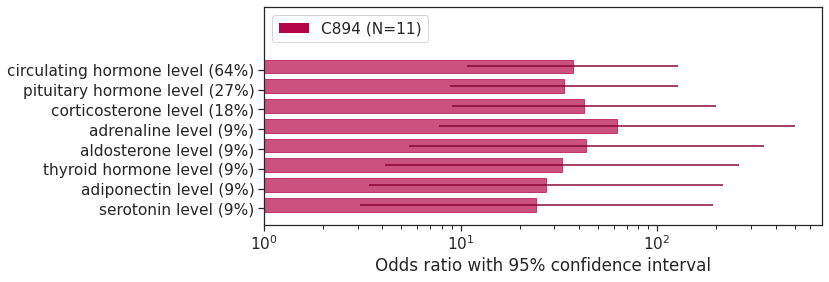

In [253]:

a = plot_hbar_comparison(results_old, communities=["C894"], mps="MP:0003953", color_idx=3, vert=4,mp_graph=mp_graph,
                         sig_level=0.05, community_names=["C894"], sort_by_q=True, label_number="percent_community")

In [211]:
n.loc[["MP:0002079", "MP:0005418", "MP:0005669", "MP:0008596", "MP:0001560", "MP:0003953", "MP:0003972"]]

OR          q  obs  \
MP:0002079  74.523237  11.818720  5.0   
MP:0005418  37.111570   7.589740  7.0   
MP:0005669  59.399364   8.644848  3.0   
MP:0008596  69.460396   9.240173  3.0   
MP:0001560  35.533643   8.380251  5.0   
MP:0003953  32.537240   7.238682  7.0   
MP:0003972  62.601562   8.541936  3.0   

                                                        hits  
MP:0002079                  [PRLHR, GNAO1, BDNF, MC4R, POMC]  
MP:0005418  [BDNF, POU1F1, PRLHR, GNAO1, NPFFR1, MC4R, POMC]  
MP:0005669                               [POMC, MC4R, PRLHR]  
MP:0008596                             [POMC, MC4R, ADORA2B]  
MP:0001560                  [PRLHR, GNAO1, BDNF, MC4R, POMC]  
MP:0003953  [BDNF, POU1F1, PRLHR, GNAO1, NPFFR1, MC4R, POMC]  
MP:0003972                            [POU1F1, POMC, NPFFR1]

#### Behaviour (55%)

PARENT: MP:0004924 abnormal behavior


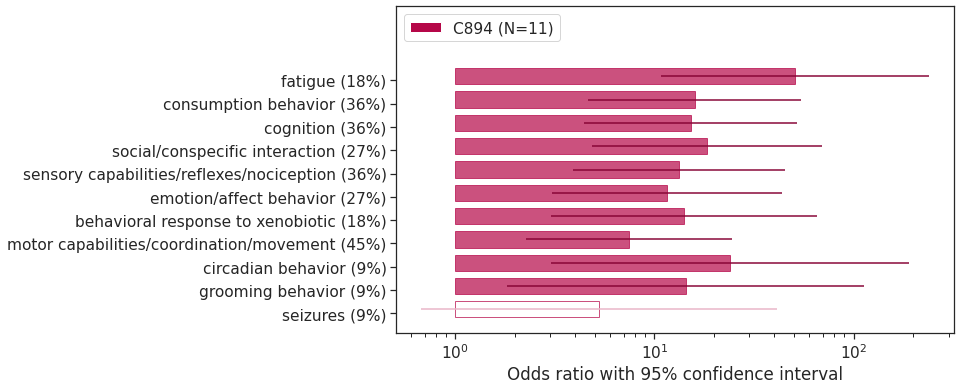

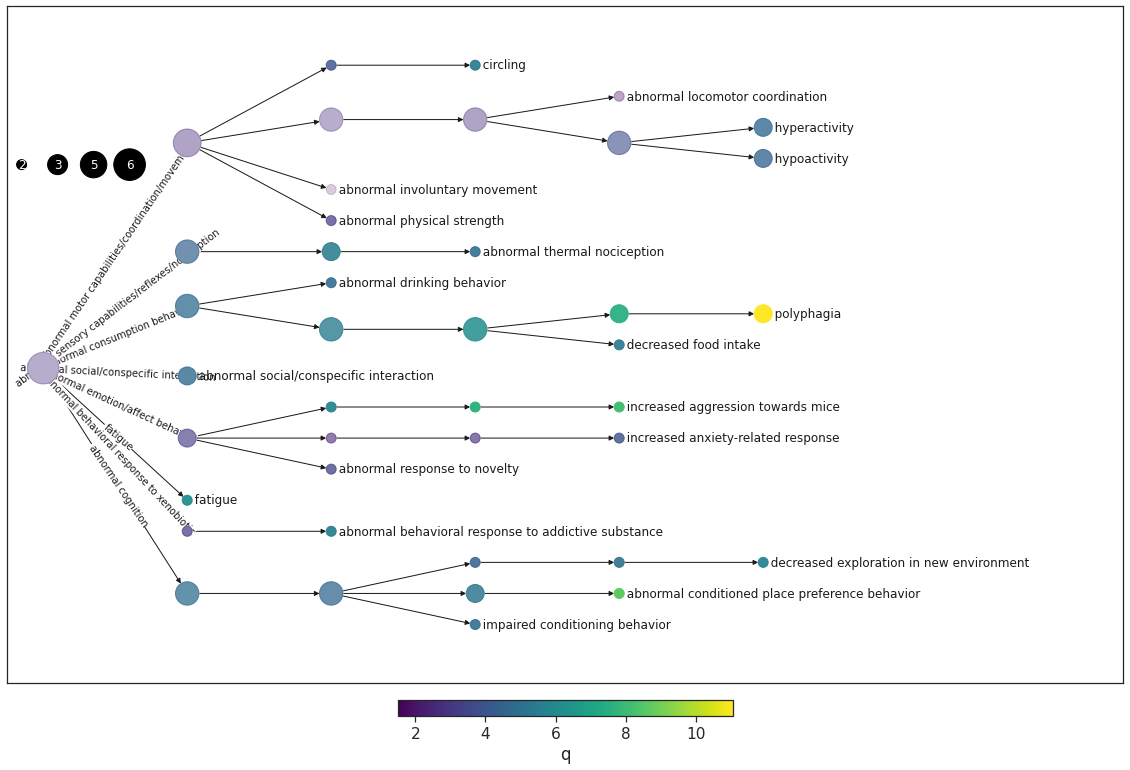

In [207]:
a = plot_hbar_comparison(results_old, communities=["C894"], mps="MP:0004924", color_idx=3, vert=6,mp_graph=mp_graph,
                         sig_level=0.05, community_names=["C894"], sort_by_q=True, label_number="percent_community")
n = draw_significance_hierarchy(results_old.loc[results_old.observed > 1], "C894", "MP:0004924", mp_graph, MPO2, 
                                hier_df_genes, term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=15, label="leaf", descriptive_labels=True)

In [204]:
n

OR          q  obs  \
MP:0004924    7.067692   2.903628  6.0   
MP:0014114   15.234454   4.840082  4.0   
MP:0002063   15.281079   4.661791  4.0   
MP:0012317   29.633333   4.786729  2.0   
MP:0002062   21.327692   5.177128  3.0   
MP:0009711  122.712418   8.730530  2.0   
MP:0001413   24.806387   4.360465  2.0   
MP:0013189   30.970149   4.895338  2.0   
MP:0001417   43.775439   5.784123  2.0   
MP:0009745   14.043231   3.124424  2.0   
MP:0009748   40.755991   5.595368  2.0   
MP:0002899   50.750678   6.182615  2.0   
MP:0002572   11.579873   3.238103  3.0   
MP:0003107   15.792252   3.363042  2.0   
MP:0002065   10.413345   2.555761  2.0   
MP:0001362   11.685977   2.768304  2.0   
MP:0001363   19.493711   3.812622  2.0   
MP:0002061   44.243499   5.812432  2.0   
MP:0005655   85.079365   7.647383  2.0   
MP:0001353  101.723577   8.173197  2.0   
MP:0002557   18.334218   4.736031  3.0   
MP:0002069   15.938556   4.806432  4.0   
MP:0001431   18.185989   5.410256  4.0   
MP:0005449   23.855844   6.169321  4.0   
MP:0011940   36.766962   5.327990  2.0   
MP:0011939   43.434783   7.501560  3.0   
MP:0001433  109.833984  11.056147  3.0   
MP:0001422   29.421592   4.769183  2.0   
MP:0002067   13.279087   4.419796  4.0   
MP:0001968   27.070039   5.434122  3.0   
MP:0002733   31.442761   4.932870  2.0   
MP:0002066    7.459877   2.738401  5.0   
MP:0004262   14.141275   3.138327  2.0   
MP:0003492    5.365716   1.497292  2.0   
MP:0003491    6.897647   2.681333  4.0   
MP:0001392    7.425595   2.679072  4.0   
MP:0003313   10.351336   3.706971  4.0   
MP:0001402   16.662138   4.467112  3.0   
MP:0001399   17.664322   4.630435  3.0   
MP:0003312    6.767373   1.836107  2.0   
MP:0001408   20.781686   3.954630  2.0   
MP:0001394   38.479424   5.445472  2.0   

                                               hits  
MP:0004924  [PRLHR, GNAO1, BDNF, GNAI2, POMC, MC4R]  
MP:0014114               [POMC, PRLHR, GNAO1, BDNF]  
MP:0002063               [POMC, PRLHR, GNAO1, BDNF]  
MP:0012317                             [POMC, BDNF]  
MP:0002062                      [POMC, PRLHR, BDNF]  
MP:0009711                            [POMC, PRLHR]  
MP:0001413                            [GNAO1, BDNF]  
MP:0013189                            [GNAO1, BDNF]  
MP:0001417                            [GNAO1, BDNF]  
MP:0009745                            [POMC, PRLHR]  
MP:0009748                            [POMC, PRLHR]  
MP:0002899                           [GNAI2, GNAO1]  
MP:0002572                      [POMC, GNAO1, BDNF]  
MP:0003107                            [GNAO1, BDNF]  
MP:0002065                            [GNAO1, BDNF]  
MP:0001362                            [GNAO1, BDNF]  
MP:0001363                            [GNAO1, BDNF]  
MP:0002061                             [POMC, BDNF]  
MP:0005655                             [POMC, BDNF]  
MP:0001353                             [POMC, BDNF]  
MP:0002557                      [POMC, GNAO1, BDNF]  
MP:0002069                [POMC, MC4R, PRLHR, BDNF]  
MP:0001431                [POMC, MC4R, PRLHR, BDNF]  
MP:0005449                [POMC, MC4R, PRLHR, BDNF]  
MP:0011940                            [POMC, PRLHR]  
MP:0011939                       [MC4R, POMC, BDNF]  
MP:0001433                       [MC4R, POMC, BDNF]  
MP:0001422                             [POMC, BDNF]  
MP:0002067               [POMC, PRLHR, GNAO1, BDNF]  
MP:0001968                     [POMC, PRLHR, GNAO1]  
MP:0002733                           [PRLHR, GNAO1]  
MP:0002066         [GNAO1, BDNF, GNAI2, POMC, MC4R]  
MP:0004262                           [GNAI2, GNAO1]  
MP:0003492                            [GNAO1, BDNF]  
MP:0003491                [MC4R, POMC, GNAO1, BDNF]  
MP:0001392                [MC4R, POMC, GNAO1, BDNF]  
MP:0003313                [MC4R, POMC, GNAO1, BDNF]  
MP:0001402                      [POMC, GNAO1, BDNF]  
MP:0001399                      [POMC, GNAO1, BDNF]  
MP:0003312                            [GNAO1, BDNF]  

#### Mortality (64%)

PARENT: MP:0010768 mortality/aging


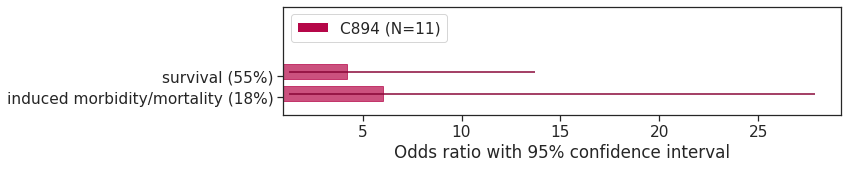

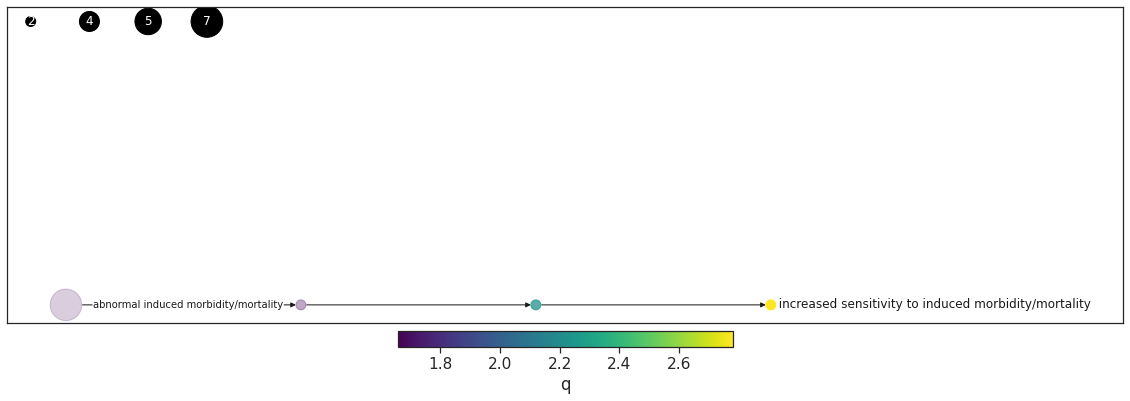

In [201]:
a = plot_hbar_comparison(results_old, communities=["C894"], mps="MP:0010768", color_idx=3, vert=2,mp_graph=mp_graph,
                         sig_level=0.05, community_names=["C894"], sort_by_q=True, label_number="percent_community")
n = draw_significance_hierarchy(results_old.loc[results_old.observed > 1], "C894", "MP:0010768", mp_graph, MPO2, 
                                hier_df_genes, term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=7, label="leaf", descriptive_labels=True)

In [202]:
n

OR         q  obs  \
MP:0010768   5.430574  1.680044  7.0   
MP:0001657   6.006955  1.657858  2.0   
MP:0020148   8.614517  2.224558  2.0   
MP:0009763  11.754218  2.779261  2.0   

                                                         hits  
MP:0010768  [POU1F1, ADORA2B, VIPR1, GNAO1, BDNF, GNAI2, P...  
MP:0001657                                   [GNAI2, ADORA2B]  
MP:0020148                                   [GNAI2, ADORA2B]  
MP:0009763                                   [GNAI2, ADORA2B]

#### Cellular (55%)

PARENT: MP:0005384 cellular phenotype


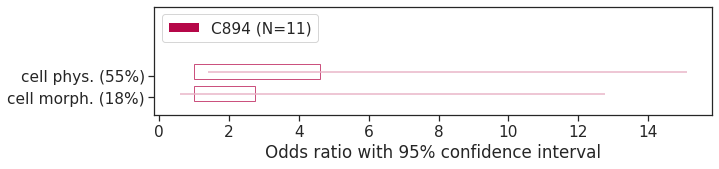

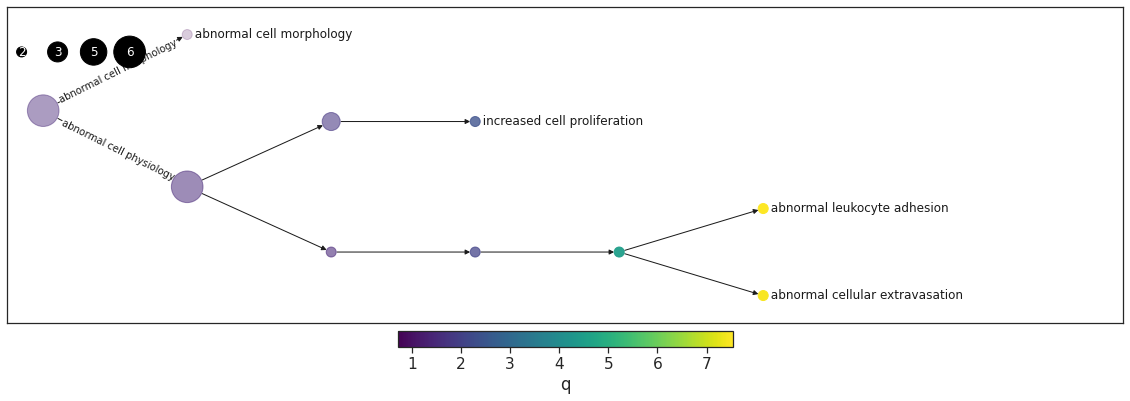

In [200]:
a = plot_hbar_comparison(results_old, communities=["C894"], mps="MP:0005384", color_idx=3, vert=2,mp_graph=mp_graph,
                         sig_level=0.05, community_names=["C894"], sort_by_q=True, label_number="percent_community")
n = draw_significance_hierarchy(results_old.loc[results_old.observed > 1], "C894", "MP:0005384", mp_graph, MPO2, 
                                hier_df_genes, term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=7, label="leaf", descriptive_labels=True)

In [198]:
n

OR         q  obs  \
MP:0005384   4.004243  1.481300  6.0   
MP:0005621   4.608235  1.472457  6.0   
MP:0020846   5.206061  1.455684  2.0   
MP:0003091   7.724123  2.044373  2.0   
MP:0003156  26.400566  4.507691  2.0   
MP:0009858  80.158120  7.473733  2.0   
MP:0003628  81.734205  7.530372  2.0   
MP:0000350   5.050673  1.773487  3.0   
MP:0000351   9.430844  2.379827  2.0   
MP:0000358   2.756949  0.710370  2.0   

                                                   hits  
MP:0005384  [POU1F1, ADORA2B, VIPR1, BDNF, GNAI2, POMC]  
MP:0005621  [POU1F1, ADORA2B, VIPR1, BDNF, GNAI2, POMC]  
MP:0020846                             [GNAI2, ADORA2B]  
MP:0003091                             [GNAI2, ADORA2B]  
MP:0003156                             [GNAI2, ADORA2B]  
MP:0009858                             [GNAI2, ADORA2B]  
MP:0003628                             [GNAI2, ADORA2B]  
MP:0000350                         [GNAI2, VIPR1, POMC]  
MP:0000351                                [GNAI2, POMC]  
MP:0000358                               [POU1F1, BDNF]

#### Adipose (27%)

PARENT: MP:0005375 adipose tissue phenotype


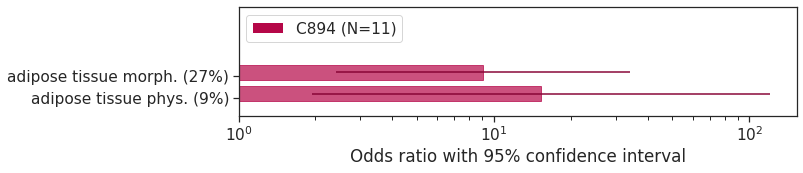

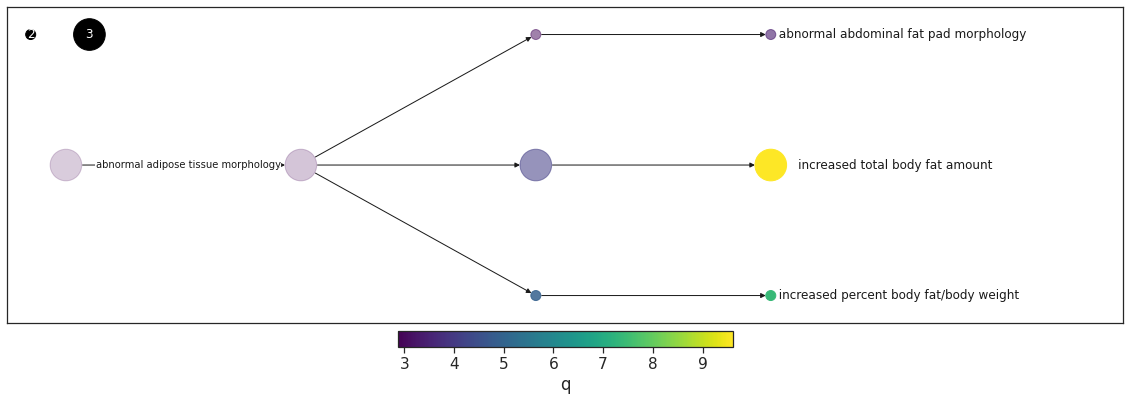

In [195]:
a = plot_hbar_comparison(results_old, communities=["C894"], mps="MP:0005375", color_idx=3, vert=2,mp_graph=mp_graph,
                         sig_level=0.05, community_names=["C894"], sort_by_q=True, label_number="percent_community")
n = draw_significance_hierarchy(results_old.loc[results_old.observed > 1], "C894", "MP:0005375", mp_graph, MPO2, 
                                hier_df_genes, term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=7, label="leaf", descriptive_labels=True)

In [196]:
n


OR         q  obs                 hits
MP:0005375   8.785227  2.869629  3.0  [POMC, MC4R, PRLHR]
MP:0000003   9.067269  2.940179  3.0  [POMC, MC4R, PRLHR]
MP:0005457  31.204678  4.914018  2.0        [MC4R, PRLHR]
MP:0005458  78.641509  7.418277  2.0        [MC4R, PRLHR]
MP:0005452  14.568591  4.102715  3.0  [POMC, MC4R, PRLHR]
MP:0010024  76.292120  9.603872  3.0  [POMC, MC4R, PRLHR]
MP:0005334  13.437182  3.036982  2.0         [MC4R, POMC]
MP:0000010  16.041505  3.395529  2.0         [MC4R, POMC]

#### Neoplasm (27%)

PARENT: MP:0002006 neoplasm


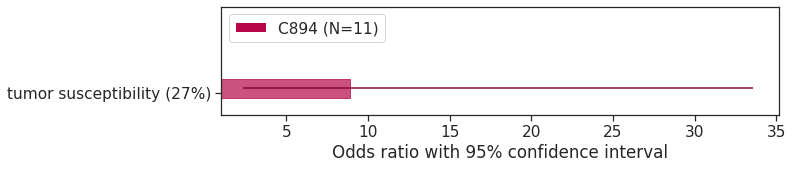

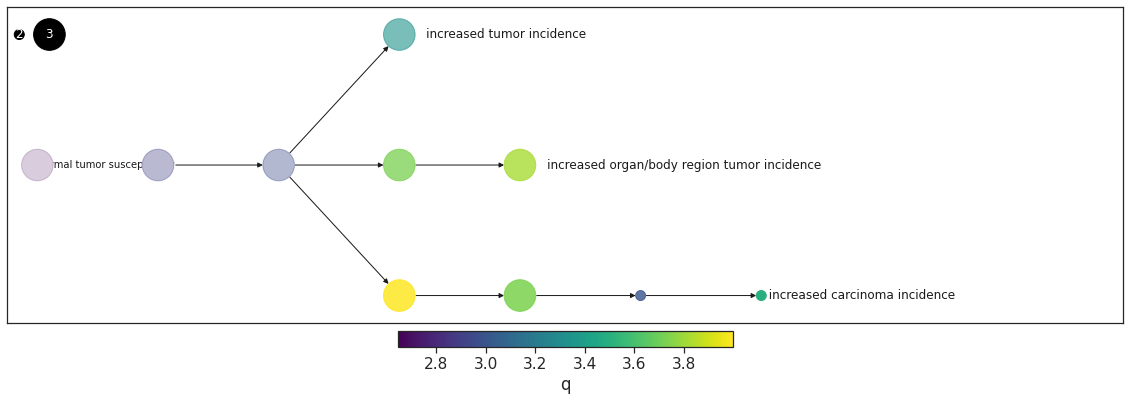

In [193]:
a = plot_hbar_comparison(results_old, communities=["C894"], mps="MP:0002006", color_idx=3, vert=2,mp_graph=mp_graph,
                         sig_level=0.05, community_names=["C894"], sort_by_q=True, label_number="percent_community")
n = draw_significance_hierarchy(results_old.loc[results_old.observed > 1], "C894", "MP:0002006", mp_graph, MPO2, 
                                hier_df_genes, term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=7, label="leaf", descriptive_labels=True)

In [194]:
n

OR         q  obs                 hits
MP:0002006   7.923088  2.645049  3.0  [GNAI2, POMC, MC4R]
MP:0002166   8.881398  2.893839  3.0  [GNAI2, POMC, MC4R]
MP:0002019   9.118102  2.952751  3.0  [GNAI2, POMC, MC4R]
MP:0020188  13.990326  3.995835  3.0  [GNAI2, POMC, MC4R]
MP:0010273  14.168041  3.727964  3.0  [GNAI2, POMC, MC4R]
MP:0002018  13.131700  2.991886  2.0        [GNAI2, MC4R]
MP:0002038  16.838095  3.497038  2.0        [GNAI2, MC4R]
MP:0013152  12.590763  3.724314  3.0  [GNAI2, POMC, MC4R]
MP:0010274  13.060000  3.817487  3.0  [GNAI2, POMC, MC4R]
MP:0002020  10.750197  3.335183  3.0  [GNAI2, POMC, MC4R]

#### Cardio (45%)

PARENT: MP:0005385 cardiovascular system phenotype


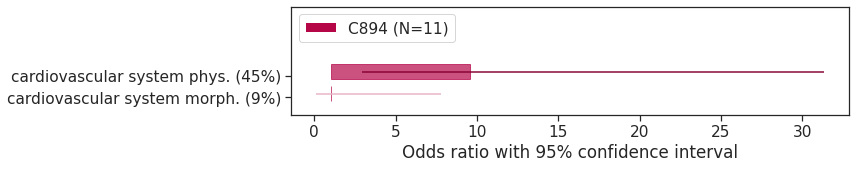

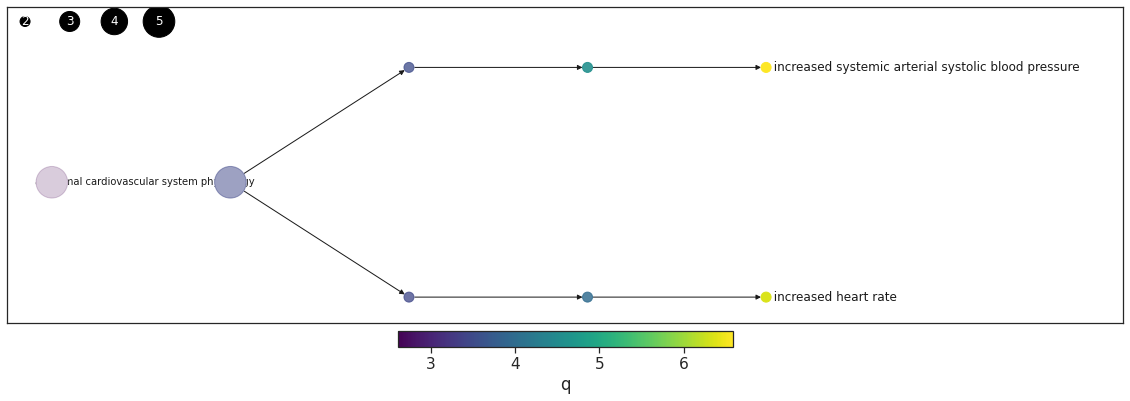

In [191]:
a = plot_hbar_comparison(results_old, communities=["C894"], mps="MP:0005385", color_idx=3, vert=2,mp_graph=mp_graph,
                         sig_level=0.05, community_names=["C894"], sort_by_q=True, label_number="percent_community")
n = draw_significance_hierarchy(results_old.loc[results_old.observed > 1], "C894", "MP:0005385", mp_graph, MPO2, 
                                hier_df_genes, term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=7, label="leaf", descriptive_labels=True)

In [192]:
n

OR         q  obs                                  hits
MP:0005385   6.252637  2.604431  5.0  [ADORA2B, VIPR1, GNAO1, GNAI2, POMC]
MP:0001544   9.546909  3.445502  5.0  [ADORA2B, VIPR1, GNAO1, GNAI2, POMC]
MP:0004085  16.430279  3.445502  2.0                      [GNAI2, ADORA2B]
MP:0001629  20.994924  3.977520  2.0                      [GNAI2, ADORA2B]
MP:0002626  54.060606  6.356034  2.0                      [GNAI2, ADORA2B]
MP:0000230  16.978509  3.514579  2.0                       [POMC, ADORA2B]
MP:0002842  27.096587  4.569876  2.0                       [POMC, ADORA2B]
MP:0006144  58.647887  6.582189  2.0                       [POMC, ADORA2B]

#### Pigment (18%)

ValueError: cannot convert float NaN to integer

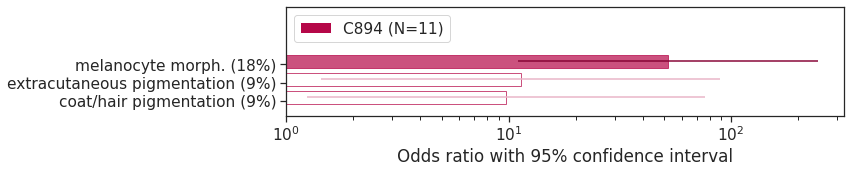

<Figure size 1440x504 with 0 Axes>

In [190]:
a = plot_hbar_comparison(results_old, communities=["C894"], mps="MP:0001186", color_idx=3, vert=2,mp_graph=mp_graph,
                         sig_level=0.05, community_names=["C894"], sort_by_q=True, label_number="percent_community")
n = draw_significance_hierarchy(results_old.loc[results_old.observed > 1], "C894", "MP:0001186", mp_graph, MPO2, 
                                hier_df_genes, term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=7, label="leaf", descriptive_labels=True)

#### Hematopoetic (45%)

PARENT: MP:0005397 hematopoietic system phenotype


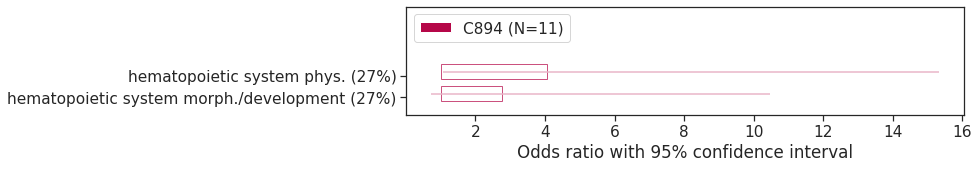

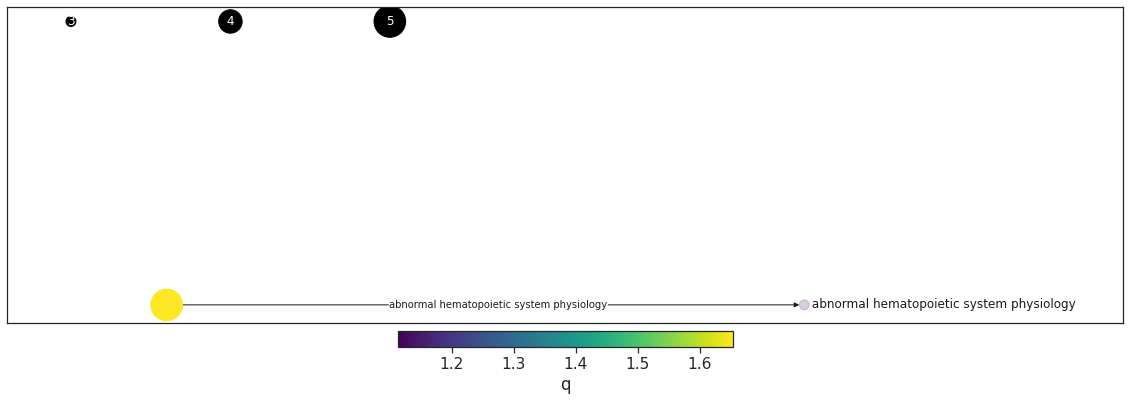

In [189]:
a = plot_hbar_comparison(results_old, communities=["C894"], mps="MP:0005397", color_idx=3, vert=2,mp_graph=mp_graph,
                         sig_level=0.05, community_names=["C894"], sort_by_q=True, label_number="percent_community")
n = draw_significance_hierarchy(results_old.loc[results_old.observed > 1], "C894", "MP:0005397", mp_graph, MPO2, 
                                hier_df_genes, term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=7, label="leaf", descriptive_labels=True)

#### Hearing (18%)

ValueError: cannot convert float NaN to integer

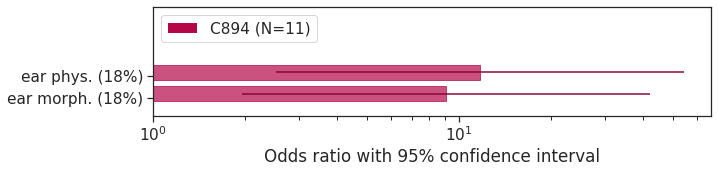

<Figure size 1440x504 with 0 Axes>

In [188]:
a = plot_hbar_comparison(results_old, communities=["C894"], mps="MP:0005377", color_idx=3, vert=2,mp_graph=mp_graph,
                         sig_level=0.05, community_names=["C894"], sort_by_q=True, label_number="percent_community")
n = draw_significance_hierarchy(results_old.loc[results_old.observed > 1], "C894", "MP:0005377", mp_graph, MPO2, 
                                hier_df_genes, term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=7, label="leaf", descriptive_labels=False)

#### Immune (45%)

PARENT: MP:0005387 immune system phenotype


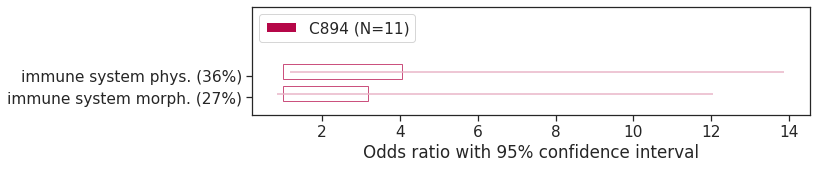

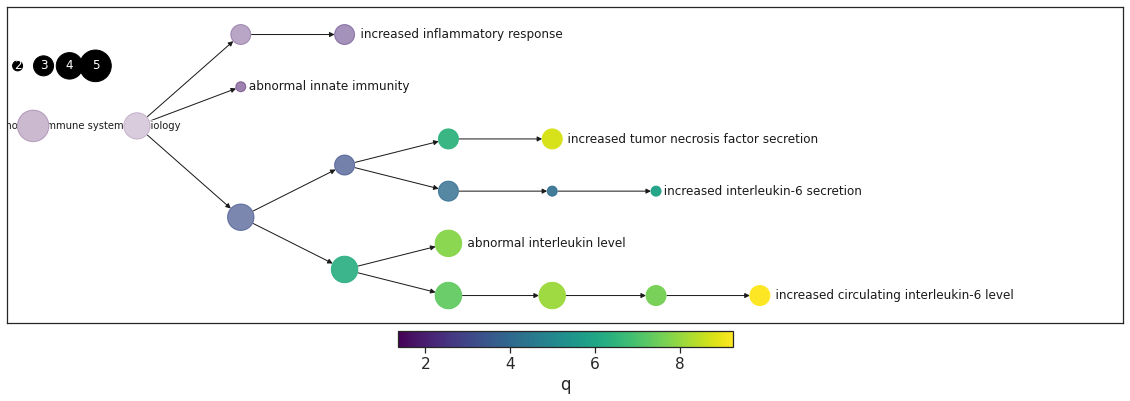

In [264]:
a = plot_hbar_comparison(results_old, communities=["C894"], mps="MP:0005387", color_idx=3, vert=2,mp_graph=mp_graph,
                         sig_level=0.05, community_names=["C894"], sort_by_q=True, label_number="percent_community")
n = draw_significance_hierarchy(results_old.loc[results_old.observed > 1], "C894", "MP:0005387", mp_graph, MPO2, 
                                hier_df_genes, term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=7, label="leaf", descriptive_labels=True)

In [185]:
n

OR         q  obs                                  hits
MP:0005387   4.461993  1.417495  5.0  [POU1F1, ADORA2B, GNAI2, POMC, MC4R]
MP:0001790   4.059334  1.350549  4.0          [POMC, GNAI2, ADORA2B, MC4R]
MP:0002723   9.325441  3.251081  4.0          [POMC, GNAI2, ADORA2B, MC4R]
MP:0008713  23.313016  6.263236  4.0          [POMC, GNAI2, ADORA2B, MC4R]
MP:0010210  30.855472  7.299470  4.0          [POMC, GNAI2, ADORA2B, MC4R]
MP:0008588  40.608648  8.087221  4.0          [POMC, GNAI2, ADORA2B, MC4R]
MP:0008595  44.550955  7.591693  3.0                 [POMC, MC4R, ADORA2B]
MP:0008596  69.460396  9.240173  3.0                 [POMC, MC4R, ADORA2B]
MP:0008751  35.255238  7.818986  4.0          [POMC, GNAI2, ADORA2B, MC4R]
MP:0003009  10.263575  3.225222  3.0                [POMC, GNAI2, ADORA2B]
MP:0008568  14.443015  4.079752  3.0                [POMC, GNAI2, ADORA2B]
MP:0008704  22.618094  4.146404  2.0                       [POMC, ADORA2B]
MP:0008705  46.219753  5.929336  2.0                       [POMC, ADORA2B]
MP:0008556  31.685795  6.421410  3.0                [POMC, GNAI2, ADORA2B]
MP:0008560  61.496711  8.775587  3.0                [POMC, GNAI2, ADORA2B]
MP:0002419   6.663738  1.812523  2.0                      [GNAI2, ADORA2B]
MP:0001845   5.165750  1.812969  3.0                [GNAI2, ADORA2B, MC4R]
MP:0001846   6.198509  2.148305  3.0                [GNAI2, ADORA2B, MC4R]

#### Liver (27%)

PARENT: MP:0005370 liver/biliary system phenotype


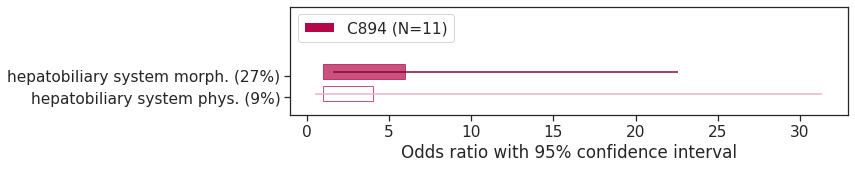

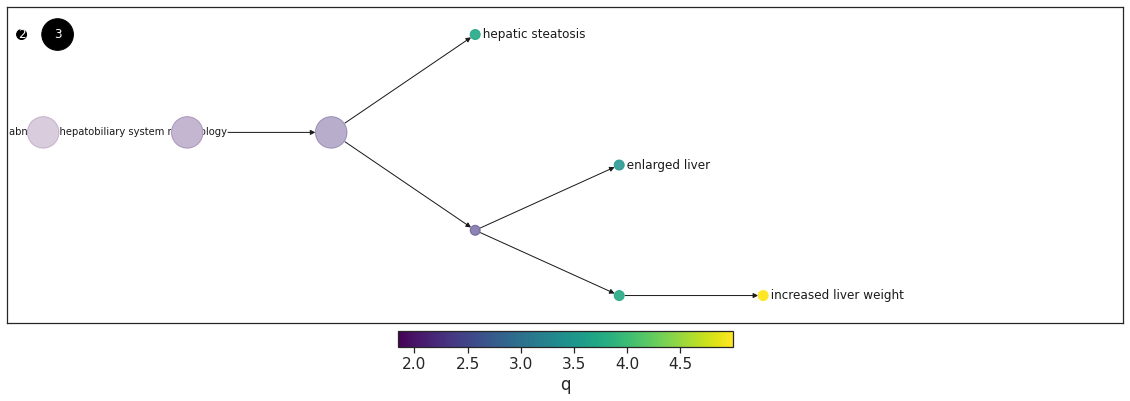

In [182]:
a = plot_hbar_comparison(results_old, communities=["C894"], mps="MP:0005370", color_idx=3, vert=2,mp_graph=mp_graph,
                         sig_level=0.05, community_names=["C894"], sort_by_q=True, label_number="percent_community")
n = draw_significance_hierarchy(results_old.loc[results_old.observed > 1], "C894", "MP:0005370", mp_graph, MPO2, 
                                hier_df_genes, term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=7, label="leaf", descriptive_labels=True)

In [183]:
n

OR         q  obs                 hits
MP:0005370   5.254190  1.843004  3.0  [GNAI2, POMC, MC4R]
MP:0002138   5.979392  2.079835  3.0  [GNAI2, POMC, MC4R]
MP:0000598   6.492941  2.238235  3.0  [GNAI2, POMC, MC4R]
MP:0004848   9.170537  2.331269  2.0         [MC4R, POMC]
MP:0004847  18.863521  3.740656  2.0         [MC4R, POMC]
MP:0002981  32.179156  4.990490  2.0         [MC4R, POMC]
MP:0000599  16.631720  3.471070  2.0         [MC4R, POMC]
MP:0002628  18.521176  3.700835  2.0         [MC4R, POMC]

#### Digestive (27%)

PARENT: MP:0005381 digestive/alimentary phenotype


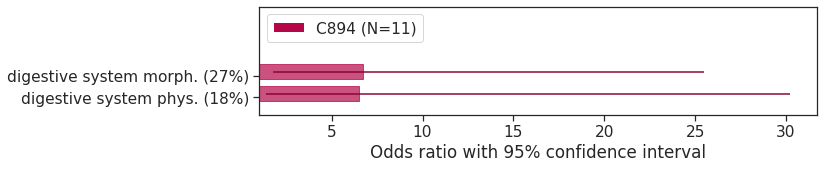

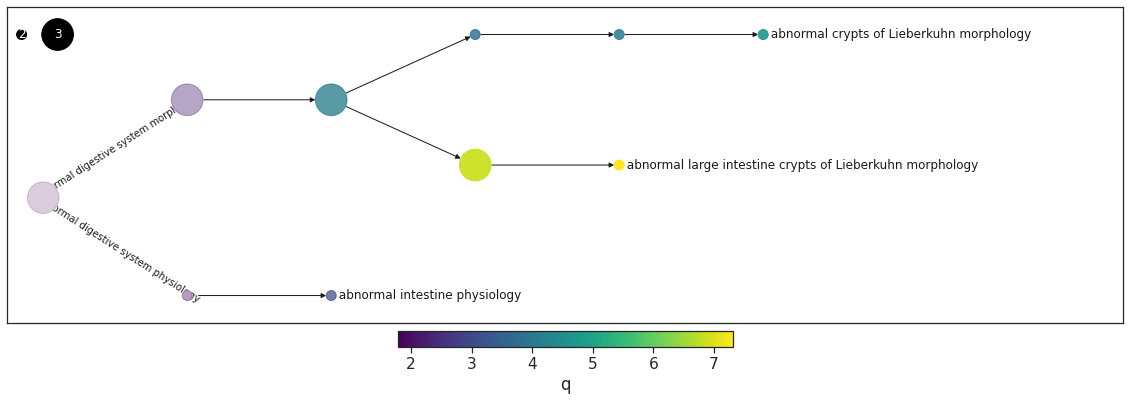

In [180]:
a = plot_hbar_comparison(results_old, communities=["C894"], mps="MP:0005381", color_idx=3, vert=2,mp_graph=mp_graph,
                         sig_level=0.05, community_names=["C894"], sort_by_q=True, label_number="percent_community")
n = draw_significance_hierarchy(results_old.loc[results_old.observed > 1], "C894", "MP:0005381", mp_graph, MPO2, 
                                hier_df_genes, term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=7, label="leaf", descriptive_labels=True)

In [181]:
n

OR         q  obs                  hits
MP:0005381   5.144073  1.779306  3.0  [GNAI2, VIPR1, BDNF]
MP:0001663   6.519355  1.779306  2.0        [GNAI2, VIPR1]
MP:0010155  13.260932  3.011050  2.0        [GNAI2, VIPR1]
MP:0000462   6.749621  2.314788  3.0  [GNAI2, VIPR1, BDNF]
MP:0000477  15.439742  4.082343  3.0  [GNAI2, VIPR1, BDNF]
MP:0000489  38.168033  6.873638  3.0  [GNAI2, VIPR1, BDNF]
MP:0004842  75.773737  7.310743  2.0         [GNAI2, BDNF]
MP:0000488  18.776768  3.730614  2.0         [GNAI2, BDNF]
MP:0000511  22.129531  4.096534  2.0         [GNAI2, BDNF]
MP:0000490  29.006993  4.734544  2.0         [GNAI2, BDNF]

#### Nervous (45%)

PARENT: MP:0003631 nervous system phenotype


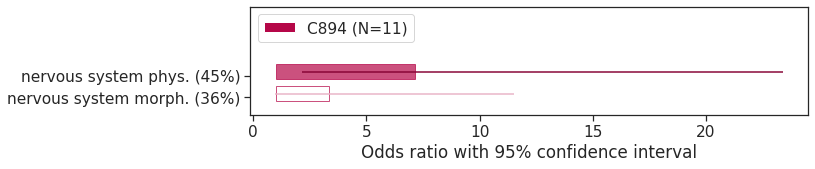

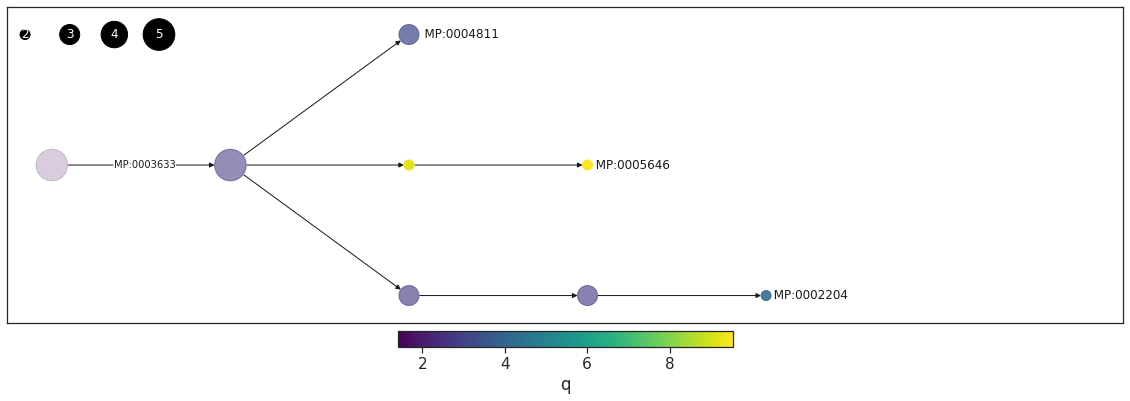

In [179]:
a = plot_hbar_comparison(results_old, communities=["C894"], mps="MP:0003631", color_idx=3, vert=2,mp_graph=mp_graph,
                         sig_level=0.05, community_names=["C894"], sort_by_q=True, label_number="percent_community")
n = draw_significance_hierarchy(results_old.loc[results_old.observed > 1], "C894", "MP:0003631", mp_graph, MPO2, 
                                hier_df_genes, term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=7, label="leaf", descriptive_labels=False)

In [178]:
n

OR         q  obs                                 hits
MP:0003631    3.842731  1.404283  5.0  [BDNF, POU1F1, GNAO1, NPFFR1, POMC]
MP:0003633    7.131182  2.800205  5.0  [BDNF, POU1F1, GNAO1, NPFFR1, POMC]
MP:0021009    8.082284  2.687584  3.0                        [GNAO1, BDNF]
MP:0003635    8.143569  2.703826  3.0                        [GNAO1, BDNF]
MP:0002204   23.392341  4.223831  2.0                                   []
MP:0013570  143.908046  9.204811  2.0                     [POU1F1, NPFFR1]
MP:0005646  160.538462  9.528988  2.0                     [POU1F1, NPFFR1]
MP:0004811   10.311932  3.236295  3.0                 [POU1F1, POMC, BDNF]

### Other

In [24]:
c882_genes = hier_df_genes.loc["C882", "CD_MemberList"].split(" ")
c886_genes = hier_df_genes.loc["C886", "CD_MemberList"].split(" ")
c900_genes = hier_df_genes.loc["C900", "CD_MemberList"].split(" ")

In [29]:
for x in c900_genes:
    print(x)

KDM3A
KDM3B
JMJD8
JMJD7
KDM5A
PHF2
KDM6A
KDM5D
KDM6B
KDM8


#### C909

In [ ]:
a = plot_hbar_comparison(results_old, communities=["C909"], mps="MP:0000001", color_idx=3, vert=15,mp_graph = mp_graph,
                         sig_level=0.05, community_names=["C909"], sort_by_q=True, label_number="percent_community")

In [ ]:
a = plot_hbar_comparison(results_old, communities=["C909"], mps="MP:000", color_idx=3, vert=15,mp_graph = mp_graph,
                         sig_level=0.05, community_names=["C894"], sort_by_q=True, label_number="percent_community")

#### C885 - cell fate regulation

In [ ]:
_ = plot_CIs(results_old, "MP:0000001", use_node="C885", plot_by="OR_p", ascending=False)

In [ ]:
_ = plot_CIs(results_old, "MP:0000001", use_node="C885")

In [ ]:
_ = plot_CIs(results_old, "MP:0005378", use_node="C885")

In [ ]:
_ = plot_CIs(results_old, "MP:0002089", use_node="C885")

In [ ]:
_ = plot_CIs(results_old, "MP:0005508", use_node="C885")

In [ ]:
_ = plot_CIs(results_old, "MP:0005379", use_node="C885")

In [ ]:
_ = plot_CIs(results_old, "MP:0002163", use_node="C885")

In [ ]:
_ = plot_CIs(results_old, "MP:0003633", use_node="C885")

In [ ]:
_ = plot_CIs(results_old, "MP:0000003", use_node="C885")

In [ ]:
results_old.to_csv("full_enrichment_results.tsv", sep="\t")

In [ ]:
for node in nx.dfs_preorder_nodes(mp_graph, "MP:0000001", 1):
    print(node)

#### C884 - neurotransmitter 2

In [ ]:
_ = plot_CIs(results_old, "MP:0000001", use_node="C884", plot_by="OR_p", ascending=False)

In [ ]:
_ = plot_CIs(results_old, "MP:0003631", use_node="C884")

In [ ]:
_ = plot_CIs(results_old, "MP:0003633", use_node="C884")

In [ ]:
_ = plot_CIs(results_old, "MP:0004924", use_node="C884")

In [ ]:
_ = plot_CIs(results_old, "MP:0002089", use_node="C884")

#### C887

In [ ]:
x = plot_CIs(results_old, "MP:0000001", use_node="C887")

In [ ]:
_ = plot_CIs(results_old, "MP:0004924", use_node="C887")

In [ ]:
_ = plot_CIs(results_old, "MP:0010768", use_node="C881")

In [ ]:
_ = plot_CIs(results_old, "MP:000", use_node="C894")

# Plot given set of MPs

### P50 grant figure

In [269]:
p50_mps = ["MP:0003956", "MP:0010866", "MP:0005451"] + ["MP:0005418", "MP:0000188"] + ["MP:0002069", "MP:0002066"]

p50_mps += ["MP:0002108", "MP:0002106"] + ["MP:0002127", "MP:0001544"]

p50_mps += ["MP:0002092", "MP:0005253"]

abnormal prenatal body size
785.0
abnormal circulating glucose level
572.0
abnormal consumption behavior
655.0
abnormal muscle morphology
1058.0
abnormal muscle physiology
955.0
abnormal eye morphology
1142.0


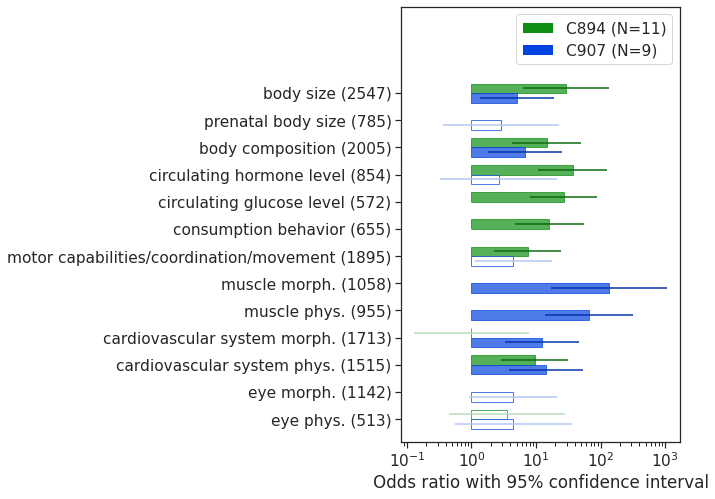

In [285]:
a = plot_hbar_comparison(results_old, communities=["C894", "C907"], mps=p50_mps, vert=8,mp_graph=mp_graph,
                         sig_level=0.05, community_names=["C894", "C907"], sort_by_q=False, label_number="total", horz=5)

### DM1 + MAPK

In [174]:
prenatal = ["MP:0010866", "MP:0002088",  "MP:0010865","MP:0004197"] # body size
prenatal += ["MP:0000313", "MP:0005076"] #Cellular
prenatal += ["MP:0003861", "MP:0002152"] #nervous
prenatal += ["MP:0001697", "MP:0002086"] #embryo
prenatal += ["MP:0010770"] # aging
prenatal += ["MP:0002925", "MP:0001614"] # cardio
prenatal += [] #controls

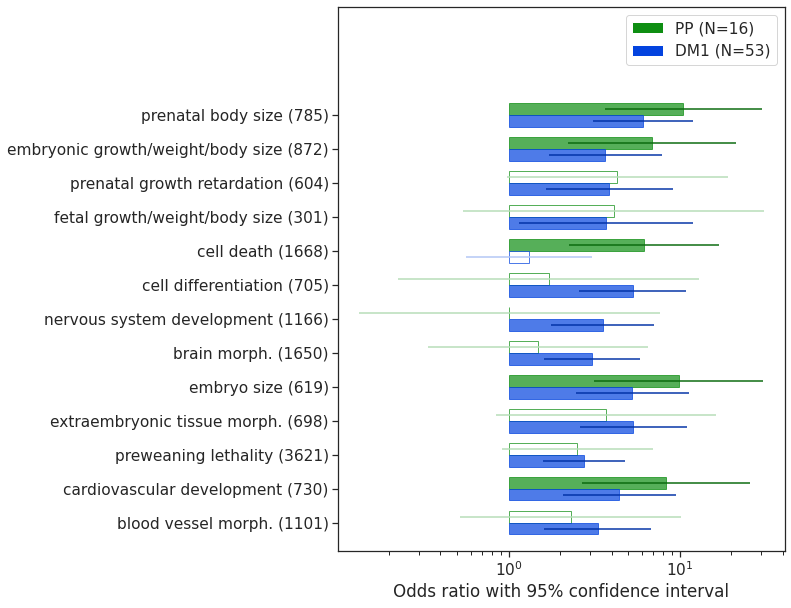

In [176]:
a = plot_hbar_comparison(results_old, communities=["C889", "C882"], mps=prenatal, vert=10,mp_graph=mp_graph,
                         sig_level=0.05, community_names=["PP", "DM1"], sort_by_q=False, label_number="total", horz=8)

### Bar version

In [ ]:
   
def plot_specific_CIs_bar(results, mp_list, n_test, mp_graph=mp_graph, use_node="C877", sort=False):
    top_level = [node for node in mp_list if (node in results.loc[results.name==use_node].index)]
    to_plot= results.loc[results.name==use_node].loc[top_level]
    colors = ["blue" for _ in range(n_test)] + ["orange" for _ in range(len(top_level)-n_test)]
    to_plot["c"] = colors
    n_tests = len(mp_list)
    if len(to_plot) < n_tests:
        diff = n_tests = len(to_plot)
        to_plot["q_OR"] = fdrcorrection(list(to_plot["OR_p"]) + [1 for _ in range(diff)], method="poscorr")[1][1:(-1*diff)]
    else:
        to_plot["q_OR"] = fdrcorrection(to_plot["OR_p"], method="poscorr")[1]
    if sort:
        to_plot = to_plot.sort_values(by="OR_CI_lower")
    plt.figure(figsize=[7,len(to_plot)/3+0.1])
    
    to_plot["facecolor"] = to_plot.apply(lambda x: x["c"] if x["q_OR"] < 0.05 else "white", axis=1)
    
    ax = plt.barh(width=to_plot.OR-1, y=[i for i in range(len(to_plot))], color=to_plot["facecolor"], alpha=0.7, left=1,
                 edgecolor=to_plot["c"])
    
    sigs = to_plot.loc[to_plot["q_OR"] < 0.05].index
    not_sigs = to_plot.loc[to_plot["q_OR"] >= 0.05].index
    plt.hlines([i for i in range(len(to_plot)) if to_plot.iloc[i]["q_OR"] < 0.05], to_plot.loc[sigs].OR_CI_lower, 
               to_plot.loc[sigs].OR_CI_upper, colors="dark"+to_plot.loc[sigs]["c"], alpha=1)
    plt.hlines([i for i in range(len(to_plot)) if to_plot.iloc[i]["q_OR"] >= 0.05], to_plot.loc[not_sigs].OR_CI_lower, 
               to_plot.loc[not_sigs].OR_CI_upper, colors=to_plot.loc[not_sigs]["c"], alpha=0.5)

    plt.vlines(1.0, -1, len(to_plot), linestyles='dashed', colors='black', alpha=0.5, lw=0.5)
    ylabels = [to_plot.loc[node, "description"] + " (" + str(int(to_plot.loc[node, "total"]))+")" for node in to_plot.index]
    ylabels = [desc.split("abnormal ")[1] if ("abnormal" in desc) else desc for desc in ylabels]
    ylabels = [desc.replace("physiology", "phys.") for desc in ylabels]
    ylabels = [desc.replace("morphology", "morph.") for desc in ylabels]
    ylabels = [desc.replace(" phenotype", "") for desc in ylabels]
    a=plt.yticks(ticks=[i for i in range(len(to_plot))], labels=ylabels)
    if max(to_plot.OR_CI_upper) > 5:
        plt.xscale('log')    
    plt.xlabel("Odds ratio with 95% confidence interval")
    try:
        desc = results.loc[root, "description"].unique()[0]
    except AttributeError:
        desc = results.loc[root, "description"]
    plt.title("Enrichment for " + desc+"s")
    print("Significant enrichments (q < 0.05):\n", to_plot.sort_values(by="q_OR").loc[to_plot.q_OR <= 0.05, ("description", "q_OR", "OR_p")])
    return to_plot

### NES1, DM1, CIM

In [ ]:
plot_hbar_comparison(results_old, ["C879", "C882", "C907"], colors=["green", "blue", "orange", "red"], mps=mps, errorbars='all',
                   community_names = ["Neurotransmitter parent", "demethylation parent", "calcium ion/muscle"])
# be clear about rules for choosing communities (top 3, size rule)
# add a hierarchy on the side showing parent terms
# re-order terms

### Updated MP set

In [ ]:
mps2 = ["MP:0004196", "MP:0002089", "MP:0005451", "MP:0031094", "MP:0002066", "MP:0002067", "MP:0014114", "MP:0002069", 
       "MP:0003633", "MP:0003632",  "MP:0005508", "MP:0001533", "MP:0002108", "MP:0002106", "MP:0002127", "MP:0001544",
       "MP:0000358", "MP:0005621", "MP:0014134", "MP:0001672", "MP:0002086", "MP:0002396", 
       "MP:0001545", "MP:0002092", "MP:0005253"]
select_mp_groups = [0,0,0,0,1,1,1,1,0,0,1,1,0,0,1,1,0,0,1,1,1,0,0,1,1]

In [ ]:
x, ax = plot_hbar_comparison(results_old, communities=["C879","C882", "C907"], mps=mps2, sig_level=0.05, 
                         community_names=["NES1","DM1", "CIM"], sort_by_q=False, label_number=None, vert=15)
colors = {0:"#111471", 1:"#3C3638"}
for ytick, color in zip(ax.get_yticklabels(), select_mp_groups):
    ytick.set_color(colors[color])

### DM1, CIM, C894

In [ ]:

mps3 = ["MP:0004196", "MP:0002089", "MP:0005451", "MP:0031094", "MP:0002066", "MP:0002067", "MP:0014114", "MP:0002069", 
       "MP:0003633", "MP:0003632",  "MP:0005508", "MP:0001533", "MP:0002108", "MP:0002106", "MP:0002127", "MP:0001544",
       "MP:0000358", "MP:0005621", "MP:0014134", "MP:0001672", "MP:0002086", "MP:0002163", "MP:0002164", "MP:0002160", "MP:0001919", 
        "MP:0001764", "MP:0005266", "MP:0008872","MP:0002396", 
       "MP:0001545", "MP:0002092", "MP:0005253" ]
select_mp_groups = [0,0,0,0,1,1,1,1,0,0,1,1,0,0,1,1,0,0,1,1,1,0,0,1,1,0,0,0,1,1,0,0]

In [ ]:

x, ax = plot_hbar_comparison(results_old, ["C894", "C882", "C907"], mps=top_level, vert=15,
                   community_names = ["C894", "DM1", "CIM"])
#colors = {0:"#111471", 1:"#3C3638"}
#for ytick, color in zip(ax.get_yticklabels(), select_mp_groups):
#    ytick.set_color(colors[color])

In [ ]:
x.to_csv("bar_plot_data.tsv", sep="\t")

In [ ]:
a = plot_specific_CIs_bar(results_old, ["MP:0001431", "MP:0010866", "MP:0003956", "MP:0005451", "MP:0002420", "MP:0005367"], n_test=4, sort=True)

_ =plt.xlim((0.5, 2.75))
_ =plt.xticks([0.5, 1.0, 1.5, 2.0, 2.5])

In [ ]:
b = plot_specific_CIs_bar(results_old, ["MP:0000003", "MP:0002108", "MP:0002106", "MP:0005508", "MP:0001533", "MP:0003632", "MP:0003633", "MP:0005266", "MP:0002163", "MP:0002164", "MP:0000358", "MP:0005621", "MP:0000462", "MP:0001663"], n_test=14, sort=True)

_ =plt.xlim((0.5, 2.75))
_ =plt.xticks([0.5, 1.0, 1.5, 2.0, 2.5])

# Gene lists

In [ ]:
term_counts, gene_mapping, term_mapping = genes_per_node(MPO2)

In [ ]:
a = get_gene_hits("C879", hier_df_genes, term_mapping, "MP:0001431", MPO2, mp_graph)
a.head()

In [ ]:
c879_1431 = get_gene_hits("C879", hier_df_genes, term_mapping, "MP:0001431", MPO2, mp_graph)

In [ ]:
c879_2069 = get_gene_hits("C879", hier_df_genes, term_mapping, "MP:0002069", MPO2, mp_graph)

In [ ]:
c879_3632 = get_gene_hits("C879", hier_df_genes, term_mapping, "MP:0003632", MPO2, mp_graph)

In [ ]:
c882_4196 = get_gene_hits("C882", hier_df_genes, term_mapping, "MP:0004196", MPO2, mp_graph)

In [ ]:
c882_10866 = get_gene_hits("C882", hier_df_genes, term_mapping, "MP:0010866", MPO2, mp_graph)

In [ ]:
c882_3632 = get_gene_hits("C882", hier_df_genes, term_mapping, "MP:0003632", MPO2, mp_graph)

In [ ]:
c882_9937 = get_gene_hits("C882", hier_df_genes, term_mapping, "MP:0009937", MPO2, mp_graph)
for u in c882_9937.loc[c882_9937.inMP == 1].gene.unique():
    print(u)

In [ ]:
c907_5369 = get_gene_hits("C907", hier_df_genes, term_mapping, "MP:0005369", MPO2, mp_graph)
for u in c907_5369.loc[c907_5369.inMP == 1].gene.unique():
    print(u)

In [ ]:
c879_3633 = get_gene_hits("C879", hier_df_genes, term_mapping, "MP:0003633", MPO2, mp_graph)
for u in c879_3633.loc[c879_3633.inMP == 1].gene.unique():
    print(u)

In [ ]:
all_results = pd.concat([c879_1431, c879_2069, c879_3632, c882_4196, c882_10866, c882_3632])

# Network Plotting

In [ ]:
import networkx as nx
import random
from matplotlib.patches import BoxStyle as bx
 
def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, leaf_vs_root_factor = 0.5):

    '''
    If the graph is a tree this will return the positions to plot this in a 
    hierarchical layout.
    
    Based on Joel's answer at https://stackoverflow.com/a/29597209/2966723,
    but with some modifications.  

    We include this because it may be useful for plotting transmission trees,
    and there is currently no networkx equivalent (though it may be coming soon).
    
    There are two basic approaches we think of to allocate the horizontal 
    location of a node.  
    
    - Top down: we allocate horizontal space to a node.  Then its ``k`` 
      descendants split up that horizontal space equally.  This tends to result
      in overlapping nodes when some have many descendants.
    - Bottom up: we allocate horizontal space to each leaf node.  A node at a 
      higher level gets the entire space allocated to its descendant leaves.
      Based on this, leaf nodes at higher levels get the same space as leaf
      nodes very deep in the tree.  
      
    We use use both of these approaches simultaneously with ``leaf_vs_root_factor`` 
    determining how much of the horizontal space is based on the bottom up 
    or top down approaches.  ``0`` gives pure bottom up, while 1 gives pure top
    down.   
    
    
    :Arguments: 
    
    **G** the graph (must be a tree)

    **root** the root node of the tree 
    - if the tree is directed and this is not given, the root will be found and used
    - if the tree is directed and this is given, then the positions will be 
      just for the descendants of this node.
    - if the tree is undirected and not given, then a random choice will be used.

    **width** horizontal space allocated for this branch - avoids overlap with other branches

    **vert_gap** gap between levels of hierarchy

    **vert_loc** vertical location of root
    
    **leaf_vs_root_factor**

    xcenter: horizontal location of root
    '''
    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, leftmost, width, leafdx = 0.2, vert_gap = 0.2, vert_loc = 0, 
                    xcenter = 0.5, rootpos = None, 
                    leafpos = None, parent = None):
        '''
        see hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        '''

        if rootpos is None:
            rootpos = {root:(xcenter,vert_loc)}
        else:
            rootpos[root] = (xcenter, vert_loc)
        if leafpos is None:
            leafpos = {}
        children = list(G.neighbors(root))
        leaf_count = 0
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            rootdx = width/len(children)
            nextx = xcenter - width/2 - rootdx/2
            for child in children:
                nextx += rootdx
                rootpos, leafpos, newleaves = _hierarchy_pos(G,child, leftmost+leaf_count*leafdx, 
                                    width=rootdx, leafdx=leafdx,
                                    vert_gap = vert_gap, vert_loc = vert_loc-vert_gap, 
                                    xcenter=nextx, rootpos=rootpos, leafpos=leafpos, parent = root)
                leaf_count += newleaves

            leftmostchild = min((x for x,y in [leafpos[child] for child in children]))
            rightmostchild = max((x for x,y in [leafpos[child] for child in children]))
            leafpos[root] = ((leftmostchild+rightmostchild)/2, vert_loc)
        else:
            leaf_count = 1
            leafpos[root]  = (leftmost, vert_loc)
#        pos[root] = (leftmost + (leaf_count-1)*dx/2., vert_loc)
#        print(leaf_count)
        return rootpos, leafpos, leaf_count

    xcenter = width/2.
    if isinstance(G, nx.DiGraph):
        leafcount = len([node for node in nx.descendants(G, root) if G.out_degree(node)==0])
    elif isinstance(G, nx.Graph):
        leafcount = len([node for node in nx.node_connected_component(G, root) if G.degree(node)==1 and node != root])
    rootpos, leafpos, leaf_count = _hierarchy_pos(G, root, 0, width, 
                                                    leafdx=width*1./leafcount, 
                                                    vert_gap=vert_gap, 
                                                    vert_loc = vert_loc, 
                                                    xcenter = xcenter)
    pos = {}
    for node in rootpos:
        pos[node] = (leaf_vs_root_factor*leafpos[node][0] + (1-leaf_vs_root_factor)*rootpos[node][0], leafpos[node][1]) 
#    pos = {node:(leaf_vs_root_factor*x1+(1-leaf_vs_root_factor)*x2, y1) for ((x1,y1), (x2,y2)) in (leafpos[node], rootpos[node]) for node in rootpos}
    xmax = max(x for x,y in pos.values())
    for node in pos:
        pos[node]= (pos[node][0]*width/(xmax+1), pos[node][1])
    return pos


def draw_significance_hierarchy(data, community, root, mpG, MPO, hier_df_genes, term_mapping, select_on="q", size_by="OR", 
                                color_by="q", alpha_by=None, 
                                vert=10, label="all", descriptive_labels=False,
                               adjust_root=0):
    comm_genes = hier_df_genes.loc[community, "CD_MemberList"].split(" ")
    data = data.loc[data.name==community]
    stop = False
    sigH = []
    queue = []
    current=root
    previous=root
    data = data.assign(proportion=data.observed/data.total)
    while not stop:
        children = [node for node in nx.dfs_preorder_nodes(mpG, current, 1)]
        if len(children) == 0:
            if len(queue) > 0:
                previous, current = queue.pop()
            else:
                stop=True
        else:
            node_order = [node for node in children if node in data.index]
            subset = data.loc[node_order]
            subset.loc[:, "q"] = fdrcorrection(subset.OR_p, method="poscorr")[1]
            if select_on=="q":
                new_sigs = list(subset.loc[subset.q < subset.loc[current, "q"], "MP"].values)
            elif select_on=="OR":
                new_sigs = list(subset.loc[subset.OR > subset.loc[current, "OR"], "MP"].values)
            if select_on=="proportion":
                new_sigs = list(subset.loc[subset.proportion > subset.loc[current, "proportion"], "MP"].values)
            queue += [(current, sig)for sig in new_sigs if sig != current]
            sigH.append((current, previous, subset.loc[current, "q"], subset.loc[current, "OR"], subset.loc[current, "observed"]))
            if len(queue) > 0:
                previous, current = queue.pop()
            else:
                stop=True  
    sigG = nx.DiGraph()
    sigG.add_node(sigH[0][0], OR=sigH[0][3], q=-1*np.log10(sigH[0][2]), obs=sigH[0][4])
    for edge in sigH[1:]:
        sigG.add_node(edge[0], OR=edge[3], q=-1*np.log10(edge[2]), obs=edge[4])
        if sigG.in_degree[edge[0]] < 1:
            sigG.add_edge(edge[1], edge[0])
    node_data = pd.DataFrame.from_dict(sigG.nodes, orient='index')
    # add the gene hits for each node
    hit_sets = [list(get_gene_hits_no_annotation(comm_genes, term, MPO, term_mapping)) for term in node_data.index.values]
    node_data = node_data.assign(hits=hit_sets)
    H = nx.convert_node_labels_to_integers(sigG, label_attribute="node_label")
    plt.figure(figsize=(20,vert))
    pos = hierarchy_pos(sigG,root=root, leaf_vs_root_factor=1)
    # get term descriptions
    descriptions = MPO.node_attr
    descriptions.index.name=None
    # create sizes
    max_size=1000
    min_size=100
    node_sizes= normalize_to_range(node_data[size_by], upper=max_size, lower=min_size)
    # get transparency values
    max_alpha=1
    min_alpha=0.2
    if alpha_by in ["q", "OR", "obs"]:
        node_alphas = list(normalize_to_range(1 - 1 / node_data[alpha_by].values, upper=max_alpha, lower=min_alpha))
    else:
        node_alphas = 1
    # get labels
    hrz="left"
    vrt="center"
    if label == "all":
        node_labels = {node:node for node in node_data.index.values}
        hrz = "center"
        vrt='bottom'
    elif label == "leaf":
        if descriptive_labels:
            labels = [" "*(2+int(node_sizes[i]/200)) + descriptions.loc[node, "description"] if (sigG.out_degree[node]==0) else "" for i, node in enumerate(node_data.index.values)]
        else:
            labels = [" "*(2+int(node_sizes[i]/200)) + node if (sigG.out_degree[node]==0) else "" for i, node in enumerate(node_data.index.values)]
        node_labels = {node_data.index.values[i]:labels[i] for i in range(len(labels))}
    # plot results
    pos2 = {key:(-1*pos[key][1], pos[key][0]) for key in pos.keys()}
    
    pos2[root] = (-1 * adjust_root, pos2[root][1])
    nx.draw_networkx(sigG,with_labels=True, pos=pos2, node_size=node_sizes, nodelist=list(node_data.index),
                    node_color="white", label="test", edgelist=None,
                    labels=node_labels, horizontalalignment=hrz, verticalalignment=vrt, font_size=12)
    n = nx.draw_networkx_nodes(sigG, pos=pos2, node_size=node_sizes, nodelist=list(node_data.index),
                    node_color=node_data[color_by], cmap="viridis", label="test", alpha = node_alphas)
    # edge labels for edges out of root
    if descriptive_labels:
        edge_labels = [descriptions.loc[node, "description"] if sigG.has_edge(root, node) else "" for node in sigG.nodes]
    else:
        edge_labels = [node if sigG.has_edge(root, node) else "" for node in sigG.nodes]

    edge_labels = {(root, node_data.index.values[i]):edge_labels[i] for i in range(len(edge_labels))}
    if label != "all":
        nx.draw_networkx_edge_labels(sigG, pos=pos2, edge_labels=edge_labels, label_pos=0.48, 
                                     bbox={"boxstyle":bx.Round(pad=0, rounding_size=0.99),
                                          "facecolor":"white"})
    sm = plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=min(node_data[color_by]), vmax=max(node_data[color_by])))
    sm._A = []
    plt.colorbar(sm, orientation="horizontal", label=color_by, shrink=0.3, pad =0.02 )
    #nx.draw_networkx_labels(sigG, pos=pos2, font_size=12, verticalalignment="bottom", horizontalalignment="left")
    #plt.legend(n)
    legend_G, legend_sizes, legend_pos = create_legend_size_graph(node_sizes, node_data, size_by=size_by, adjust_root=adjust_root)
    #return legend_G, legend_sizes, legend_pos
    try:
        nx.draw_networkx(legend_G, pos =legend_pos, node_size=legend_sizes, node_color="black", nodelist=list(legend_G.nodes()),
                        verticalalignment="center", font_color="white")
    except ValueError as e:
        print(legend_sizes, legend_G.nodes())
        print("Could not plot size legend.", e)    
    
    print("PARENT:", root, descriptions.loc[root, "description"])
    plt.xlim(-1 * adjust_root-0.05, max([pos2[k][0] for k in pos2]) * 1.5)
    plt.show()
    return node_data

def create_legend_size_graph(node_sizes, node_data, min_size=100, max_size=1000, size_by='obs', adjust_root=0):
    G = nx.Graph()
    lower = min([sz for sz in node_sizes])
    true_lower = min(node_data[size_by])
    upper = max([sz for sz in node_sizes])
    true_upper = max(node_data[size_by])
    true_q1, true_q3 = [round(x) for x in np.quantile([true_lower, true_upper], [0.3333, 0.66667])]
    q1, q3 = np.quantile([lower, upper], [0.3333, 0.66667])
    positions = {}
    nodes_to_plot = list(set([round(true_lower), round(true_q1), round(true_q3),  round(true_upper)]))
    for i, node in enumerate(nodes_to_plot):
        G.add_node(node)
        positions[node] = (0.02 + 0.05*(i-1) - adjust_root, 0.4)
    if len(positions) == 2:
        leg_sizes = [lower, upper]
    elif len(positions) == 3:
        leg_sizes = [lower, np.mean([q1, q3]), upper]
    else:
        leg_sizes = [lower, q1, q3, upper]
        
    return G, leg_sizes, positions
    
    

def normalize_to_range(data, upper, lower):
    # normalize to unit
    norm_data = (data - min(data))/(max(data)-min(data))
    # normalize to range
    norm_data = norm_data * (upper - lower) + lower
    return norm_data

In [ ]:
results_old = results_old.assign(MP=results_old.index.values)


### Example 1 - all MP labels

In [ ]:
n = draw_significance_hierarchy(results_old, "C882", "MP:0005378", mp_graph, MPO2, hier_df_genes, term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=10, label="all", descriptive_labels=False)

### Example 2 - only leaf labels, MP

In [ ]:
n = draw_significance_hierarchy(results_old, "C882", "MP:0005378", mp_graph, MPO2, hier_df_genes, term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=10, label="leaf", descriptive_labels=False)

### Example 3 - descriptive labels

In [ ]:
n = draw_significance_hierarchy(results_old, "C882", "MP:0005378", mp_graph, MPO2, hier_df_genes, term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=10, label="leaf", descriptive_labels=True, adjust_root=0.2)

### Example - output table

In [ ]:
n.head()

## C907

Growth/Body Size
PARENT: MP:0005378 growth/size/body region phenotype


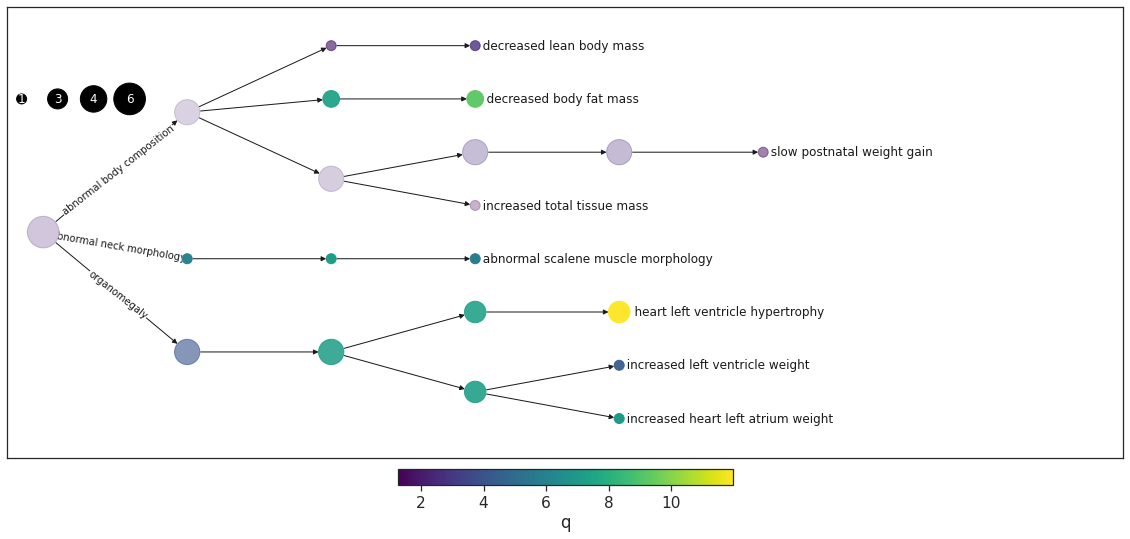

In [221]:
print("Growth/Body Size")
n = draw_significance_hierarchy(results_old.loc[results_old.observed>=1], "C907", "MP:0005378", mp_graph, MPO2, hier_df_genes, term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=10, label="leaf", descriptive_labels=True)

# add minimum observed (set a rule on percent of total?)
# write up rules for inclusion
# which ones to start with
# Added size legend and improved descriptive labelling

Growth/Body Size
PARENT: MP:0002089 abnormal postnatal growth/weight/body size


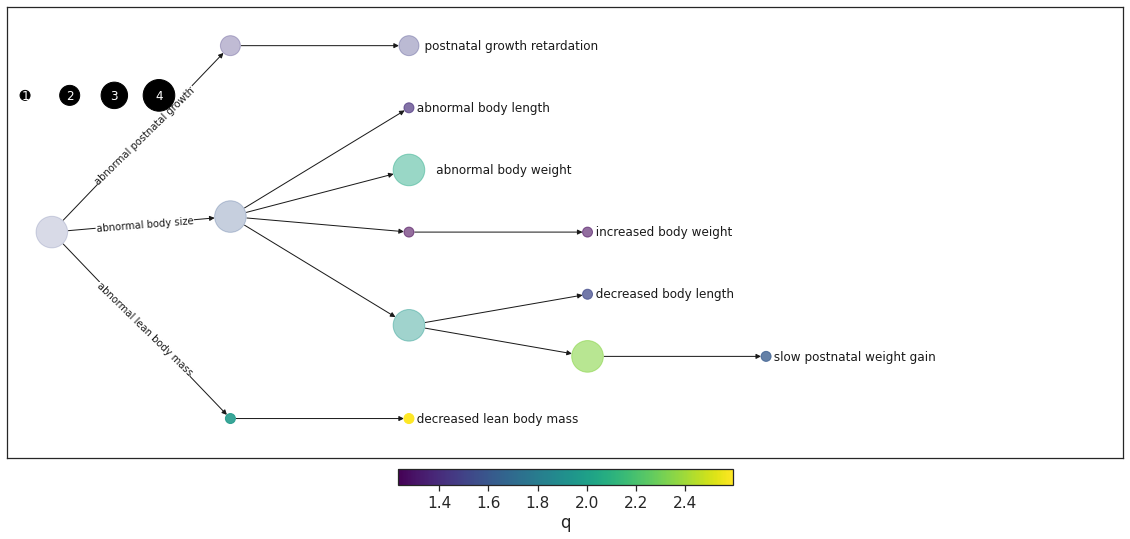

In [223]:
print("Growth/Body Size")
n = draw_significance_hierarchy(results_old.loc[results_old.observed>=1], "C907", "MP:0002089", mp_graph, MPO2, hier_df_genes, term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=10, label="leaf", descriptive_labels=True)

# add minimum observed (set a rule on percent of total?)
# write up rules for inclusion
# which ones to start with
# Added size legend and improved descriptive labelling

In [227]:
n

OR         q  obs                      hits
MP:0005451    6.720640  2.218463  4.0  [MYF5, DMD, MYH4, AKAP6]
MP:0012321    6.925257  2.228452  4.0  [MYF5, DMD, MYH4, AKAP6]
MP:0012323    7.686877  1.260755  1.0                     [DMD]
MP:0012322    7.784598  2.650633  4.0  [MYF5, DMD, MYH4, AKAP6]
MP:0001262    7.789498  2.350960  4.0  [MYF5, DMD, MYH4, AKAP6]
MP:0008489   11.018957  1.620295  1.0                     [DMD]
MP:0012320   86.400922  7.402352  2.0               [DMD, MYF5]
MP:0014143  162.580087  9.262017  2.0               [DMD, MYF5]
MP:0003959   15.045161  1.966011  1.0                    [MYF5]
MP:0003961   24.889628  2.591984  1.0                    [MYF5]

Growth/Body Size
PARENT: MP:0005451 abnormal body composition


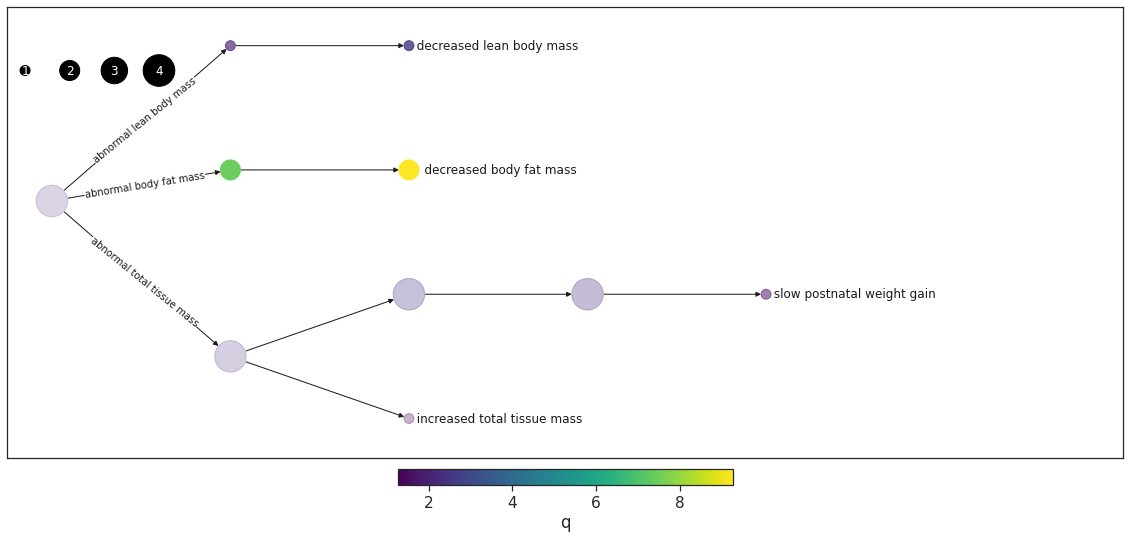

In [225]:
print("Growth/Body Size")
n = draw_significance_hierarchy(results_old.loc[results_old.observed>=1], "C907", "MP:0005451", mp_graph, MPO2, hier_df_genes, term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=10, label="leaf", descriptive_labels=True)

# add minimum observed (set a rule on percent of total?)
# write up rules for inclusion
# which ones to start with
# Added size legend and improved descriptive labelling

In [226]:
n

OR         q  obs                      hits
MP:0005451    6.720640  2.218463  4.0  [MYF5, DMD, MYH4, AKAP6]
MP:0012321    6.925257  2.228452  4.0  [MYF5, DMD, MYH4, AKAP6]
MP:0012323    7.686877  1.260755  1.0                     [DMD]
MP:0012322    7.784598  2.650633  4.0  [MYF5, DMD, MYH4, AKAP6]
MP:0001262    7.789498  2.350960  4.0  [MYF5, DMD, MYH4, AKAP6]
MP:0008489   11.018957  1.620295  1.0                     [DMD]
MP:0012320   86.400922  7.402352  2.0               [DMD, MYF5]
MP:0014143  162.580087  9.262017  2.0               [DMD, MYF5]
MP:0003959   15.045161  1.966011  1.0                    [MYF5]
MP:0003961   24.889628  2.591984  1.0                    [MYF5]

In [224]:
n

OR         q  obs                      hits
MP:0002089   4.668314  1.538856  4.0  [MYF5, DMD, MYH4, AKAP6]
MP:0003959  15.045161  1.966011  1.0                    [MYF5]
MP:0003961  24.889628  2.591984  1.0                    [MYF5]
MP:0003956   5.117735  1.602414  4.0  [MYF5, DMD, MYH4, AKAP6]
MP:0001265   6.037256  1.955206  4.0  [MYF5, DMD, MYH4, AKAP6]
MP:0001262   7.789498  2.350960  4.0  [MYF5, DMD, MYH4, AKAP6]
MP:0008489  11.018957  1.620295  1.0                     [DMD]
MP:0001258  10.098370  1.529227  1.0                    [MYF5]
MP:0001264   7.460081  1.232794  1.0                     [DMD]
MP:0001260   7.686877  1.260755  1.0                     [DMD]
MP:0001259   6.325379  2.046172  4.0  [MYF5, DMD, MYH4, AKAP6]
MP:0001256   8.988857  1.411682  1.0                    [MYF5]
MP:0001731   5.419776  1.453445  2.0               [DMD, MYF5]
MP:0001732   5.562568  1.488327  2.0               [DMD, MYF5]

In [ ]:
n["term_count"] = [term_counts[node] for node in n.index.values]
plot_volcano(n, sig="q", total="term_count")
plt.xscale("log")

In [ ]:
print("Muscle Phys")
n = draw_significance_hierarchy(results_old, "C907", "MP:0002106", mp_graph, MPO2, hier_df_genes, term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=20, label="leaf", descriptive_labels=True, adjust_root=0.2)


In [ ]:
print("Muscle Morph")
n = draw_significance_hierarchy(results_old, "C907", "MP:0002108", mp_graph, MPO2, hier_df_genes, term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=25, label="leaf", descriptive_labels=True, adjust_root=0.2)

In [ ]:
print("Cardio Morph")
n = draw_significance_hierarchy(results_old, "C907", "MP:0002127", mp_graph, MPO2, hier_df_genes, term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=20, label="leaf", descriptive_labels=True)

In [ ]:
print("Cardio Phys")
n = draw_significance_hierarchy(results_old, "C907", "MP:0001544", mp_graph, MPO2, hier_df_genes, term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=20, label="leaf", descriptive_labels=True, adjust_root=0.15)

In [ ]:
n

## C879

In [ ]:
print("Growth/Body Size")
n = draw_significance_hierarchy(results_old, "C879", "MP:0005378", mp_graph, MPO2, hier_df_genes, term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=10, label="leaf", descriptive_labels=True, adjust_root=0.2)

In [ ]:
n["term_count"] = [term_counts[node] for node in n.index.values]
plot_volcano(n, sig="q", total="term_count")
plt.xscale("log")
plt.xlim(0, 10)

In [ ]:
results_old[results_old.name == "C"]

In [ ]:
print("Growth/Body Size")
n = draw_significance_hierarchy(results_old, "C879", "MP:0002089", mp_graph, MPO2, hier_df_genes, term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=10, label="leaf", descriptive_labels=True, adjust_root=0.2)

In [ ]:
print("Consumption Behaviour")
n = draw_significance_hierarchy(results_old, "C879", "MP:0002069", mp_graph, MPO2, hier_df_genes, term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=10, label="leaf", descriptive_labels=True, adjust_root=0.1)

In [ ]:
print("Nervous System Physiology")
n = draw_significance_hierarchy(results_old, "C879", "MP:0003633", mp_graph, MPO2, hier_df_genes, term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="OR", vert=10, label="leaf", descriptive_labels=True, adjust_root=0.3)


In [ ]:
print("Nervous System Physiology")
n = draw_significance_hierarchy(results_old, "C879", "MP:0005253", mp_graph, MPO2, hier_df_genes, term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=10, label="leaf", descriptive_labels=True, adjust_root=0.1)

In [ ]:
print("Nervous System Physiology")
n = draw_significance_hierarchy(results_old, "C877", "MP:0003633", mp_graph, MPO2, hier_df_genes, term_mapping, select_on="proportion", 
                                size_by="OR", alpha_by="OR",color_by="q", vert=10, label="leaf", descriptive_labels=True, adjust_root=0.1)

In [ ]:
n

In [ ]:
results_old.loc["MP:0005669"]

## C882

In [ ]:
print("Growth/Body Size")
n = draw_significance_hierarchy(results_old, "C882", "MP:0003956", mp_graph, MPO2, hier_df_genes, term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=10, label="leaf", descriptive_labels=True, adjust_root=0.2)

In [ ]:
n

In [ ]:
print("Cellular Phys")
n = draw_significance_hierarchy(results_old, "C882", "MP:0005621", mp_graph, MPO2, hier_df_genes, term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=10, label="leaf", descriptive_labels=True, adjust_root=0.2)

In [ ]:
print("Embryo Dev")
n = draw_significance_hierarchy(results_old, "C882", "MP:0001672", mp_graph, MPO2, hier_df_genes, term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=10, label="leaf", descriptive_labels=True, adjust_root=0.1)

In [ ]:
print("Embryo Morph")
n = draw_significance_hierarchy(results_old, "C882", "MP:0014134", mp_graph, MPO2, hier_df_genes, term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="OR", vert=10, label="leaf", descriptive_labels=False, adjust_root=0.2)

In [ ]:
n.loc["MP:0001697"].hits

In [ ]:
print("Nervous System Morph")
n = draw_significance_hierarchy(results_old, "C882", "MP:0003632", mp_graph, MPO2, hier_df_genes, term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=10, label="leaf", descriptive_labels=True, adjust_root=0.3)

# Heatmap

In [ ]:
results_old.head()

In [ ]:
body_size_traits = ["MP:0005378", "MP:0003956", "MP:0010866", "MP:0005451"]

In [ ]:
results_BMI = results_old.loc[body_size_traits, ("name", "description", "OR", "OR_p")]
results_BMI.head()

In [ ]:
new_annotations = pd.read_csv("~/Data/Transfer/rat/update_GO_annotations.csv", usecols=["name", "represents"])
new_annotations.head()

In [ ]:
results_BMI = results_BMI.merge(new_annotations, left_on="name", right_on="represents")

In [ ]:
results_BMI

In [ ]:
keep_nodes = {results_BMI.loc[n, ("represents")] for n in results_BMI.index if "None" not in results_BMI.loc[n, "name_y"]}

In [ ]:
NES_nodes = ["C878", "C883", "C912", "C879", "C884", "C891", "C907", "C894", "C909"]
C880_nodes = ["C880", "C881", "C922", "C905", "C899", "C918", "C934", "C929"]
meth_nodes = ["C882", "C886", "C900"]
mapk_nodes = ["C889", "C917"]
singles = ["C885", "C887", "C888", "C904", "C931"]

In [ ]:
all_nodes = NES_nodes + C880_nodes + meth_nodes + mapk_nodes + singles

In [ ]:
keep_nodes = [node for node in all_nodes if node in results_BMI.name_x.values]

In [ ]:
results_BMI.head()

In [ ]:
results_BMI = results_BMI.assign(sig_OR=[results_BMI.loc[x, "OR"] if results_BMI.loc[x, "OR_p"] < 0.01 else None 
                                         for x in results_BMI.index])

In [ ]:
missing_nodes = [n for n in all_nodes if n not in keep_nodes]

In [ ]:
OR_table = results_BMI.loc[results_BMI.name_x.isin(keep_nodes)].pivot(index="description", columns="name_x", values="sig_OR")

In [ ]:
OR_table = OR_table.loc[:, keep_nodes]
for n in missing_nodes:
    OR_table[n] = [np.nan] * 4

In [ ]:
_, ax = plt.subplots(figsize=(12,2))

sns.heatmap(np.log2(OR_table.iloc[0:4]), cmap='RdBu', center=0, cbar_kws={"aspect":10, "ticks":[-1, 0, 1, 2,3,4]})
plt.ylabel("")
plt.xlabel("")
ax.xaxis.tick_top()
_ = plt.xticks(rotation=90)
ax.tick_params(axis=u'both', which=u'both',length=0)
plt.title("Log2(OR) for communities where p < 0.01")

In [ ]:
OR_table.fillna(1, inplace=True)

In [ ]:
sns.clustermap(np.log2(OR_table.loc[keep_nodes]), cmap='viridis', col_cluster=False, figsize=(10,15))

# Ignore - New MGI data

In [ ]:
mgi_df_new = load_MGI_mouseKO_data(url='http://www.informatics.jax.org/downloads/reports/MGI_PhenoGenoMP.rpt', map_using="mgi2", update=False)

In [ ]:
mgi_df_new.head()

In [ ]:
MPO_new = load_MPO(use_genes=True, mapping=mgi_df_new)

In [ ]:
term_counts_new, gene_mapping_new, term_mapping_new = genes_per_node(MPO_new)

In [ ]:
tc = pd.DataFrame.from_dict(term_counts_new, orient="index", columns=["new"])
tc = tc.join(pd.DataFrame.from_dict(term_counts, orient="index", columns=["original"]))

In [ ]:
plt.scatter(data=tc, x="original", y="new", s=2)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Original gene mapping")
plt.ylabel("New gene mapping")
plt.title("Number of genes per term")

In [ ]:
phenotypes = []
term_counts, gene_mapping, term_mapping = genes_per_node(MPO_new)
for community in tqdm(hier_df_genes.index):
    x = community_term_enrichment_old(community, hier_df_genes, MPO_new, mgi_df_new, term_counts, gene_mapping)
    x = x.assign(name=community)
    phenotypes.append(x)

In [ ]:
new_results = pd.concat(phenotypes)
new_results.head()

In [ ]:
results_old.head()

In [ ]:
b[b.description=="abnormal consumption behavior"]

In [ ]:
term_counts, gene_mapping, term_mapping = genes_per_node(MPO2)

In [ ]:
term_counts_new["MP:0002069"]

In [ ]:
term_counts["MP:0002069"]

In [ ]:
old_genes = term_mapping["MP:0002069"]
old_genes = [MPO2.genes[i] for i in old_genes]
old_genes = set(old_genes)

In [ ]:
new_genes = term_mapping["MP:0002069"]
new_genes = [MPO_new.genes[i] for i in new_genes]
new_genes = set(new_genes)

In [ ]:
new_genes

In [ ]:
old_genes